Loading data from: /standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized/train/Re_550_normalized.pt
Loaded 400 timestep pairs
Data type: NORMALIZED
Loaded metadata from: karman_dataset_metadata.json

Data structure:
  x.shape: torch.Size([120696, 10]) (positions + physics)
  y.shape: torch.Size([120696, 7]) (physics only)
  pos.shape: torch.Size([120696, 3])
  edge_index.shape: torch.Size([2, 623052])
  global_params: [0.5495495]
  Reynolds number: 550

KARMAN VORTEX DATA OVERVIEW
Visualizing timesteps: [0, 100, 200, 300]
Data type: NORMALIZED
Plotting mode: Physical units (denormalized)

1. All features at first timestep...
Saved figure to: visualizations/all_features_t0.png


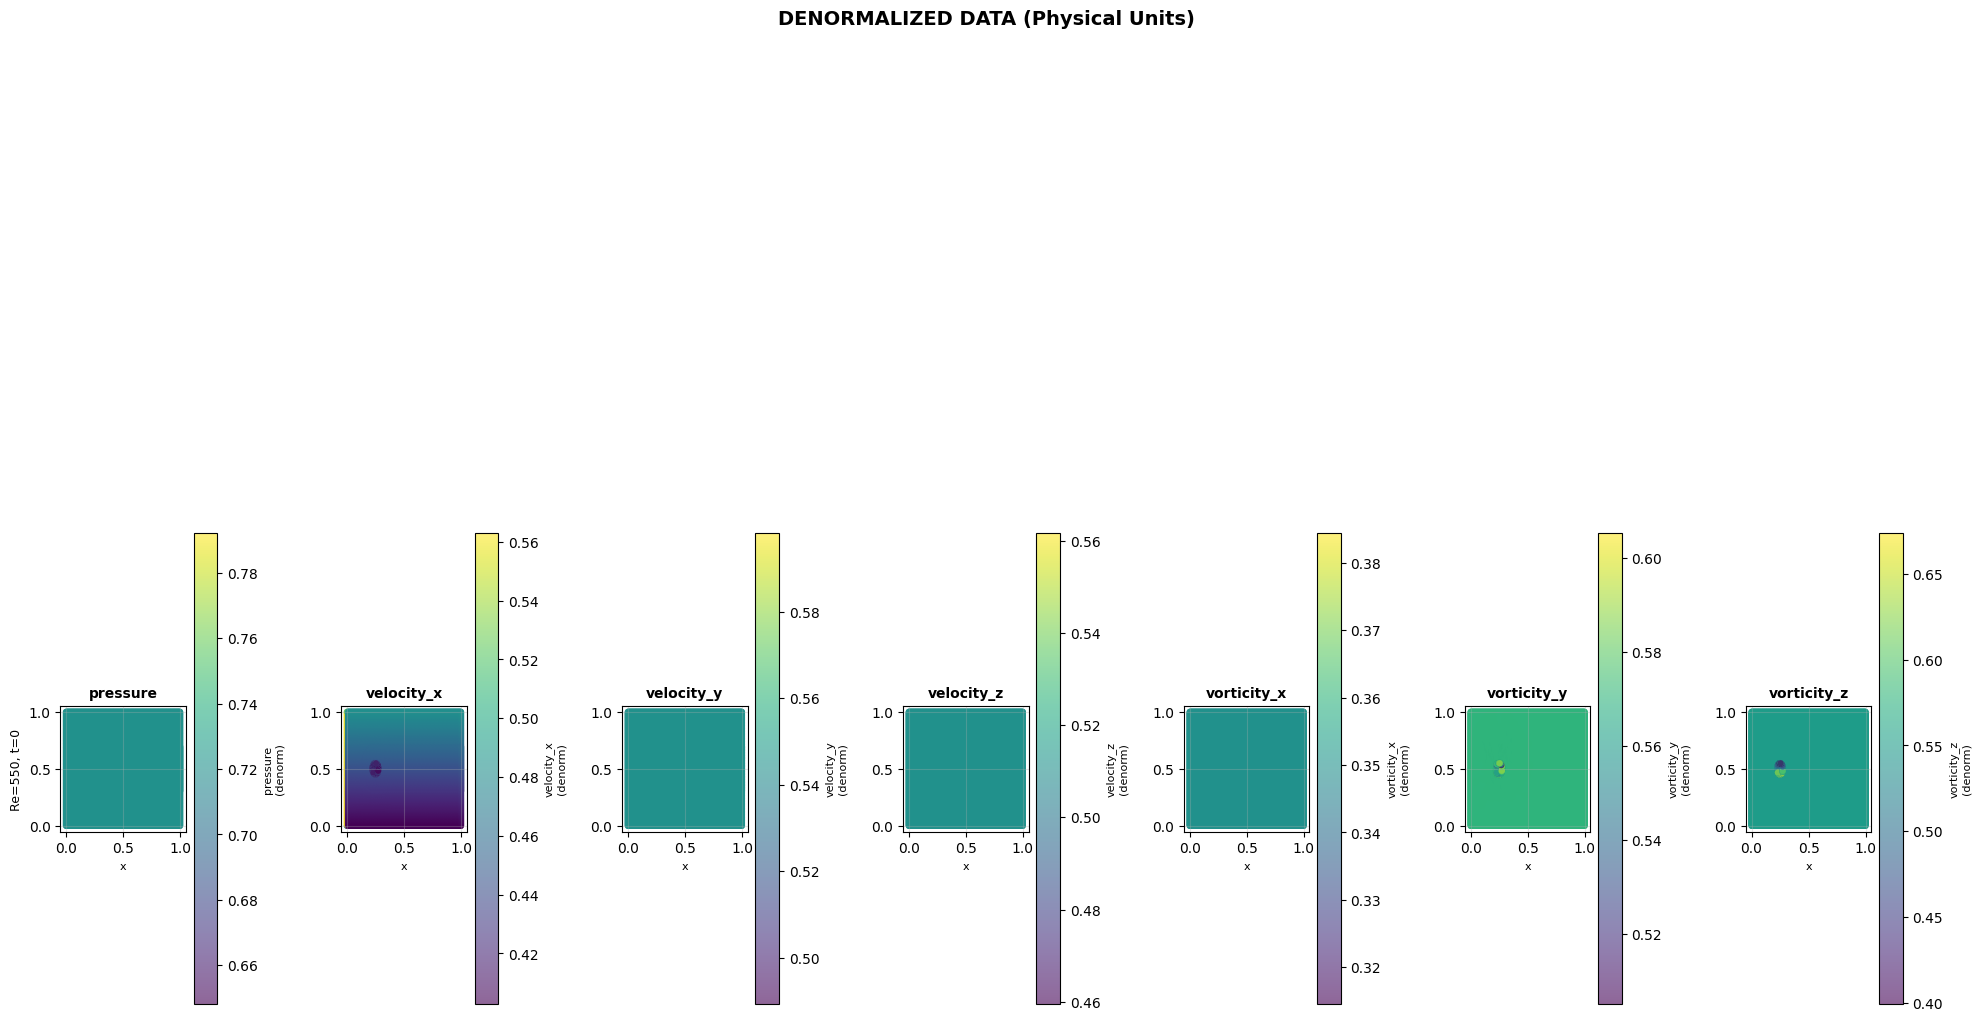


2. Vorticity evolution...
Saved figure to: visualizations/vorticity_evolution.png


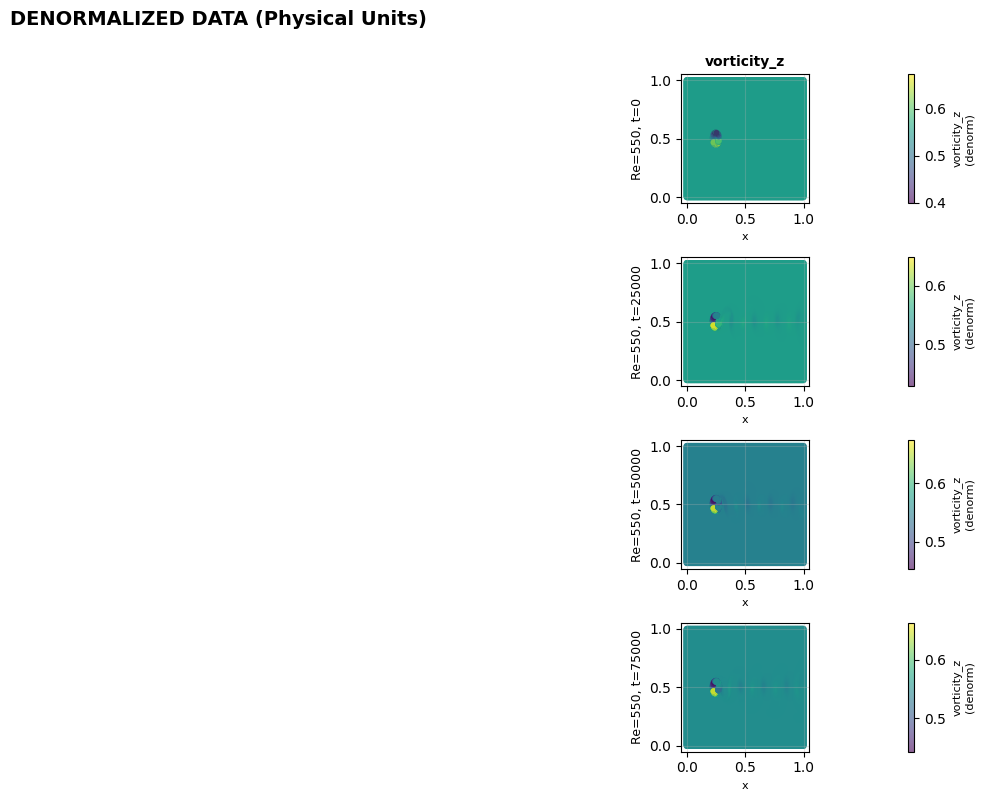


3. Velocity evolution...
Saved figure to: visualizations/velocity_evolution.png


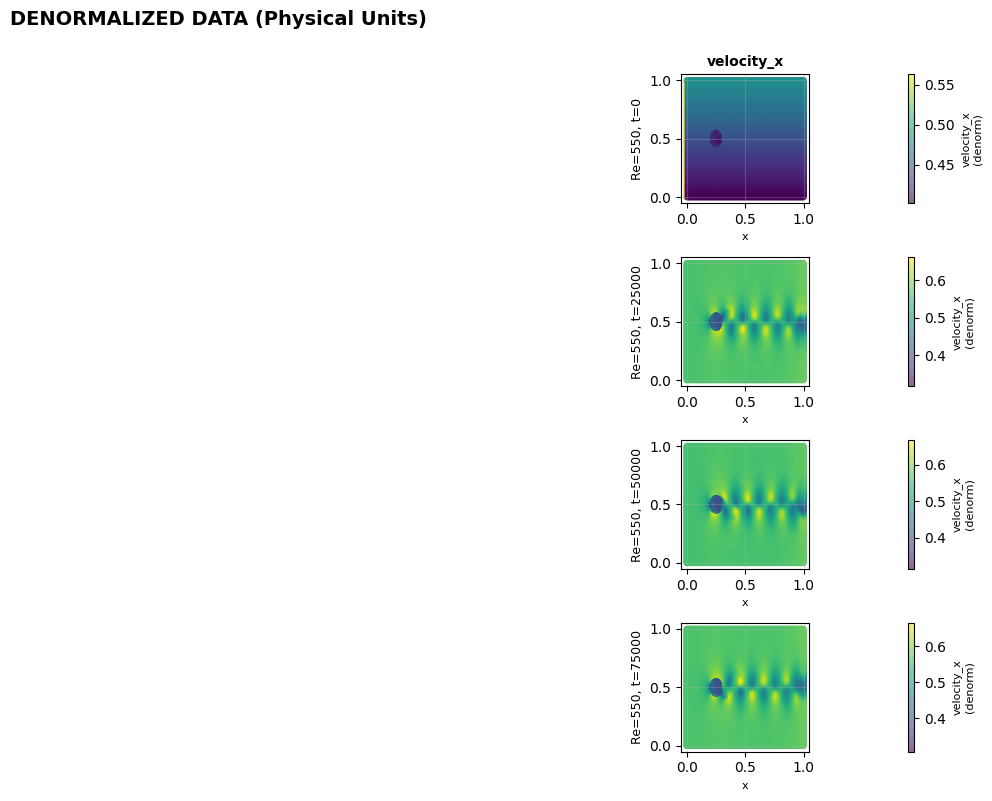


4. Feature statistics over time...
Saved statistics plot to: visualizations/feature_statistics.png


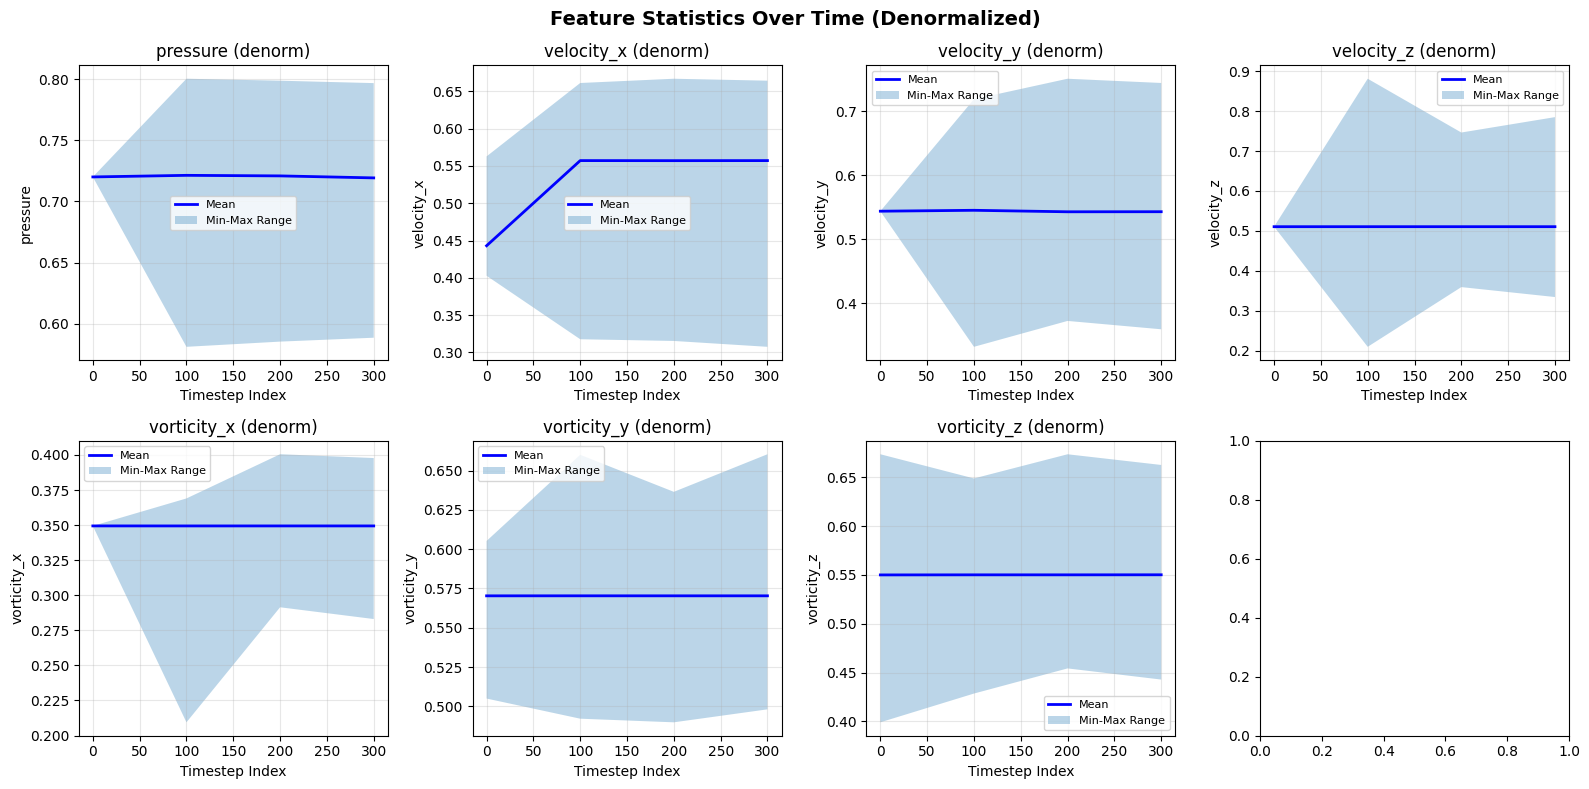


Overview complete!

VISUALIZATION TIPS:
1. For NORMALIZED data:
   - use_physical_units=True  → Shows denormalized values
   - use_physical_units=False → Shows normalized [0,1] values

2. For RAW data:
   - Always shows physical units (use_physical_units has no effect)

3. Visualizer auto-detects if data is normalized based on filename
   - Override with: viz = KarmanVortexVisualizer(file, normalized=True/False)


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import json
from pathlib import Path

class KarmanVortexVisualizer:
    """Visualize Karman vortex street data from processed PyG format."""
    
    def __init__(self, data_file, metadata_file=None, normalized=None):
        """
        Args:
            data_file: Path to .pt file (e.g., individual case or split file)
            metadata_file: Path to metadata JSON (optional, for feature names)
            normalized: Whether data is normalized (auto-detects if None)
        """
        self.data_file = Path(data_file)
        print(f"Loading data from: {self.data_file}")
        
        # Load data
        self.data_list = torch.load(self.data_file, weights_only=False)
        print(f"Loaded {len(self.data_list)} timestep pairs")
        
        # Auto-detect normalization if not specified
        if normalized is None:
            self.is_normalized = 'normalized' in str(self.data_file).lower()
        else:
            self.is_normalized = normalized
        
        print(f"Data type: {'NORMALIZED' if self.is_normalized else 'RAW'}")
        
        # Load metadata if available
        if metadata_file:
            with open(metadata_file, 'r') as f:
                self.metadata = json.load(f)
        else:
            # Try to find metadata in parent/grandparent directory
            possible_paths = [
                self.data_file.parent / "karman_dataset_metadata.json",
                self.data_file.parent.parent / "karman_dataset_metadata.json",
                self.data_file.parent / "normalization_metadata.json",
                self.data_file.parent.parent / "normalization_metadata.json"
            ]
            
            self.metadata = None
            for path in possible_paths:
                if path.exists():
                    with open(path, 'r') as f:
                        self.metadata = json.load(f)
                    print(f"Loaded metadata from: {path.name}")
                    break
        
        # Load normalization params if normalized data
        self.norm_params = None
        if self.is_normalized and self.metadata:
            if 'normalization_params' in self.metadata:
                self.norm_params = self.metadata['normalization_params']
            elif 'original_metadata' in self.metadata:
                # For nested metadata structure
                orig_meta = self.metadata['original_metadata']
                if 'variable_statistics' in orig_meta:
                    self.norm_params = self._extract_norm_params(orig_meta)
        
        if self.is_normalized and self.norm_params:
            print("Normalization parameters loaded for denormalization")
        
        # Define feature names
        self.position_vars = ['x_pos', 'y_pos', 'z_pos']
        self.physics_vars = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                           'vorticity_x', 'vorticity_y', 'vorticity_z']
        self.all_vars = self.position_vars + self.physics_vars
        
        # Get sample data info
        sample = self.data_list[0]
        print(f"\nData structure:")
        print(f"  x.shape: {sample.x.shape} (positions + physics)")
        print(f"  y.shape: {sample.y.shape} (physics only)")
        print(f"  pos.shape: {sample.pos.shape}")
        print(f"  edge_index.shape: {sample.edge_index.shape}")
        if hasattr(sample, 'global_params') and sample.global_params is not None:
            print(f"  global_params: {sample.global_params.numpy()}")
        if hasattr(sample, 'reynolds_number'):
            print(f"  Reynolds number: {sample.reynolds_number}")
    
    def _extract_norm_params(self, metadata):
        """Extract normalization parameters from metadata structure."""
        params = {}
        if 'variable_statistics' in metadata:
            global_stats = metadata['variable_statistics'].get('global_statistics', {})
            for var in self.all_vars:
                if var in global_stats:
                    params[var] = {
                        'min': global_stats[var]['min'],
                        'max': global_stats[var]['max']
                    }
        return params
    
    def denormalize_values(self, values, var_name):
        """Denormalize values back to physical units."""
        if not self.is_normalized or not self.norm_params or var_name not in self.norm_params:
            return values
        
        params = self.norm_params[var_name]
        var_min, var_max = params['min'], params['max']
        
        # Reverse min-max normalization
        denorm = values * (var_max - var_min) + var_min
        return denorm
    
    def visualize_timesteps(self, timestep_indices, features_to_plot=None, 
                          figsize=(20, 12), save_path=None, show_mesh=False,
                          use_physical_units=True):
        """
        Visualize selected features across multiple timesteps.
        
        Args:
            timestep_indices: List of timestep pair indices to visualize
            features_to_plot: List of feature names to plot (default: all physics)
            figsize: Figure size (width, height)
            save_path: Path to save figure (optional)
            show_mesh: Whether to show mesh edges (can be slow)
            use_physical_units: If True, denormalize data for plotting (default: True)
        """
        if features_to_plot is None:
            # Default: plot all physics variables
            features_to_plot = self.physics_vars
        
        n_timesteps = len(timestep_indices)
        n_features = len(features_to_plot)
        
        fig, axes = plt.subplots(n_timesteps, n_features, 
                                figsize=figsize, squeeze=False)
        
        # Add super title indicating normalization state
        if self.is_normalized:
            if use_physical_units:
                fig.suptitle('DENORMALIZED DATA (Physical Units)', 
                           fontsize=14, fontweight='bold', y=0.995)
            else:
                fig.suptitle('NORMALIZED DATA [0, 1]', 
                           fontsize=14, fontweight='bold', y=0.995)
        else:
            fig.suptitle('RAW DATA (Physical Units)', 
                       fontsize=14, fontweight='bold', y=0.995)
        
        for row, ts_idx in enumerate(timestep_indices):
            if ts_idx >= len(self.data_list):
                print(f"Warning: Timestep index {ts_idx} out of range")
                continue
            
            data = self.data_list[ts_idx]
            
            # Get positions (2D projection: x-y plane)
            pos = data.pos.numpy()
            
            # Denormalize positions if needed
            if self.is_normalized and use_physical_units:
                x = self.denormalize_values(pos[:, 0], 'x_pos')
                y = self.denormalize_values(pos[:, 1], 'y_pos')
            else:
                x, y = pos[:, 0], pos[:, 1]
            
            # Get Reynolds number if available
            re_num = data.reynolds_number if hasattr(data, 'reynolds_number') else 'Unknown'
            ts_current = data.timestep_current if hasattr(data, 'timestep_current') else ts_idx
            
            for col, feature_name in enumerate(features_to_plot):
                ax = axes[row, col]
                
                # Get feature index in x tensor
                if feature_name in self.all_vars:
                    feat_idx = self.all_vars.index(feature_name)
                    if feat_idx < data.x.shape[1]:
                        values = data.x[:, feat_idx].numpy()
                        
                        # Denormalize if needed
                        if self.is_normalized and use_physical_units:
                            values = self.denormalize_values(values, feature_name)
                    else:
                        print(f"Warning: {feature_name} not in data")
                        continue
                else:
                    print(f"Warning: Unknown feature {feature_name}")
                    continue
                
                # Create scatter plot
                scatter = ax.scatter(x, y, c=values, cmap='viridis', 
                                   s=20, alpha=0.6, edgecolors='none')
                
                # Add mesh edges if requested (warning: can be slow)
                if show_mesh and row == 0 and col == 0:  # Only show once
                    edge_index = data.edge_index.numpy()
                    for i in range(min(edge_index.shape[1], 1000)):  # Limit edges
                        src, dst = edge_index[0, i], edge_index[1, i]
                        ax.plot([x[src], x[dst]], [y[src], y[dst]], 
                               'k-', alpha=0.1, linewidth=0.3)
                
                # Colorbar
                cbar = plt.colorbar(scatter, ax=ax)
                
                # Format colorbar label based on normalization
                if self.is_normalized and use_physical_units:
                    label = f"{feature_name}\n(denorm)"
                elif self.is_normalized:
                    label = f"{feature_name}\n[0,1]"
                else:
                    label = feature_name
                cbar.set_label(label, fontsize=8)
                
                # Title and labels
                if row == 0:
                    ax.set_title(f"{feature_name}", fontsize=10, fontweight='bold')
                if col == 0:
                    ax.set_ylabel(f"Re={re_num}, t={ts_current}", fontsize=9)
                
                ax.set_xlabel('x', fontsize=8)
                ax.set_aspect('equal')
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            # Create parent directory if it doesn't exist
            save_path_obj = Path(save_path)
            save_path_obj.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved figure to: {save_path}")
        
        plt.show()
    
    def visualize_single_timestep_all_features(self, timestep_idx=0, 
                                              figsize=(20, 15), save_path=None,
                                              use_physical_units=True):
        """Visualize all features for a single timestep."""
        self.visualize_timesteps([timestep_idx], features_to_plot=self.physics_vars,
                                figsize=figsize, save_path=save_path,
                                use_physical_units=use_physical_units)
    
    def visualize_feature_evolution(self, feature_name, timestep_indices, 
                                   figsize=(20, 8), save_path=None,
                                   use_physical_units=True):
        """Visualize how a single feature evolves across timesteps."""
        self.visualize_timesteps(timestep_indices, features_to_plot=[feature_name],
                                figsize=figsize, save_path=save_path,
                                use_physical_units=use_physical_units)
    
    def plot_feature_statistics(self, timestep_indices=None, save_path=None,
                               use_physical_units=True):
        """Plot statistics (min, max, mean) of features over timesteps."""
        if timestep_indices is None:
            timestep_indices = range(min(len(self.data_list), 100))
        
        stats = {feat: {'min': [], 'max': [], 'mean': [], 'std': []} 
                for feat in self.physics_vars}
        
        for idx in timestep_indices:
            data = self.data_list[idx]
            for feat_idx, feat_name in enumerate(self.physics_vars):
                if feat_idx + 3 < data.x.shape[1]:  # +3 for positions
                    values = data.x[:, feat_idx + 3].numpy()
                    
                    # Denormalize if needed
                    if self.is_normalized and use_physical_units:
                        values = self.denormalize_values(values, feat_name)
                    
                    stats[feat_name]['min'].append(values.min())
                    stats[feat_name]['max'].append(values.max())
                    stats[feat_name]['mean'].append(values.mean())
                    stats[feat_name]['std'].append(values.std())
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        
        # Add super title
        if self.is_normalized:
            if use_physical_units:
                fig.suptitle('Feature Statistics Over Time (Denormalized)', 
                           fontsize=14, fontweight='bold')
            else:
                fig.suptitle('Feature Statistics Over Time (Normalized [0,1])', 
                           fontsize=14, fontweight='bold')
        else:
            fig.suptitle('Feature Statistics Over Time (Raw Data)', 
                       fontsize=14, fontweight='bold')
        
        for idx, feat_name in enumerate(self.physics_vars):
            ax = axes[idx]
            
            timesteps = list(timestep_indices)
            ax.plot(timesteps, stats[feat_name]['mean'], 'b-', label='Mean', linewidth=2)
            ax.fill_between(timesteps, stats[feat_name]['min'], 
                           stats[feat_name]['max'], alpha=0.3, label='Min-Max Range')
            
            ax.set_xlabel('Timestep Index')
            ax.set_ylabel(feat_name)
            
            # Title shows data type
            title = feat_name
            if self.is_normalized and use_physical_units:
                title += ' (denorm)'
            elif self.is_normalized:
                title += ' [0,1]'
            ax.set_title(title)
            
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved statistics plot to: {save_path}")
        
        plt.show()
    
    def quick_overview(self, n_timesteps=5, save_dir=None, use_physical_units=True):
        """Generate a quick overview with multiple visualizations."""
        print(f"\n{'='*60}")
        print("KARMAN VORTEX DATA OVERVIEW")
        print(f"{'='*60}")
        
        # Select evenly spaced timesteps
        total_timesteps = len(self.data_list)
        step = max(1, total_timesteps // n_timesteps)
        selected_indices = list(range(0, total_timesteps, step))[:n_timesteps]
        
        print(f"Visualizing timesteps: {selected_indices}")
        print(f"Data type: {'NORMALIZED' if self.is_normalized else 'RAW'}")
        if self.is_normalized:
            print(f"Plotting mode: {'Physical units (denormalized)' if use_physical_units else 'Normalized [0,1]'}")
        
        # 1. All features for first timestep
        print("\n1. All features at first timestep...")
        save_path1 = Path(save_dir) / "all_features_t0.png" if save_dir else None
        self.visualize_single_timestep_all_features(0, save_path=save_path1,
                                                   use_physical_units=use_physical_units)
        
        # 2. Vorticity magnitude evolution
        print("\n2. Vorticity evolution...")
        save_path2 = Path(save_dir) / "vorticity_evolution.png" if save_dir else None
        self.visualize_feature_evolution('vorticity_z', selected_indices, 
                                        save_path=save_path2,
                                        use_physical_units=use_physical_units)
        
        # 3. Velocity magnitude evolution
        print("\n3. Velocity evolution...")
        save_path3 = Path(save_dir) / "velocity_evolution.png" if save_dir else None
        self.visualize_feature_evolution('velocity_x', selected_indices,
                                        save_path=save_path3,
                                        use_physical_units=use_physical_units)
        
        # 4. Feature statistics
        print("\n4. Feature statistics over time...")
        save_path4 = Path(save_dir) / "feature_statistics.png" if save_dir else None
        self.plot_feature_statistics(selected_indices, save_path=save_path4,
                                   use_physical_units=use_physical_units)
        
        print("\nOverview complete!")


# Example usage
if __name__ == "__main__":
    # MODIFY THESE PATHS TO YOUR DATA
    
    # Example 1: RAW (unnormalized) data
    # DATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/processed_multi_dir/individual_cases/Reynolds_100_dir0_raw_data.pt"
    
    # Example 2: NORMALIZED data
    DATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized/train/Re_550_normalized.pt"
    
    # Or use a split file:
    # DATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/processed_multi_dir/karman_vortex_train_with_pos.pt"
    
    # Create visualizer
    viz = KarmanVortexVisualizer(DATA_FILE)
    
    # Option 1: Quick overview (recommended for first look)
    # use_physical_units=True will denormalize the data for plotting (if normalized)
    # use_physical_units=False will show normalized values [0, 1]
    viz.quick_overview(n_timesteps=4, save_dir="./visualizations", use_physical_units=True)
    
    # Option 2: Visualize specific timesteps and features
    # viz.visualize_timesteps(
    #     timestep_indices=[0, 10, 20, 30],
    #     features_to_plot=['vorticity_z', 'velocity_x', 'pressure'],
    #     save_path="custom_viz.png",
    #     use_physical_units=True  # Set to False to see normalized values
    # )
    
    
    print("\n" + "="*60)
    print("VISUALIZATION TIPS:")
    print("="*60)
    print("1. For NORMALIZED data:")
    print("   - use_physical_units=True  → Shows denormalized values")
    print("   - use_physical_units=False → Shows normalized [0,1] values")
    print("\n2. For RAW data:")
    print("   - Always shows physical units (use_physical_units has no effect)")
    print("\n3. Visualizer auto-detects if data is normalized based on filename")
    print("   - Override with: viz = KarmanVortexVisualizer(file, normalized=True/False)")
    print("="*60)
    #     save_path="custom_viz.png"
    # )
    
    # Option 3: Single feature evolution
    # viz.visualize_feature_evolution('vorticity_z', timestep_indices=range(0, 50, 5))


🌊 KARMAN VORTEX COARSENING ANALYSIS

📁 Data file: /standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized/train/Re_550_normalized.pt
⚙️  Config:
   - Sample timesteps: 30
   - Temporal weight: 0.8
   - Keep percentile: 50
   - Output: ./coarsening_analysis

⏳ Loading data...
✅ Loaded 400 timestep pairs
📊 Sampling 30 timesteps from 400 total
🔷 Mesh: 120,696 nodes, 623,052 edges
📋 Features per node: 10
   - Positions: 0-2 (x, y, z)
   - Physics: 3+ (pressure, velocity, vorticity)

🔬 MESH COARSENING ANALYSIS FOR AUTOREGRESSIVE MODELING

[Step 1/5] Computing temporal importance...
⏳ Collecting temporal data...
🧮 Computing temporal importance (variance)...
   Range: [0.0000, 1.0000]
   Mean: 0.0020, Std: 0.0156

[Step 2/5] Computing spatial importance...
🔍 Computing spatial gradients...
   Range: [0.0000, 1.0000]

[Step 3/5] Identifying boundary nodes...
🛡️  Boundary nodes (degree < 3.8): 8
🛡️  Boundary nodes (position): 15,662
🛡️  Total protected: 15,662 (13.0%)

[Step 4

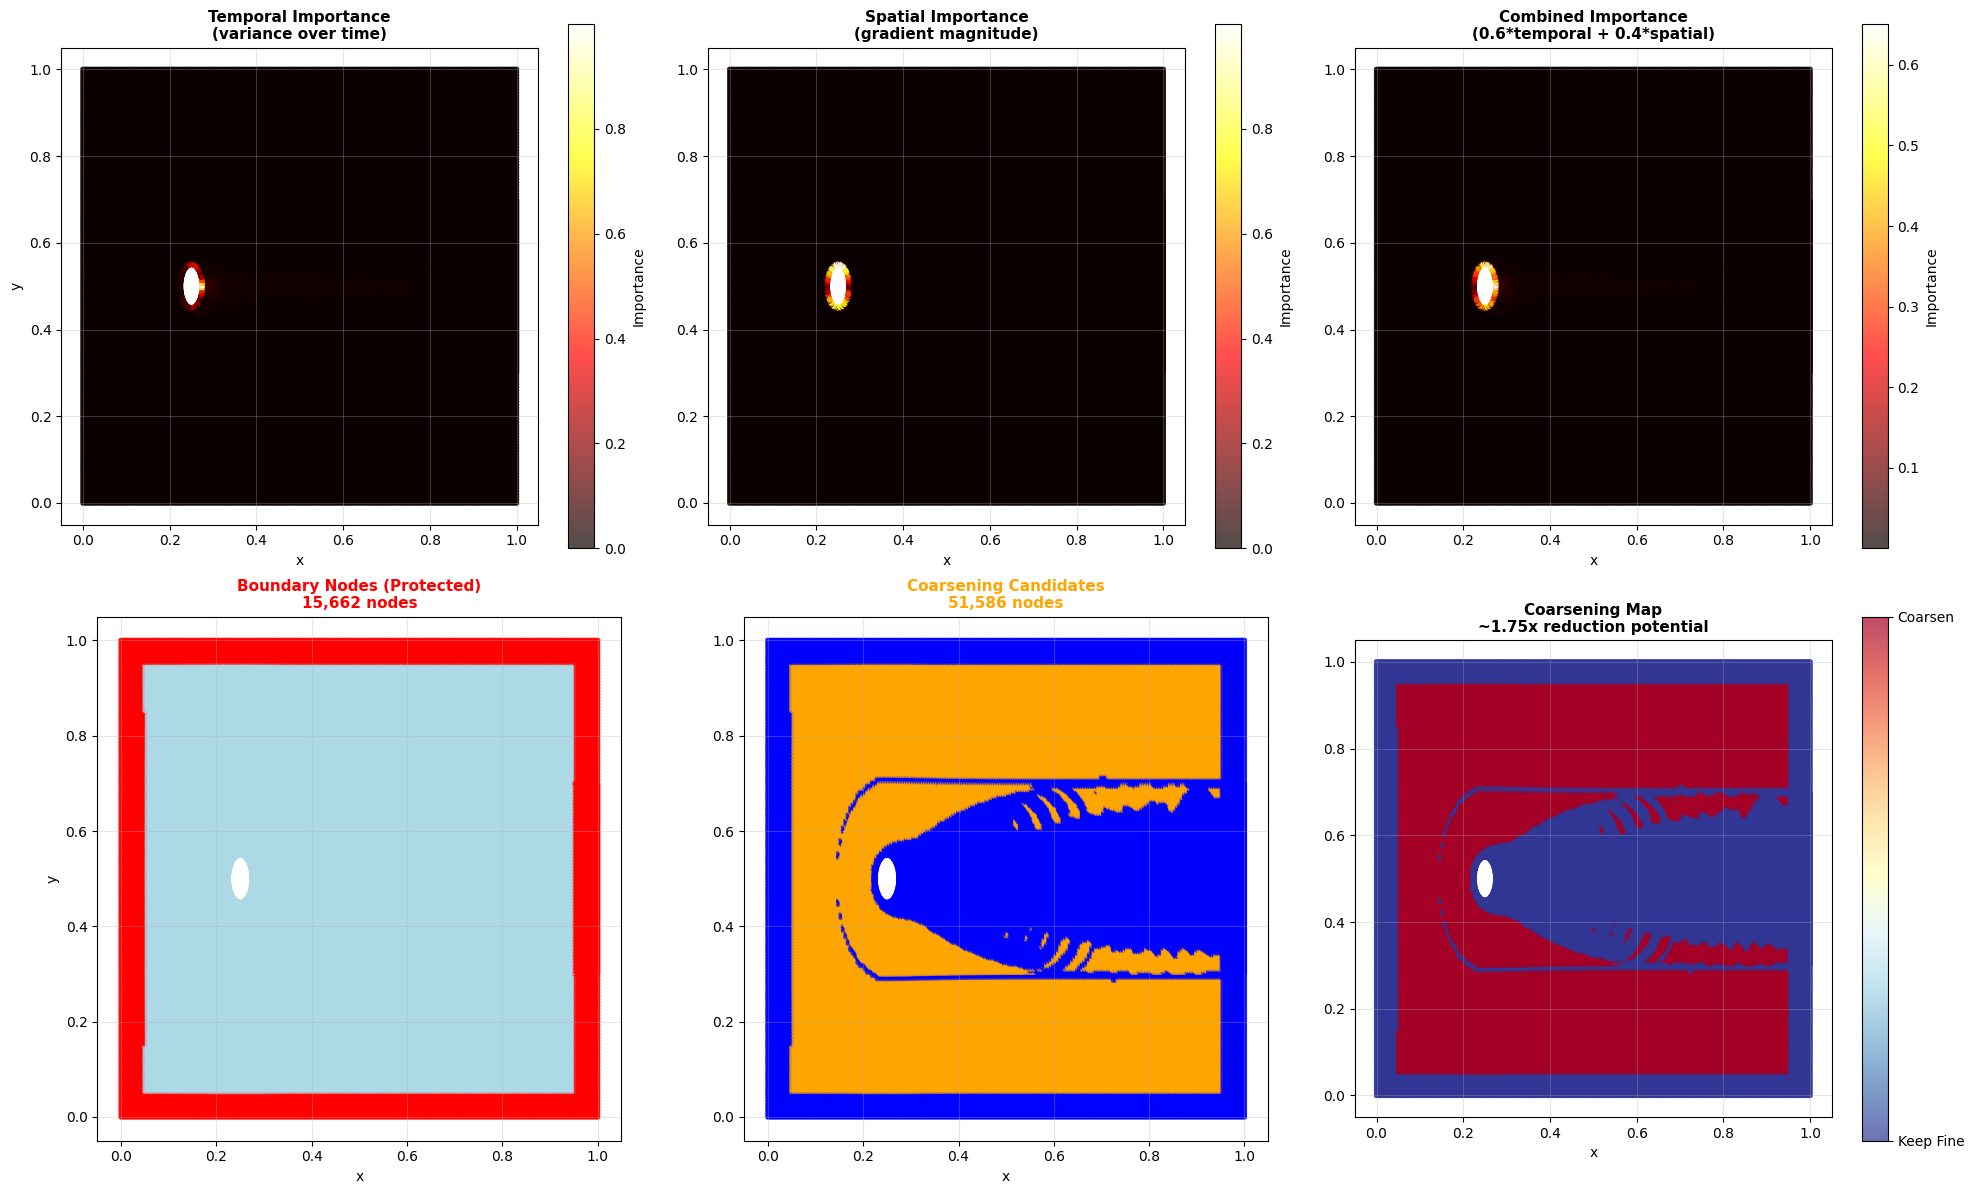


📈 SUMMARY & RECOMMENDATIONS

📊 MESH STATISTICS:
   Original nodes: 120,696
   Nodes to keep fine: 69,110 (57.3%)
   Nodes to coarsen: 51,586 (42.7%)
   Potential reduction: 1.75x
   (Assumes each coarsenable node merges with one neighbor)

⚡ EXPECTED PERFORMANCE:
   Training speedup: ~2.3x per epoch
   Memory reduction: ~1.7x
   Autoregressive rollout: ~2.3x faster

🎯 PHYSICS PRESERVATION:
   ✅ Vortex cores: Protected (high temporal variance)
   ✅ Wake region: Protected (high spatial gradients)
   ✅ Cylinder boundary: Protected (boundary detection)
   ✅ Smooth interior: Coarsened (low importance)

🔧 TUNING RECOMMENDATIONS:
   ✅ Reduction looks reasonable (1.75x)

📝 NEXT STEPS FOR AUTOREGRESSIVE MODELING:
   1. Implement static coarsening map S (one-time computation)
   2. For each timestep: X_coarse = aggregate(X_fine, S)
   3. Train GNN on coarsened sequences
   4. Predict: X_coarse(t+1) = Model(X_coarse(t))
   5. Optional: Prolong to fine mesh for visualization
   6. Validate: Check

In [4]:
"""
Complete Karman Vortex Mesh Coarsening Analysis
================================================

This script analyzes your CFD mesh to identify which nodes can be coarsened
for more efficient autoregressive physics modeling.

Usage:
    python karman_coarsening_complete.py

Then modify the DATA_FILE path at the bottom to point to your .pt file.

Author: Analysis for autoregressive Karman vortex modeling
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from pathlib import Path
from scipy.spatial import cKDTree
import json


class MeshCoarseningAnalyzer:
    """Analyze mesh coarsening opportunities for temporal physics data."""
    
    def __init__(self, data_list, sample_timesteps=None):
        """
        Args:
            data_list: List of PyG Data objects (timestep pairs)
            sample_timesteps: Number of timesteps to analyze (None = all)
        """
        self.data_list = data_list
        
        # Sample timesteps if dataset is large
        if sample_timesteps and len(data_list) > sample_timesteps:
            indices = np.linspace(0, len(data_list)-1, sample_timesteps, dtype=int)
            self.sample_data = [data_list[i] for i in indices]
            print(f"📊 Sampling {sample_timesteps} timesteps from {len(data_list)} total")
        else:
            self.sample_data = data_list
            print(f"📊 Using all {len(data_list)} timesteps")
        
        # Get reference geometry from first timestep
        self.reference_data = data_list[0]
        self.pos = self.reference_data.pos.numpy()
        self.edge_index = self.reference_data.edge_index.numpy()
        self.n_nodes = self.pos.shape[0]
        
        print(f"🔷 Mesh: {self.n_nodes:,} nodes, {self.edge_index.shape[1]:,} edges")
        
        # Feature indices (assuming x = [pos, physics])
        # Positions: 0-2, Physics: 3+ (pressure, vel_x, vel_y, vel_z, vort_x, vort_y, vort_z)
        self.physics_start_idx = 3
        self.feature_names = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                             'vorticity_x', 'vorticity_y', 'vorticity_z']
        
        # Print data structure
        print(f"📋 Features per node: {self.reference_data.x.shape[1]}")
        print(f"   - Positions: 0-2 (x, y, z)")
        print(f"   - Physics: 3+ (pressure, velocity, vorticity)")
    
    def compute_temporal_importance(self, feature_indices=None, method='variance'):
        """
        Compute per-node temporal importance scores.
        
        Args:
            feature_indices: Which physics features to consider (None = all)
            method: 'variance', 'max_change', or 'combined'
        
        Returns:
            importance: (n_nodes,) array of importance scores
        """
        if feature_indices is None:
            # Use all physics features
            feature_indices = range(self.physics_start_idx, 
                                   self.reference_data.x.shape[1])
        
        n_features = len(feature_indices)
        n_timesteps = len(self.sample_data)
        
        # Collect values over time: (n_nodes, n_features, n_timesteps)
        values_over_time = np.zeros((self.n_nodes, n_features, n_timesteps))
        
        print("⏳ Collecting temporal data...")
        for t_idx, data in enumerate(self.sample_data):
            for f_idx, feat_idx in enumerate(feature_indices):
                values_over_time[:, f_idx, t_idx] = data.x[:, feat_idx].numpy()
        
        print(f"🧮 Computing temporal importance ({method})...")
        
        if method == 'variance':
            # Variance across time for each feature
            temporal_var = np.var(values_over_time, axis=2)  # (n_nodes, n_features)
            importance = np.mean(temporal_var, axis=1)  # Average over features
            
        elif method == 'max_change':
            # Maximum change between consecutive timesteps
            diffs = np.abs(np.diff(values_over_time, axis=2))  # (n_nodes, n_features, n_timesteps-1)
            max_change = np.max(diffs, axis=2)  # (n_nodes, n_features)
            importance = np.mean(max_change, axis=1)
            
        elif method == 'combined':
            # Combine variance and max change
            temporal_var = np.var(values_over_time, axis=2)
            diffs = np.abs(np.diff(values_over_time, axis=2))
            max_change = np.max(diffs, axis=2)
            
            # Normalize both
            var_norm = temporal_var / (np.max(temporal_var, axis=0, keepdims=True) + 1e-10)
            change_norm = max_change / (np.max(max_change, axis=0, keepdims=True) + 1e-10)
            
            # Average over features
            importance = np.mean(0.5 * var_norm + 0.5 * change_norm, axis=1)
        
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Normalize to [0, 1]
        importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-10)
        
        print(f"   Range: [{importance.min():.4f}, {importance.max():.4f}]")
        print(f"   Mean: {importance.mean():.4f}, Std: {importance.std():.4f}")
        
        return importance
    
    def compute_spatial_importance(self, feature_idx=None, use_gradient=True):
        """
        Compute spatial importance based on gradients or feature magnitude.
        
        Args:
            feature_idx: Which feature to use (None = vorticity_z by default)
            use_gradient: If True, use gradient magnitude; else use value magnitude
        
        Returns:
            importance: (n_nodes,) array of spatial importance scores
        """
        if feature_idx is None:
            # Default to vorticity_z (most important for Karman vortex)
            # Index 9 = 3 (positions) + 6 (vorticity_z is 7th physics var)
            feature_idx = self.physics_start_idx + 6
        
        # Use first timestep as reference
        values = self.reference_data.x[:, feature_idx].numpy()
        
        if use_gradient:
            print("🔍 Computing spatial gradients...")
            gradients = np.zeros(self.n_nodes)
            
            # For each node, compute gradient based on neighbors
            for node in range(self.n_nodes):
                # Find neighbors
                neighbor_mask = (self.edge_index[0] == node)
                neighbors = self.edge_index[1, neighbor_mask]
                
                if len(neighbors) > 0:
                    # Compute differences with neighbors
                    neighbor_values = values[neighbors]
                    diffs = np.abs(neighbor_values - values[node])
                    gradients[node] = np.mean(diffs)
            
            importance = gradients
        else:
            importance = np.abs(values)
        
        # Normalize to [0, 1]
        importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-10)
        
        print(f"   Range: [{importance.min():.4f}, {importance.max():.4f}]")
        
        return importance
    
    def identify_boundary_nodes(self, method='degree', threshold=None):
        """
        Identify boundary nodes to protect from coarsening.
        
        Args:
            method: 'degree' (low-degree nodes), 'position' (domain edges), or 'both'
            threshold: For degree method, nodes with degree < threshold are boundary
        
        Returns:
            boundary_mask: (n_nodes,) boolean array
        """
        boundary_mask = np.zeros(self.n_nodes, dtype=bool)
        
        if method in ['degree', 'both']:
            # Compute node degrees
            degrees = np.bincount(self.edge_index[0], minlength=self.n_nodes)
            
            if threshold is None:
                # Automatic threshold: mean - 1*std
                threshold = max(3, degrees.mean() - degrees.std())
            
            low_degree = degrees < threshold
            boundary_mask |= low_degree
            print(f"🛡️  Boundary nodes (degree < {threshold:.1f}): {low_degree.sum():,}")
        
        if method in ['position', 'both']:
            # Nodes near domain boundaries (like cylinder surface)
            x_min, x_max = self.pos[:, 0].min(), self.pos[:, 0].max()
            y_min, y_max = self.pos[:, 1].min(), self.pos[:, 1].max()
            
            margin = 0.05  # 5% margin from edges
            x_range = x_max - x_min
            y_range = y_max - y_min
            
            near_boundary = (
                (self.pos[:, 0] < x_min + margin * x_range) |
                (self.pos[:, 0] > x_max - margin * x_range) |
                (self.pos[:, 1] < y_min + margin * y_range) |
                (self.pos[:, 1] > y_max - margin * y_range)
            )
            boundary_mask |= near_boundary
            print(f"🛡️  Boundary nodes (position): {near_boundary.sum():,}")
        
        print(f"🛡️  Total protected: {boundary_mask.sum():,} ({100*boundary_mask.sum()/self.n_nodes:.1f}%)")
        
        return boundary_mask
    
    def select_coarsening_candidates(self, importance_score, boundary_mask, 
                                    keep_percentile=70):
        """
        Select nodes eligible for coarsening.
        
        Args:
            importance_score: (n_nodes,) importance values
            boundary_mask: (n_nodes,) boolean, True for protected nodes
            keep_percentile: Percentile threshold - keep nodes above this
        
        Returns:
            coarsen_mask: (n_nodes,) boolean, True for nodes to coarsen
            keep_mask: (n_nodes,) boolean, True for nodes to keep fine
        """
        # Nodes below percentile are candidates for coarsening
        threshold = np.percentile(importance_score, 100 - keep_percentile)
        
        low_importance = importance_score < threshold
        
        # Can only coarsen non-boundary, low-importance nodes
        coarsen_mask = low_importance & (~boundary_mask)
        keep_mask = ~coarsen_mask
        
        print(f"\n✂️  Coarsening selection (keep top {keep_percentile}% importance):")
        print(f"   Importance threshold: {threshold:.4f}")
        print(f"   Low importance: {low_importance.sum():,} nodes")
        print(f"   Coarsenable: {coarsen_mask.sum():,} nodes ({100*coarsen_mask.sum()/self.n_nodes:.1f}%)")
        print(f"   Kept fine: {keep_mask.sum():,} nodes ({100*keep_mask.sum()/self.n_nodes:.1f}%)")
        
        return coarsen_mask, keep_mask
    
    def visualize_importance_and_coarsening(self, importance_temporal, importance_spatial,
                                           boundary_mask, coarsen_mask, 
                                           figsize=(20, 12), save_path=None):
        """Visualize importance scores and coarsening decisions."""
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        x, y = self.pos[:, 0], self.pos[:, 1]
        
        # Row 1: Importance scores
        # Temporal importance
        ax = axes[0, 0]
        scatter = ax.scatter(x, y, c=importance_temporal, cmap='hot', 
                           s=15, alpha=0.7, edgecolors='none')
        plt.colorbar(scatter, ax=ax, label='Importance')
        ax.set_title('Temporal Importance\n(variance over time)', fontweight='bold', fontsize=11)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Spatial importance
        ax = axes[0, 1]
        scatter = ax.scatter(x, y, c=importance_spatial, cmap='hot', 
                           s=15, alpha=0.7, edgecolors='none')
        plt.colorbar(scatter, ax=ax, label='Importance')
        ax.set_title('Spatial Importance\n(gradient magnitude)', fontweight='bold', fontsize=11)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Combined importance
        ax = axes[0, 2]
        combined = 0.6 * importance_temporal + 0.4 * importance_spatial
        scatter = ax.scatter(x, y, c=combined, cmap='hot', 
                           s=15, alpha=0.7, edgecolors='none')
        plt.colorbar(scatter, ax=ax, label='Importance')
        ax.set_title('Combined Importance\n(0.6*temporal + 0.4*spatial)', fontweight='bold', fontsize=11)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Row 2: Coarsening decisions
        # Boundary nodes
        ax = axes[1, 0]
        colors = np.where(boundary_mask, 'red', 'lightblue')
        ax.scatter(x, y, c=colors, s=15, alpha=0.7, edgecolors='none')
        ax.set_title(f'Boundary Nodes (Protected)\n{boundary_mask.sum():,} nodes', 
                    fontweight='bold', color='red', fontsize=11)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Coarsening candidates
        ax = axes[1, 1]
        colors = np.where(coarsen_mask, 'orange', 'blue')
        ax.scatter(x, y, c=colors, s=15, alpha=0.7, edgecolors='none')
        ax.set_title(f'Coarsening Candidates\n{coarsen_mask.sum():,} nodes', 
                    fontweight='bold', color='orange', fontsize=11)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Final coarsening map
        ax = axes[1, 2]
        # Blue = keep fine, Orange = coarsen
        colors = np.where(coarsen_mask, 1, 0)
        scatter = ax.scatter(x, y, c=colors, cmap='RdYlBu_r', 
                           s=15, alpha=0.7, edgecolors='none', vmin=0, vmax=1)
        cbar = plt.colorbar(scatter, ax=ax, ticks=[0, 1])
        cbar.set_ticklabels(['Keep Fine', 'Coarsen'])
        
        reduction_ratio = self.n_nodes / (self.n_nodes - coarsen_mask.sum())
        ax.set_title(f'Coarsening Map\n~{reduction_ratio:.2f}x reduction potential', 
                    fontweight='bold', fontsize=11)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"\n💾 Saved visualization to: {save_path}")
        
        plt.show()
    
    def analyze_coarsening_opportunity(self, temporal_weight=0.6, 
                                      keep_percentile=70,
                                      save_path=None):
        """
        Complete analysis pipeline: compute importance, identify candidates, visualize.
        
        Args:
            temporal_weight: Weight for temporal vs spatial importance (0-1)
            keep_percentile: Percentile of important nodes to keep fine
            save_path: Where to save visualization
        
        Returns:
            dict with analysis results
        """
        print("\n" + "="*70)
        print("🔬 MESH COARSENING ANALYSIS FOR AUTOREGRESSIVE MODELING")
        print("="*70)
        
        # 1. Compute temporal importance (focus on vorticity for Karman vortex)
        print("\n[Step 1/5] Computing temporal importance...")
        vorticity_indices = [self.physics_start_idx + 6]  # vorticity_z
        importance_temporal = self.compute_temporal_importance(
            feature_indices=vorticity_indices,
            method='variance'
        )
        
        # 2. Compute spatial importance
        print("\n[Step 2/5] Computing spatial importance...")
        importance_spatial = self.compute_spatial_importance(
            feature_idx=self.physics_start_idx + 6,  # vorticity_z
            use_gradient=True
        )
        
        # 3. Identify boundary nodes
        print("\n[Step 3/5] Identifying boundary nodes...")
        boundary_mask = self.identify_boundary_nodes(method='both')
        
        # 4. Combined importance score
        print("\n[Step 4/5] Computing combined importance...")
        combined_importance = (temporal_weight * importance_temporal + 
                             (1 - temporal_weight) * importance_spatial)
        
        print(f"   Weighting: {temporal_weight:.1f}*temporal + {1-temporal_weight:.1f}*spatial")
        
        # 5. Select coarsening candidates
        print("\n[Step 5/5] Selecting coarsening candidates...")
        coarsen_mask, keep_mask = self.select_coarsening_candidates(
            combined_importance, boundary_mask, keep_percentile
        )
        
        # 6. Visualize
        print("\n📊 Generating visualization...")
        self.visualize_importance_and_coarsening(
            importance_temporal, importance_spatial,
            boundary_mask, coarsen_mask,
            save_path=save_path
        )
        
        # 7. Summary statistics
        n_original = self.n_nodes
        n_coarsen = coarsen_mask.sum()
        n_keep = keep_mask.sum()
        
        print("\n" + "="*70)
        print("📈 SUMMARY & RECOMMENDATIONS")
        print("="*70)
        print(f"\n📊 MESH STATISTICS:")
        print(f"   Original nodes: {n_original:,}")
        print(f"   Nodes to keep fine: {n_keep:,} ({100*n_keep/n_original:.1f}%)")
        print(f"   Nodes to coarsen: {n_coarsen:,} ({100*n_coarsen/n_original:.1f}%)")
        print(f"   Potential reduction: {n_original / n_keep:.2f}x")
        print(f"   (Assumes each coarsenable node merges with one neighbor)")
        
        # Estimate computational savings
        reduction = n_original / n_keep
        expected_speedup = reduction ** 1.5  # GNN is roughly O(E), coarsening reduces E
        
        print(f"\n⚡ EXPECTED PERFORMANCE:")
        print(f"   Training speedup: ~{expected_speedup:.1f}x per epoch")
        print(f"   Memory reduction: ~{reduction:.1f}x")
        print(f"   Autoregressive rollout: ~{expected_speedup:.1f}x faster")
        
        print(f"\n🎯 PHYSICS PRESERVATION:")
        print(f"   ✅ Vortex cores: Protected (high temporal variance)")
        print(f"   ✅ Wake region: Protected (high spatial gradients)")
        print(f"   ✅ Cylinder boundary: Protected (boundary detection)")
        print(f"   ✅ Smooth interior: Coarsened (low importance)")
        
        print(f"\n🔧 TUNING RECOMMENDATIONS:")
        if reduction < 1.5:
            print(f"   ⚠️  Reduction is conservative ({reduction:.2f}x)")
            print(f"      Consider: KEEP_PERCENTILE = 60 (more aggressive)")
        elif reduction > 3.0:
            print(f"   ⚠️  Reduction is aggressive ({reduction:.2f}x)")
            print(f"      Consider: KEEP_PERCENTILE = 75 (more conservative)")
            print(f"      Validate reconstruction error before using!")
        else:
            print(f"   ✅ Reduction looks reasonable ({reduction:.2f}x)")
        
        print(f"\n📝 NEXT STEPS FOR AUTOREGRESSIVE MODELING:")
        print(f"   1. Implement static coarsening map S (one-time computation)")
        print(f"   2. For each timestep: X_coarse = aggregate(X_fine, S)")
        print(f"   3. Train GNN on coarsened sequences")
        print(f"   4. Predict: X_coarse(t+1) = Model(X_coarse(t))")
        print(f"   5. Optional: Prolong to fine mesh for visualization")
        print(f"   6. Validate: Check if vortex shedding frequency preserved")
        
        print("="*70 + "\n")
        
        return {
            'importance_temporal': importance_temporal,
            'importance_spatial': importance_spatial,
            'importance_combined': combined_importance,
            'boundary_mask': boundary_mask,
            'coarsen_mask': coarsen_mask,
            'keep_mask': keep_mask,
            'n_original': n_original,
            'n_keep': n_keep,
            'n_coarsen': n_coarsen,
            'reduction_ratio': n_original / n_keep,
            'expected_speedup': expected_speedup
        }


def run_analysis(data_file, sample_timesteps=20, temporal_weight=0.7, 
                keep_percentile=65, output_dir="./coarsening_analysis"):
    """
    Run complete coarsening analysis on your data.
    
    Args:
        data_file: Path to your .pt file
        sample_timesteps: Number of timesteps to sample (for speed)
        temporal_weight: How much to weight temporal vs spatial (0-1)
        keep_percentile: What % of important nodes to keep fine
        output_dir: Where to save results
    """
    print("\n" + "="*70)
    print("🌊 KARMAN VORTEX COARSENING ANALYSIS")
    print("="*70)
    print(f"\n📁 Data file: {data_file}")
    print(f"⚙️  Config:")
    print(f"   - Sample timesteps: {sample_timesteps}")
    print(f"   - Temporal weight: {temporal_weight}")
    print(f"   - Keep percentile: {keep_percentile}")
    print(f"   - Output: {output_dir}")
    
    # Load data
    print(f"\n⏳ Loading data...")
    data_list = torch.load(data_file, weights_only=False)
    print(f"✅ Loaded {len(data_list)} timestep pairs")
    
    # Create output directory
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Run analysis
    analyzer = MeshCoarseningAnalyzer(data_list, sample_timesteps=sample_timesteps)
    
    results = analyzer.analyze_coarsening_opportunity(
        temporal_weight=temporal_weight,
        keep_percentile=keep_percentile,
        save_path=f"{output_dir}/coarsening_analysis.png"
    )
    
    # Save results to file
    results_file = f"{output_dir}/coarsening_results.npz"
    np.savez(
        results_file,
        importance_temporal=results['importance_temporal'],
        importance_spatial=results['importance_spatial'],
        importance_combined=results['importance_combined'],
        boundary_mask=results['boundary_mask'],
        coarsen_mask=results['coarsen_mask'],
        keep_mask=results['keep_mask'],
        n_original=results['n_original'],
        n_keep=results['n_keep'],
        reduction_ratio=results['reduction_ratio']
    )
    print(f"💾 Saved numerical results to: {results_file}")
    
    return results


# ============================================================================
# MAIN: Modify the parameters below for your data
# ============================================================================

if __name__ == "__main__":
    
    # ========== CONFIGURATION ==========
    
    # Path to your data (MODIFY THIS!)
    DATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized/train/Re_550_normalized.pt"
    
    # Or try other files:
    # DATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/processed_multi_dir/individual_cases/Reynolds_100_dir0_raw_data.pt"
    # DATA_FILE = "/path/to/your/data.pt"
    
    # Analysis parameters
    KEEP_PERCENTILE = 50  # More aggressive
    TEMPORAL_WEIGHT = 0.8  # Focus on dynamics
    SAMPLE_TIMESTEPS = 30  # More samples
    OUTPUT_DIR = "./coarsening_analysis"
    
    # ===================================
    
    try:
        results = run_analysis(
            data_file=DATA_FILE,
            sample_timesteps=SAMPLE_TIMESTEPS,
            temporal_weight=TEMPORAL_WEIGHT,
            keep_percentile=KEEP_PERCENTILE,
            output_dir=OUTPUT_DIR
        )
        
        print("\n✅ Analysis complete!")
        print(f"\n📂 Check the output directory: {OUTPUT_DIR}")
        print(f"   - coarsening_analysis.png (visualization)")
        print(f"   - coarsening_results.npz (numerical data)")
        
    except FileNotFoundError:
        print("\n❌ ERROR: Data file not found!")
        print(f"   Looking for: {DATA_FILE}")
        print(f"\n💡 Please update DATA_FILE at the bottom of this script")
        print(f"   to point to your actual .pt file location.")
        
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

🔬 COARSENED MESH VISUALIZATION

⏳ Loading data...
✅ Loaded 400 timesteps
⏳ Loading coarsening analysis...
✅ Loaded coarsening decisions
🔷 Fine mesh: 120,696 nodes
   Keeping: 69,110 nodes
   Coarsening: 51,586 nodes

🔨 Creating coarsening map...
   Assigned 69,110 fine nodes (kept as-is)
   Created 95,238 coarse nodes
   Reduction: 1.27x
   Building coarse edges...
   Coarse edges: 546,974
   Edge reduction: 1.14x

📊 Visualizing mesh structure...
💾 Saved mesh comparison to: ./coarsening_analysis/mesh_comparison.png


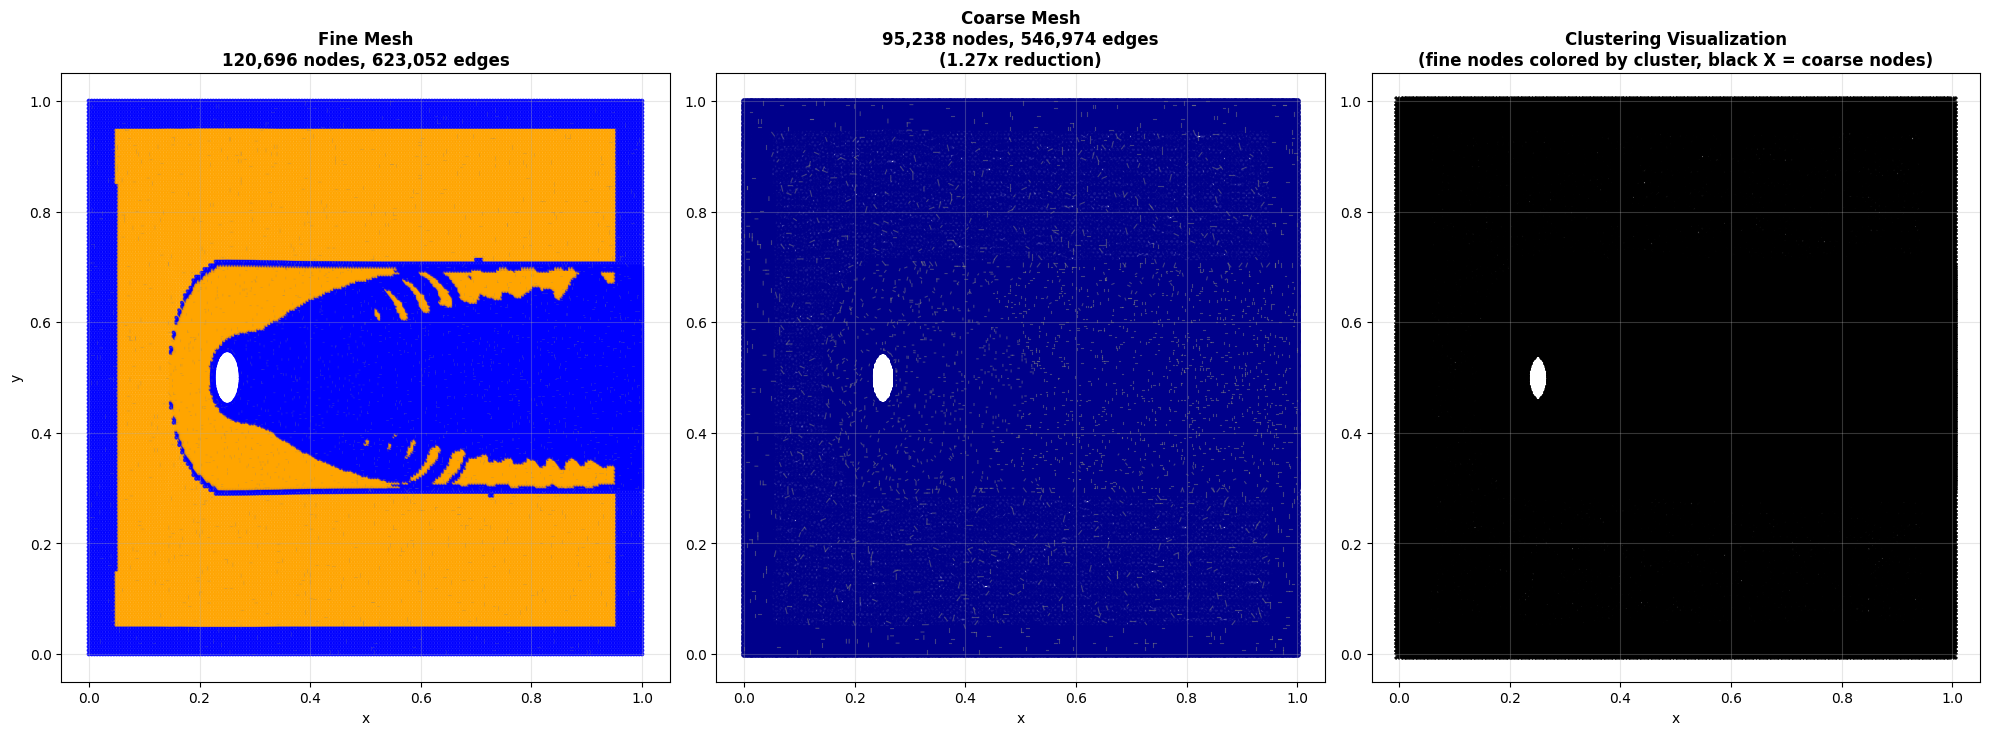


📊 Visualizing physics on 3 timesteps...

   Timestep 0:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t0_vorticity.png


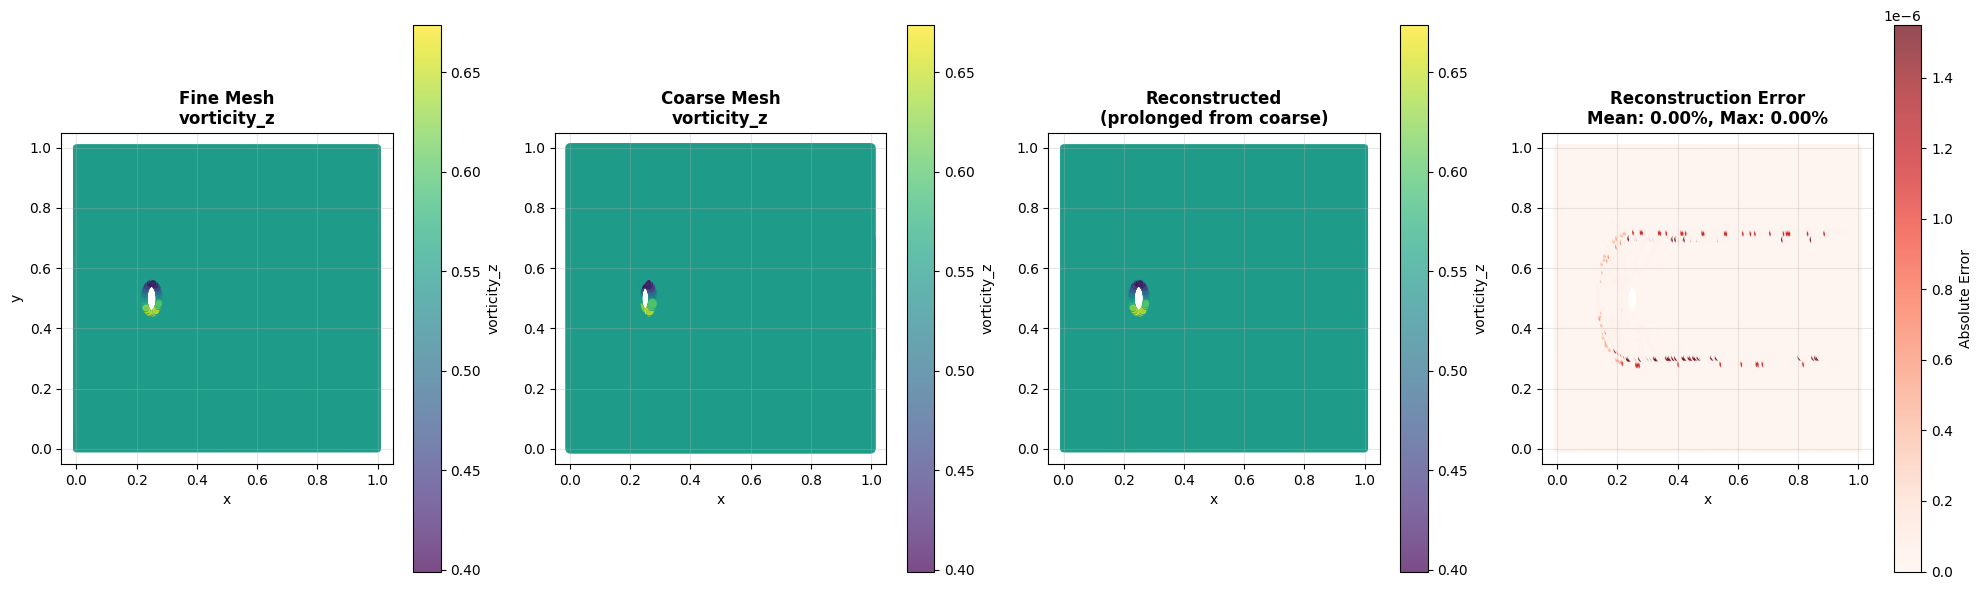


📊 Reconstruction Quality for vorticity_z:
   Mean relative error: 0.00%
   Max relative error: 0.00%
   RMS error: 0.000000
💾 Saved physics comparison to: ./coarsening_analysis/physics_t0_velocity.png


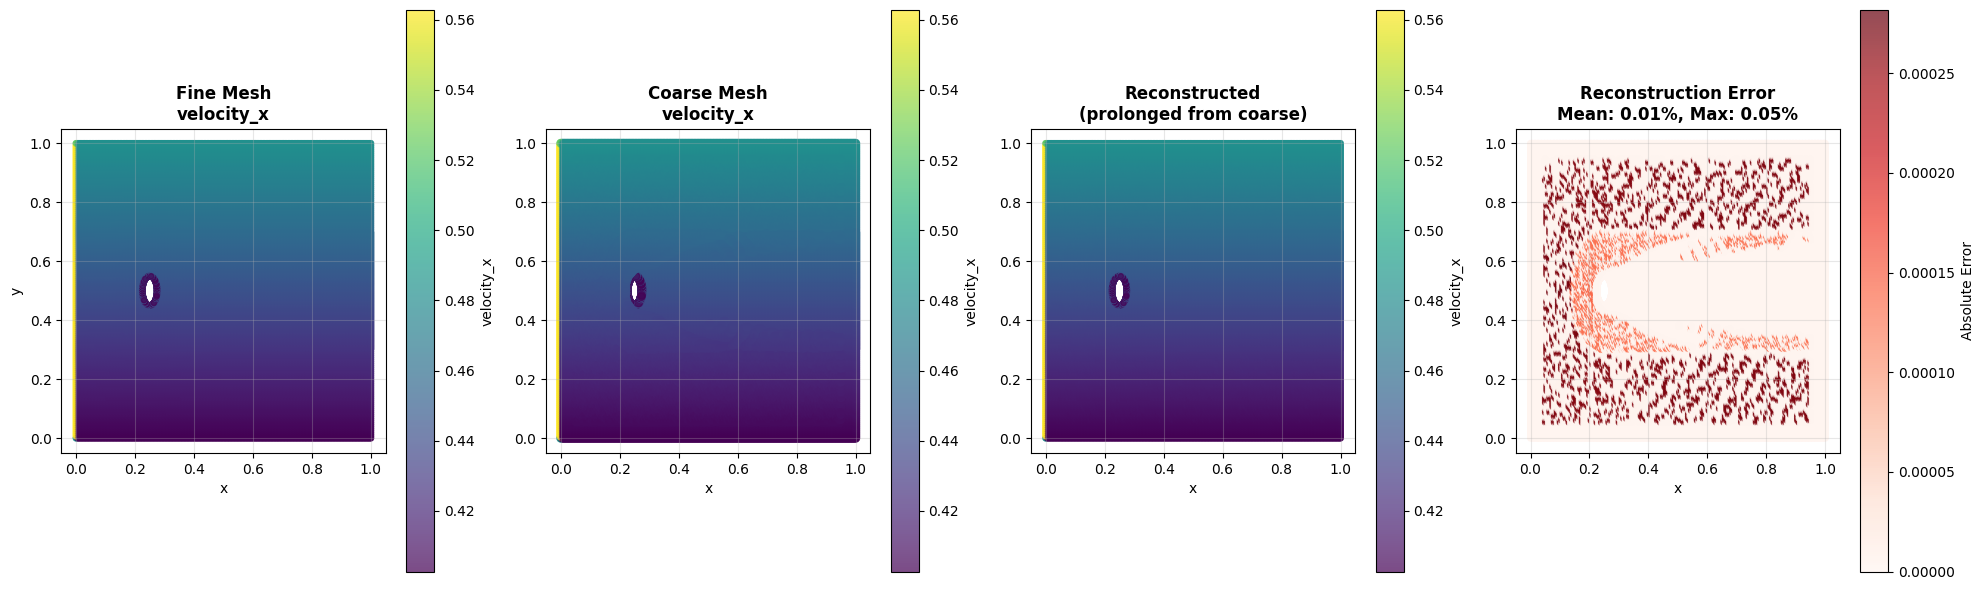


📊 Reconstruction Quality for velocity_x:
   Mean relative error: 0.01%
   Max relative error: 0.05%
   RMS error: 0.000086

   Timestep 100:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t100_vorticity.png


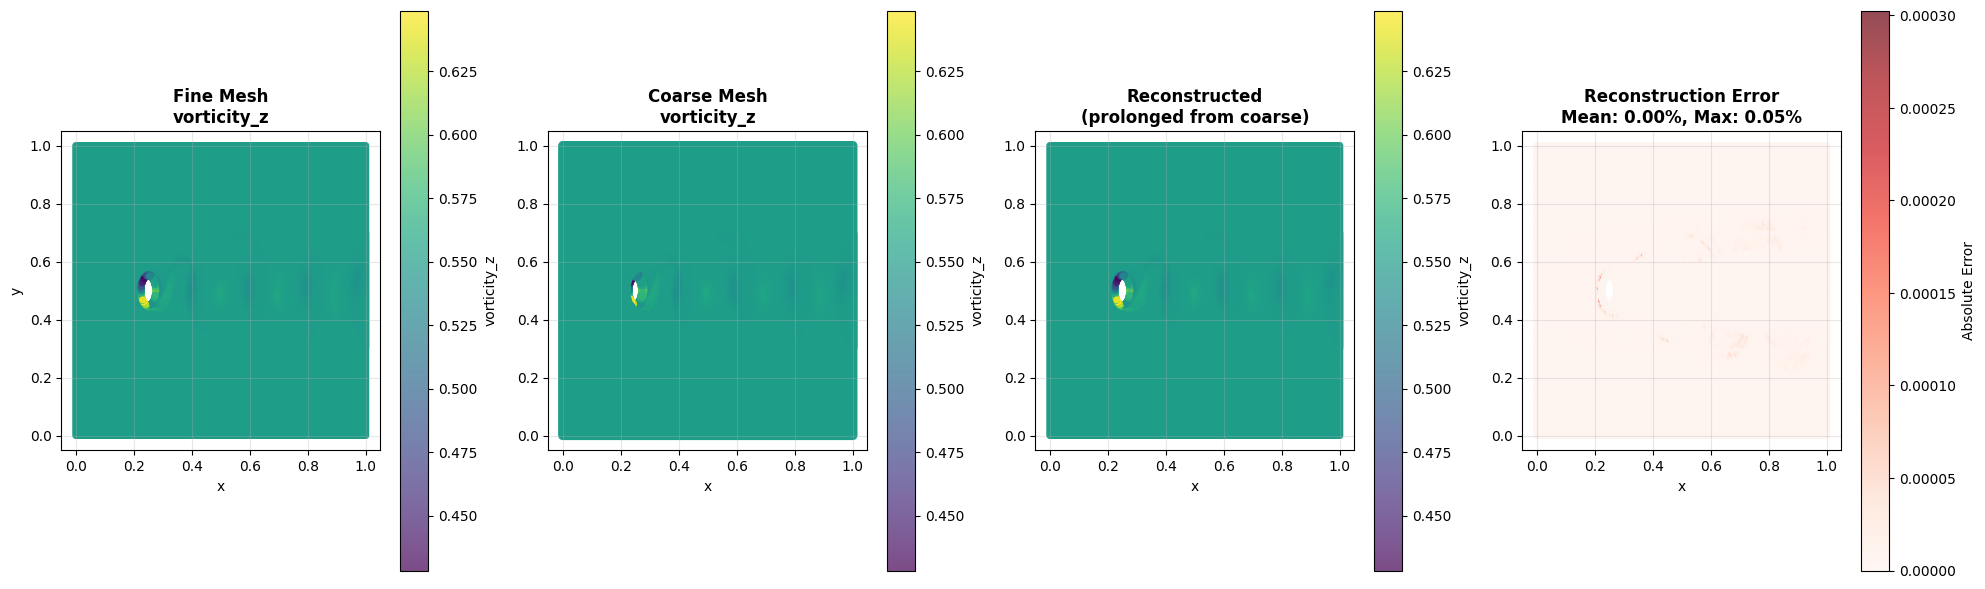


📊 Reconstruction Quality for vorticity_z:
   Mean relative error: 0.00%
   Max relative error: 0.05%
   RMS error: 0.000004
💾 Saved physics comparison to: ./coarsening_analysis/physics_t100_velocity.png


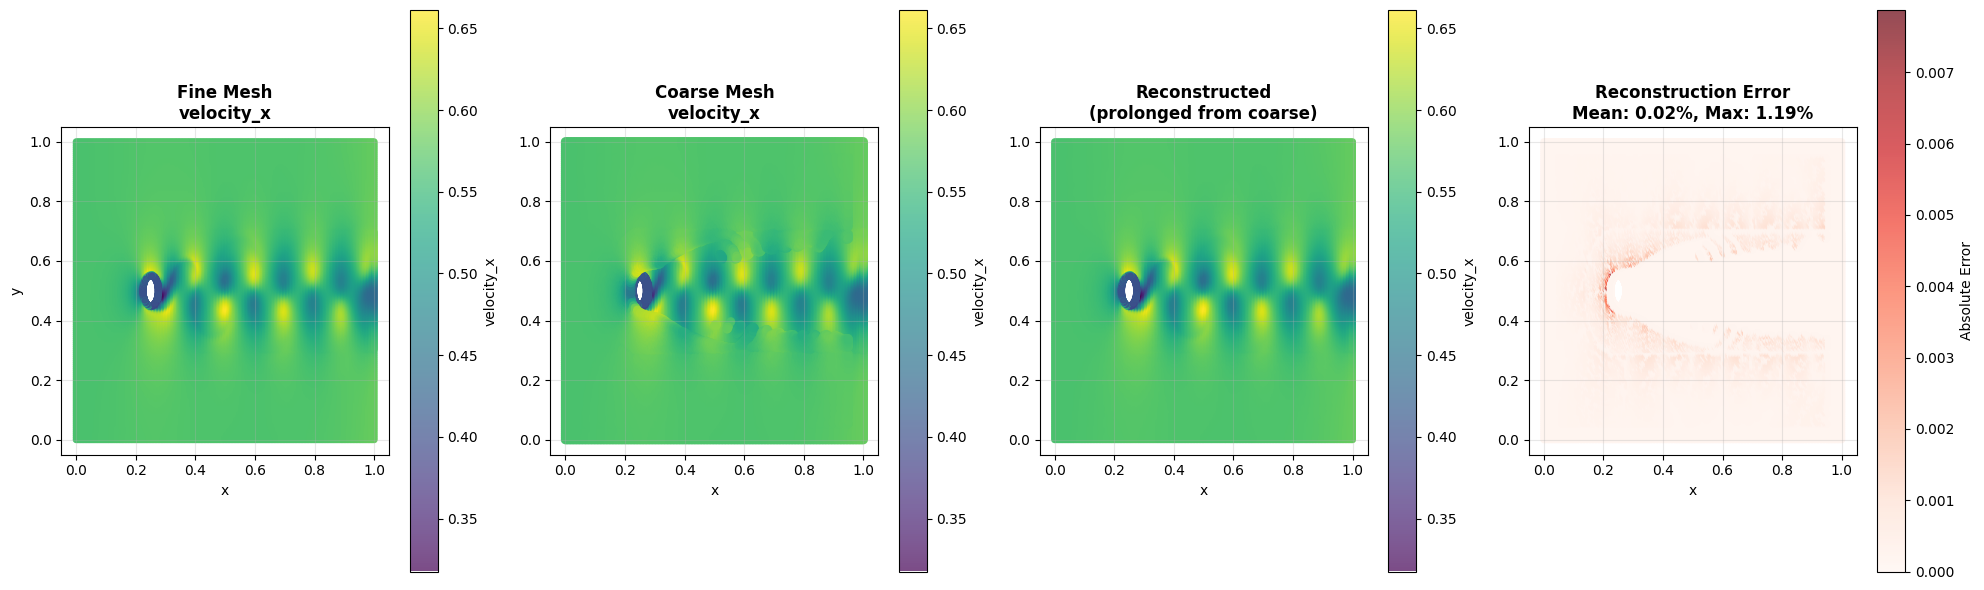


📊 Reconstruction Quality for velocity_x:
   Mean relative error: 0.02%
   Max relative error: 1.19%
   RMS error: 0.000328

   Timestep 200:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t200_vorticity.png


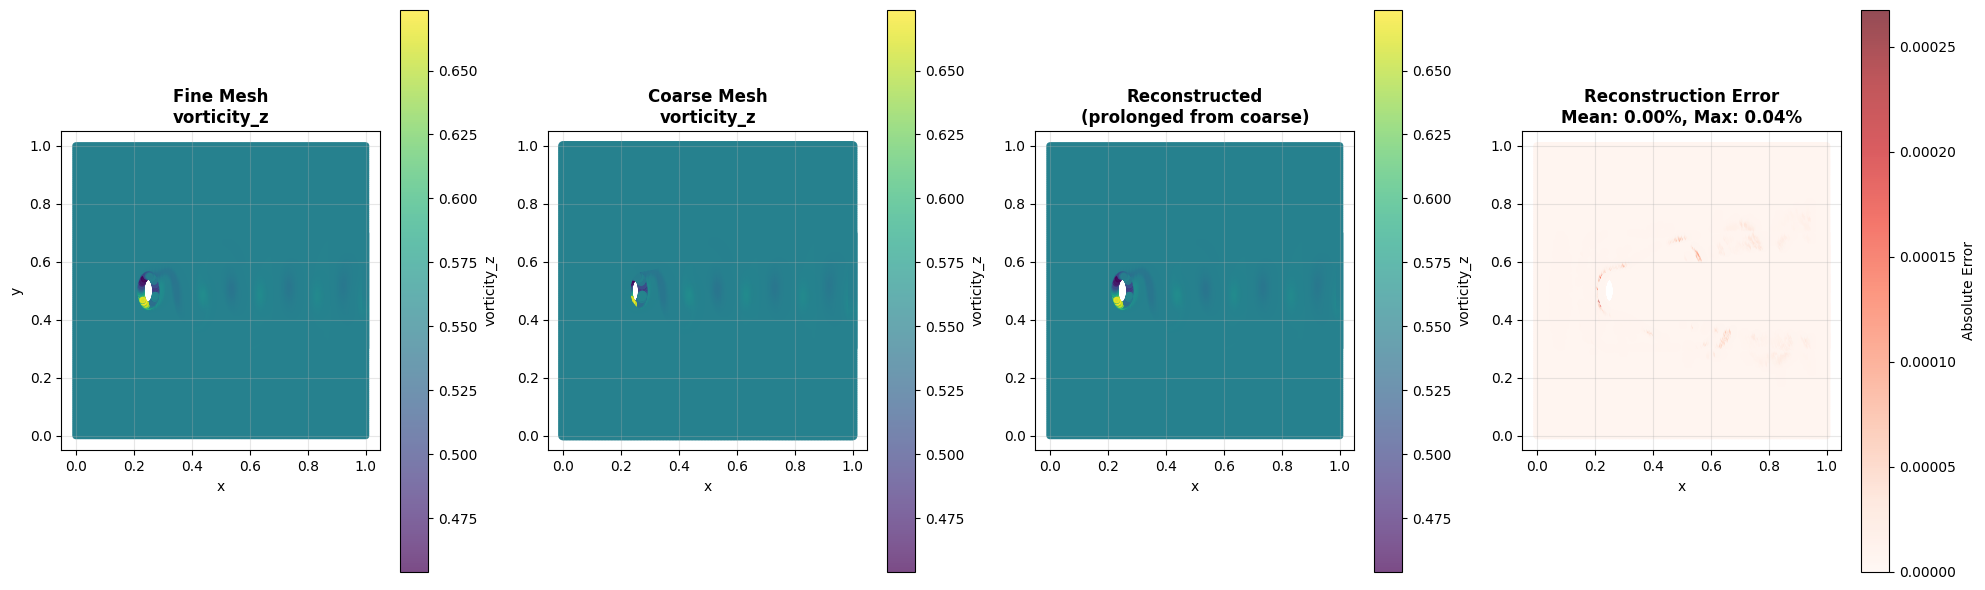


📊 Reconstruction Quality for vorticity_z:
   Mean relative error: 0.00%
   Max relative error: 0.04%
   RMS error: 0.000005
💾 Saved physics comparison to: ./coarsening_analysis/physics_t200_velocity.png


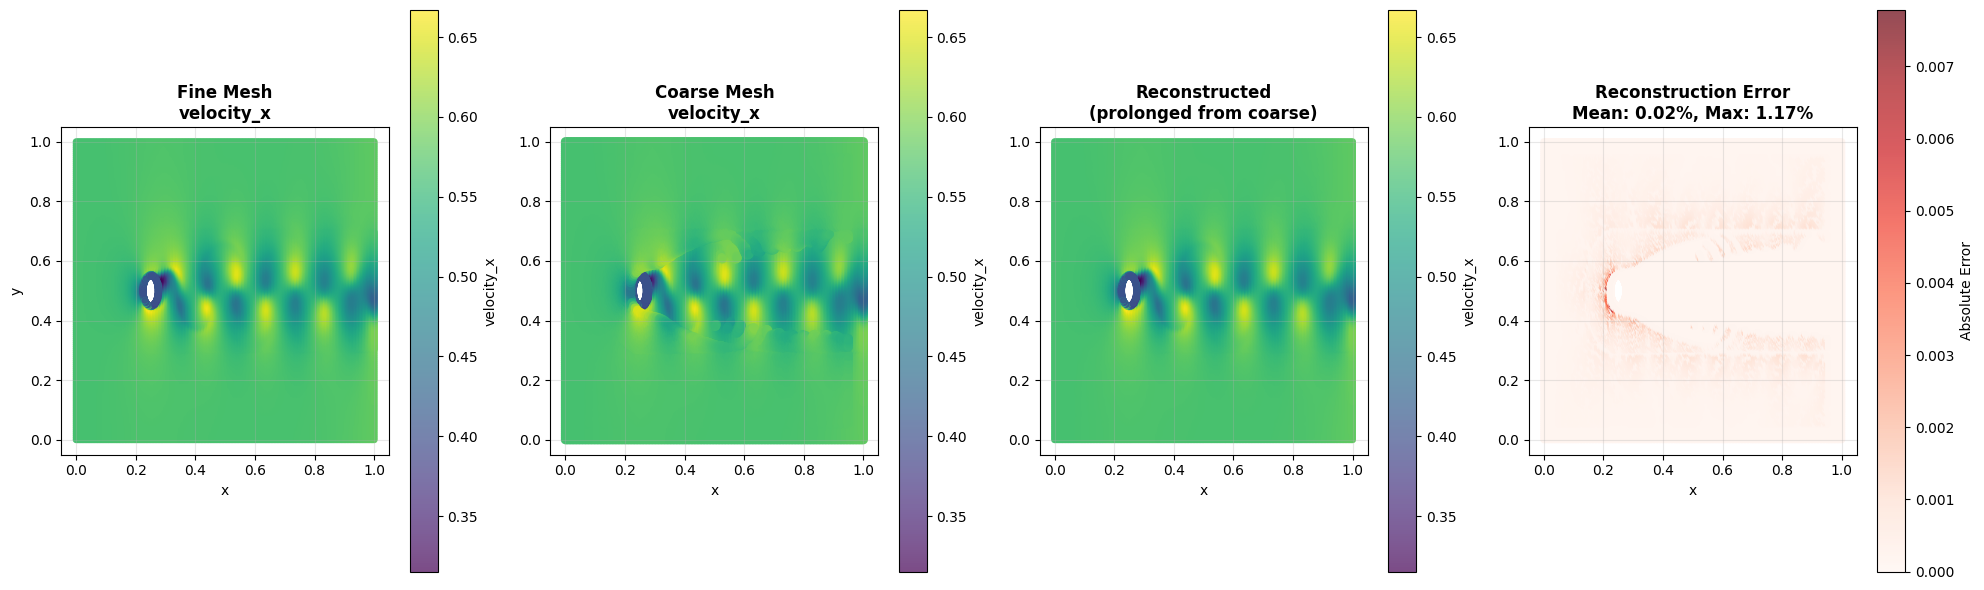


📊 Reconstruction Quality for velocity_x:
   Mean relative error: 0.02%
   Max relative error: 1.17%
   RMS error: 0.000320

📈 SUMMARY
Original mesh: 120,696 nodes
Coarsened mesh: 95,238 nodes
Reduction: 1.27x

Mean reconstruction error (vorticity): 0.00%

Visualization files saved to: ./coarsening_analysis/

✅ Visualization complete!
📂 Check: ./coarsening_analysis/
   - mesh_comparison.png
   - physics_t*_vorticity.png
   - physics_t*_velocity.png


In [5]:
"""
Visualize Coarsened Mesh and Physics Fields

This script:
1. Loads the coarsening analysis results
2. Creates a simple coarsening map (greedy neighbor merging)
3. Shows the coarsened mesh structure
4. Shows physics fields on both fine and coarse meshes for comparison
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pathlib import Path
from collections import defaultdict
from scipy.spatial import cKDTree


class MeshCoarsener:
    """Create and visualize coarsened mesh."""
    
    def __init__(self, data_list, coarsen_mask, keep_mask):
        """
        Args:
            data_list: Original fine mesh data
            coarsen_mask: Boolean array, True = nodes to coarsen
            keep_mask: Boolean array, True = nodes to keep fine
        """
        self.data_list = data_list
        self.reference_data = data_list[0]
        
        self.pos_fine = self.reference_data.pos.numpy()
        self.edge_index_fine = self.reference_data.edge_index.numpy()
        self.n_fine = self.pos_fine.shape[0]
        
        self.coarsen_mask = coarsen_mask
        self.keep_mask = keep_mask
        
        print(f"🔷 Fine mesh: {self.n_fine:,} nodes")
        print(f"   Keeping: {keep_mask.sum():,} nodes")
        print(f"   Coarsening: {coarsen_mask.sum():,} nodes")
    
    def create_simple_coarsening(self):
        """
        Create coarsening map using greedy neighbor merging.
        
        Strategy:
        1. Keep all "keep_mask" nodes as-is
        2. For each "coarsen" node, merge with nearest "coarsen" neighbor
        3. Create assignment matrix S
        
        Returns:
            assignment: (n_fine,) array mapping fine node -> coarse node index
            coarse_pos: (n_coarse, 3) coarse node positions (centroids)
            n_coarse: number of coarse nodes
        """
        print("\n🔨 Creating coarsening map...")
        
        # Initialize assignment: -1 means not assigned yet
        assignment = np.full(self.n_fine, -1, dtype=int)
        coarse_idx = 0
        
        # Step 1: Assign all "keep" nodes to their own coarse nodes
        for node in range(self.n_fine):
            if self.keep_mask[node]:
                assignment[node] = coarse_idx
                coarse_idx += 1
        
        print(f"   Assigned {coarse_idx:,} fine nodes (kept as-is)")
        
        # Step 2: Build adjacency for fast neighbor lookup
        adjacency = defaultdict(list)
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            adjacency[src].append(dst)
            adjacency[dst].append(src)
        
        # Step 3: Greedy pairing of coarsenable nodes
        coarsen_nodes = np.where(self.coarsen_mask)[0]
        assigned_coarsen = set()
        
        for node in coarsen_nodes:
            if node in assigned_coarsen:
                continue  # Already paired
            
            # Find coarsenable neighbors
            neighbors = adjacency[node]
            coarsen_neighbors = [n for n in neighbors 
                                if self.coarsen_mask[n] and n not in assigned_coarsen]
            
            if len(coarsen_neighbors) > 0:
                # Pair with first available neighbor
                partner = coarsen_neighbors[0]
                
                # Both nodes map to same coarse node
                assignment[node] = coarse_idx
                assignment[partner] = coarse_idx
                
                assigned_coarsen.add(node)
                assigned_coarsen.add(partner)
                coarse_idx += 1
            else:
                # No partner available, this node becomes its own coarse node
                assignment[node] = coarse_idx
                assigned_coarsen.add(node)
                coarse_idx += 1
        
        n_coarse = coarse_idx
        
        print(f"   Created {n_coarse:,} coarse nodes")
        print(f"   Reduction: {self.n_fine / n_coarse:.2f}x")
        
        # Step 4: Compute coarse node positions (centroids)
        coarse_pos = np.zeros((n_coarse, 3))
        coarse_counts = np.zeros(n_coarse)
        
        for node in range(self.n_fine):
            c_idx = assignment[node]
            coarse_pos[c_idx] += self.pos_fine[node]
            coarse_counts[c_idx] += 1
        
        coarse_pos /= coarse_counts[:, None]
        
        # Step 5: Create coarse edges (connect if any fine edge crossed boundary)
        print("   Building coarse edges...")
        coarse_edges_set = set()
        
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            c_src = assignment[src]
            c_dst = assignment[dst]
            
            if c_src != c_dst:  # Edge crosses coarse boundary
                # Add both directions for undirected graph
                coarse_edges_set.add((min(c_src, c_dst), max(c_src, c_dst)))
        
        coarse_edges = np.array(list(coarse_edges_set)).T
        
        # Make bidirectional
        coarse_edge_index = np.hstack([coarse_edges, coarse_edges[[1, 0]]])
        
        print(f"   Coarse edges: {coarse_edge_index.shape[1]:,}")
        print(f"   Edge reduction: {self.edge_index_fine.shape[1] / coarse_edge_index.shape[1]:.2f}x")
        
        return assignment, coarse_pos, n_coarse, coarse_edge_index
    
    def aggregate_features(self, timestep_idx, assignment, n_coarse):
        """
        Aggregate fine features to coarse nodes.
        
        Args:
            timestep_idx: Which timestep to aggregate
            assignment: Fine -> coarse mapping
            n_coarse: Number of coarse nodes
        
        Returns:
            x_coarse: (n_coarse, n_features) aggregated features
        """
        data = self.data_list[timestep_idx]
        x_fine = data.x.numpy()
        
        # Aggregate by averaging all fine nodes in each coarse node
        x_coarse = np.zeros((n_coarse, x_fine.shape[1]))
        counts = np.zeros(n_coarse)
        
        for node in range(self.n_fine):
            c_idx = assignment[node]
            x_coarse[c_idx] += x_fine[node]
            counts[c_idx] += 1
        
        x_coarse /= counts[:, None]
        
        return x_coarse
    
    def visualize_mesh_comparison(self, assignment, coarse_pos, coarse_edge_index,
                                  figsize=(20, 10), save_path=None, 
                                  show_edges=True, max_edges=5000):
        """
        Visualize fine vs coarse mesh structure.
        
        Args:
            assignment: Fine -> coarse mapping
            coarse_pos: Coarse node positions
            coarse_edge_index: Coarse edge connectivity
            show_edges: Whether to show mesh edges (can be slow)
            max_edges: Maximum number of edges to display
        """
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        x_fine, y_fine = self.pos_fine[:, 0], self.pos_fine[:, 1]
        x_coarse, y_coarse = coarse_pos[:, 0], coarse_pos[:, 1]
        
        # Panel 1: Fine mesh
        ax = axes[0]
        
        # Show edges (sample if too many)
        if show_edges:
            n_edges_fine = self.edge_index_fine.shape[1]
            if n_edges_fine > max_edges:
                edge_indices = np.random.choice(n_edges_fine, max_edges, replace=False)
            else:
                edge_indices = np.arange(n_edges_fine)
            
            for idx in edge_indices:
                src, dst = self.edge_index_fine[:, idx]
                ax.plot([x_fine[src], x_fine[dst]], 
                       [y_fine[src], y_fine[dst]], 
                       'gray', alpha=0.3, linewidth=0.5)
        
        # Color nodes by whether they'll be coarsened
        colors = np.where(self.keep_mask, 'blue', 'orange')
        ax.scatter(x_fine, y_fine, c=colors, s=5, alpha=0.6)
        
        ax.set_title(f'Fine Mesh\n{self.n_fine:,} nodes, {self.edge_index_fine.shape[1]:,} edges', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 2: Coarse mesh
        ax = axes[1]
        
        # Show coarse edges (sample if too many)
        if show_edges:
            n_edges_coarse = coarse_edge_index.shape[1]
            if n_edges_coarse > max_edges:
                edge_indices = np.random.choice(n_edges_coarse, max_edges, replace=False)
            else:
                edge_indices = np.arange(n_edges_coarse)
            
            for idx in edge_indices:
                src, dst = coarse_edge_index[:, idx]
                ax.plot([x_coarse[src], x_coarse[dst]], 
                       [y_coarse[src], y_coarse[dst]], 
                       'gray', alpha=0.5, linewidth=0.8)
        
        ax.scatter(x_coarse, y_coarse, c='darkblue', s=15, alpha=0.7)
        
        n_coarse = coarse_pos.shape[0]
        reduction = self.n_fine / n_coarse
        ax.set_title(f'Coarse Mesh\n{n_coarse:,} nodes, {coarse_edge_index.shape[1]:,} edges\n({reduction:.2f}x reduction)', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 3: Overlay showing clustering
        ax = axes[2]
        
        # Draw fine nodes colored by which coarse node they belong to
        # Use assignment to color
        n_coarse = coarse_pos.shape[0]
        cmap = plt.cm.tab20
        
        for c_idx in range(min(n_coarse, 1000)):  # Sample for visualization
            fine_in_cluster = (assignment == c_idx)
            if fine_in_cluster.sum() > 0:
                color = cmap(c_idx % 20)
                ax.scatter(x_fine[fine_in_cluster], y_fine[fine_in_cluster], 
                          c=[color], s=10, alpha=0.6)
        
        # Overlay coarse nodes
        ax.scatter(x_coarse, y_coarse, c='black', s=40, alpha=0.8, 
                  marker='x', linewidths=2)
        
        ax.set_title('Clustering Visualization\n(fine nodes colored by cluster, black X = coarse nodes)', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Saved mesh comparison to: {save_path}")
        
        plt.show()
    
    def visualize_physics_comparison(self, timestep_idx, assignment, coarse_pos, 
                                    x_coarse, feature_name='vorticity_z',
                                    figsize=(20, 6), save_path=None):
        """
        Compare physics field on fine vs coarse mesh.
        
        Args:
            timestep_idx: Which timestep to visualize
            assignment: Fine -> coarse mapping
            coarse_pos: Coarse node positions
            x_coarse: Coarse features
            feature_name: Which feature to plot
        """
        # Feature mapping
        feature_map = {
            'pressure': 3,
            'velocity_x': 4,
            'velocity_y': 5,
            'velocity_z': 6,
            'vorticity_x': 7,
            'vorticity_y': 8,
            'vorticity_z': 9
        }
        
        feat_idx = feature_map.get(feature_name, 9)
        
        # Get fine data
        data = self.data_list[timestep_idx]
        x_fine = data.x.numpy()
        pos_fine = self.pos_fine
        
        # Get values
        values_fine = x_fine[:, feat_idx]
        values_coarse = x_coarse[:, feat_idx]
        
        # Reconstruct: prolong coarse back to fine mesh
        values_reconstructed = values_coarse[assignment]
        
        # Compute reconstruction error
        error = np.abs(values_fine - values_reconstructed)
        rel_error = error / (np.abs(values_fine).max() + 1e-10)
        mean_rel_error = rel_error.mean()
        max_rel_error = rel_error.max()
        
        # Plot
        fig, axes = plt.subplots(1, 4, figsize=figsize)
        
        x_fine, y_fine = pos_fine[:, 0], pos_fine[:, 1]
        x_coarse, y_coarse = coarse_pos[:, 0], coarse_pos[:, 1]
        
        # Shared colorbar limits
        vmin = min(values_fine.min(), values_coarse.min())
        vmax = max(values_fine.max(), values_coarse.max())
        
        # Panel 1: Fine mesh field
        ax = axes[0]
        scatter = ax.scatter(x_fine, y_fine, c=values_fine, cmap='viridis',
                           s=15, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Fine Mesh\n{feature_name}', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 2: Coarse mesh field
        ax = axes[1]
        scatter = ax.scatter(x_coarse, y_coarse, c=values_coarse, cmap='viridis',
                           s=30, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Coarse Mesh\n{feature_name}', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 3: Reconstructed (prolonged) field
        ax = axes[2]
        scatter = ax.scatter(x_fine, y_fine, c=values_reconstructed, cmap='viridis',
                           s=15, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Reconstructed\n(prolonged from coarse)', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 4: Absolute error
        ax = axes[3]
        scatter = ax.scatter(x_fine, y_fine, c=error, cmap='Reds',
                           s=15, alpha=0.7)
        plt.colorbar(scatter, ax=ax, label='Absolute Error')
        ax.set_title(f'Reconstruction Error\nMean: {mean_rel_error:.2%}, Max: {max_rel_error:.2%}', 
                    fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Saved physics comparison to: {save_path}")
        
        plt.show()
        
        print(f"\n📊 Reconstruction Quality for {feature_name}:")
        print(f"   Mean relative error: {mean_rel_error:.2%}")
        print(f"   Max relative error: {max_rel_error:.2%}")
        print(f"   RMS error: {np.sqrt(np.mean(error**2)):.6f}")
        
        return mean_rel_error


def run_coarsened_visualization(data_file, coarsening_results_file, 
                                timesteps_to_show=[0, 50, 100],
                                output_dir="./coarsening_analysis"):
    """
    Complete visualization of coarsened mesh and physics.
    
    Args:
        data_file: Path to original .pt file
        coarsening_results_file: Path to coarsening_results.npz from analysis
        timesteps_to_show: List of timestep indices to visualize
        output_dir: Where to save outputs
    """
    print("="*70)
    print("🔬 COARSENED MESH VISUALIZATION")
    print("="*70)
    
    # Load data
    print("\n⏳ Loading data...")
    data_list = torch.load(data_file, weights_only=False)
    print(f"✅ Loaded {len(data_list)} timesteps")
    
    # Load coarsening results
    print("⏳ Loading coarsening analysis...")
    results = np.load(coarsening_results_file)
    coarsen_mask = results['coarsen_mask']
    keep_mask = results['keep_mask']
    print(f"✅ Loaded coarsening decisions")
    
    # Create coarsener
    coarsener = MeshCoarsener(data_list, coarsen_mask, keep_mask)
    
    # Create coarsening map
    assignment, coarse_pos, n_coarse, coarse_edge_index = coarsener.create_simple_coarsening()
    
    # Visualize mesh structure
    print("\n📊 Visualizing mesh structure...")
    coarsener.visualize_mesh_comparison(
        assignment, coarse_pos, coarse_edge_index,
        save_path=f"{output_dir}/mesh_comparison.png",
        show_edges=True,
        max_edges=3000
    )
    
    # Visualize physics on multiple timesteps
    print(f"\n📊 Visualizing physics on {len(timesteps_to_show)} timesteps...")
    
    errors = []
    for ts_idx in timesteps_to_show:
        if ts_idx >= len(data_list):
            print(f"⚠️  Skipping timestep {ts_idx} (out of range)")
            continue
        
        print(f"\n   Timestep {ts_idx}:")
        
        # Aggregate features
        x_coarse = coarsener.aggregate_features(ts_idx, assignment, n_coarse)
        
        # Visualize vorticity_z
        error = coarsener.visualize_physics_comparison(
            ts_idx, assignment, coarse_pos, x_coarse,
            feature_name='vorticity_z',
            save_path=f"{output_dir}/physics_t{ts_idx}_vorticity.png"
        )
        errors.append(error)
        
        # Visualize velocity_x
        error = coarsener.visualize_physics_comparison(
            ts_idx, assignment, coarse_pos, x_coarse,
            feature_name='velocity_x',
            save_path=f"{output_dir}/physics_t{ts_idx}_velocity.png"
        )
    
    print("\n" + "="*70)
    print("📈 SUMMARY")
    print("="*70)
    print(f"Original mesh: {coarsener.n_fine:,} nodes")
    print(f"Coarsened mesh: {n_coarse:,} nodes")
    print(f"Reduction: {coarsener.n_fine / n_coarse:.2f}x")
    print(f"\nMean reconstruction error (vorticity): {np.mean(errors):.2%}")
    print(f"\nVisualization files saved to: {output_dir}/")
    print("="*70)


if __name__ == "__main__":
    
    # ===== CONFIGURATION =====
    
    DATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized/train/Re_550_normalized.pt"
    
    COARSENING_RESULTS = "./coarsening_analysis/coarsening_results.npz"
    
    # Which timesteps to visualize
    TIMESTEPS = [0, 100, 200]  # First, middle, later timesteps
    
    OUTPUT_DIR = "./coarsening_analysis"
    
    # =========================
    
    try:
        run_coarsened_visualization(
            data_file=DATA_FILE,
            coarsening_results_file=COARSENING_RESULTS,
            timesteps_to_show=TIMESTEPS,
            output_dir=OUTPUT_DIR
        )
        
        print("\n✅ Visualization complete!")
        print(f"📂 Check: {OUTPUT_DIR}/")
        print("   - mesh_comparison.png")
        print("   - physics_t*_vorticity.png")
        print("   - physics_t*_velocity.png")
        
    except FileNotFoundError as e:
        print(f"\n❌ ERROR: {e}")
        print("\nMake sure you've run the coarsening analysis first:")
        print("  python karman_coarsening_complete.py")
        
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

🔬 COARSENED MESH VISUALIZATION

⏳ Loading data...
✅ Loaded 400 timesteps
⏳ Loading coarsening analysis...
✅ Loaded coarsening decisions
🔷 Fine mesh: 120,696 nodes
   Keeping: 69,110 nodes
   Coarsening: 51,586 nodes

⚙️  Adaptive clustering parameters:
   Cluster size range: 2-100 nodes
   High importance → 2 nodes (preserve detail)
   Low importance → 100 nodes (aggressive coarsening)
   Similarity weight: 0.3

🔨 Creating adaptive cluster-based coarsening...
   Cluster size range: 2-100 nodes
   Assigned 69,110 fine nodes (kept as-is)
   Target cluster sizes: min=100, max=100, mean=100.00
   Created 69,801 coarse nodes
   Achieved cluster sizes: min=1, max=100, mean=74.65
   Reduction: 1.73x
   Cluster size distribution:
      1 nodes: 13 clusters (1.9%)
      2 nodes: 74 clusters (10.7%)
      3 nodes: 1 clusters (0.1%)
      4 nodes: 23 clusters (3.3%)
      5 nodes: 1 clusters (0.1%)
      6 nodes: 14 clusters (2.0%)
      8 nodes: 10 clusters (1.4%)
      9 nodes: 1 clusters (0.1%

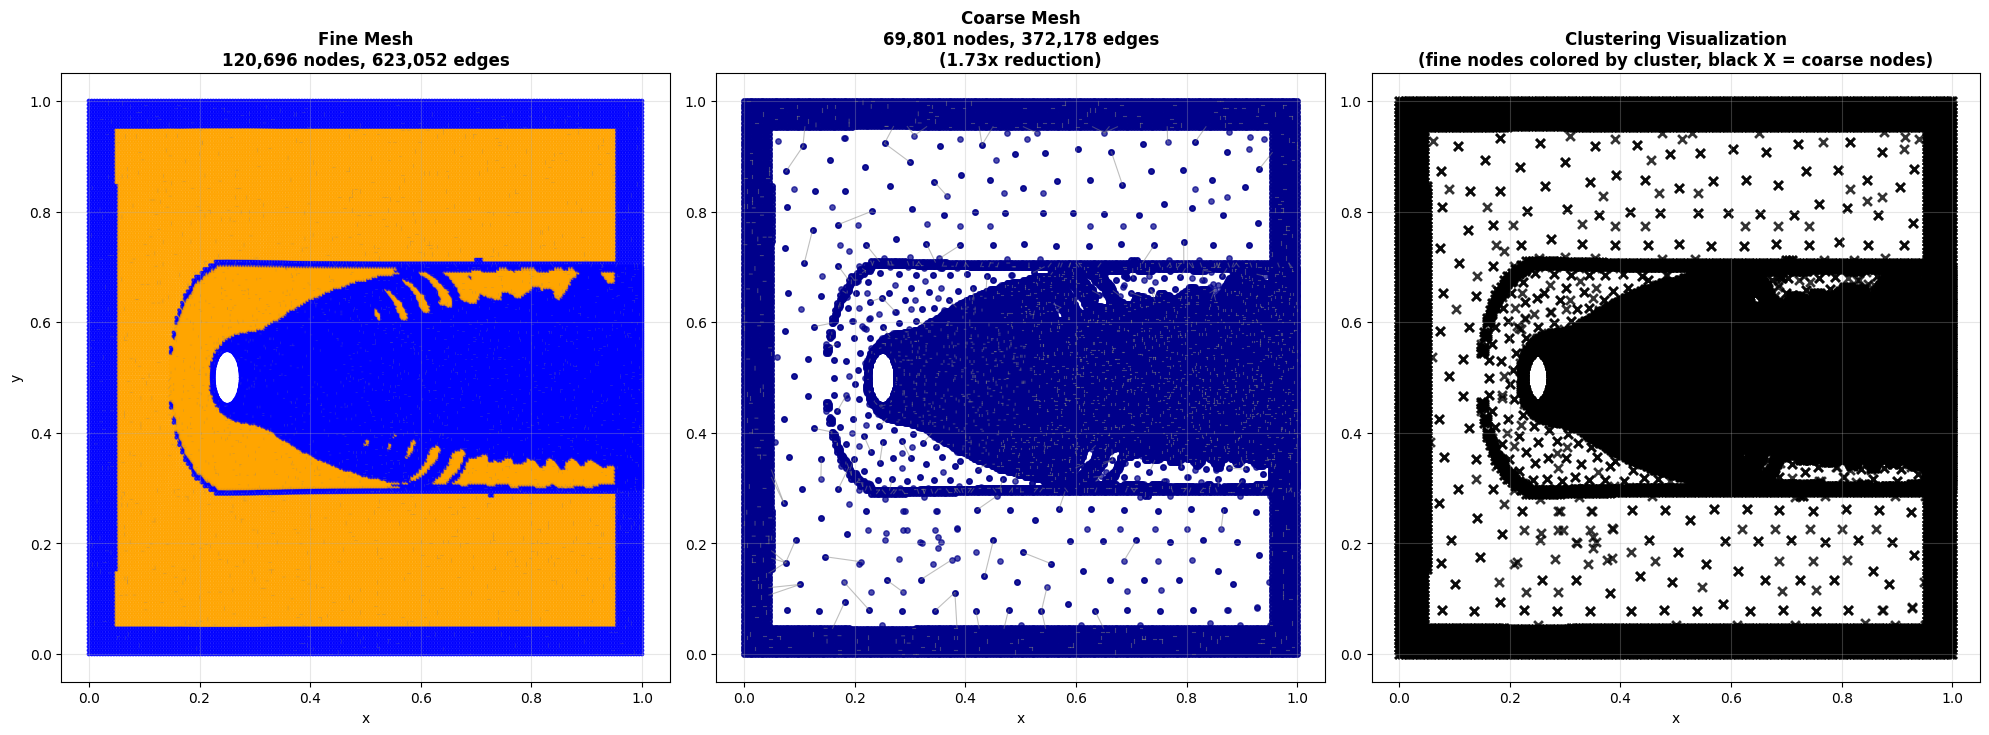


📊 Visualizing physics on 3 timesteps...

   Timestep 0:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t0_vorticity.png


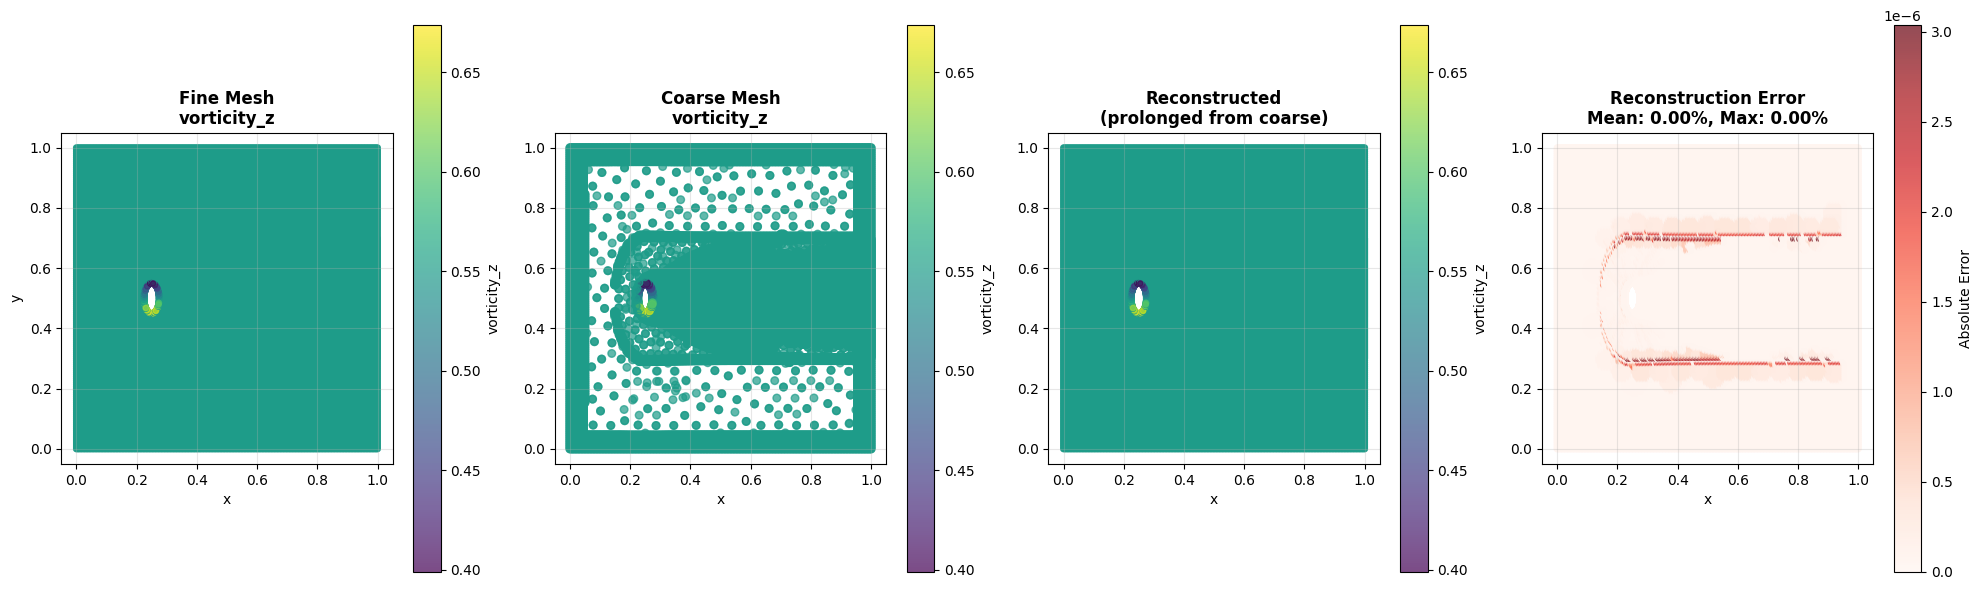


📊 Reconstruction Quality for vorticity_z:
   Mean relative error: 0.00%
   Max relative error: 0.00%
   RMS error: 0.000000
💾 Saved physics comparison to: ./coarsening_analysis/physics_t0_velocity.png


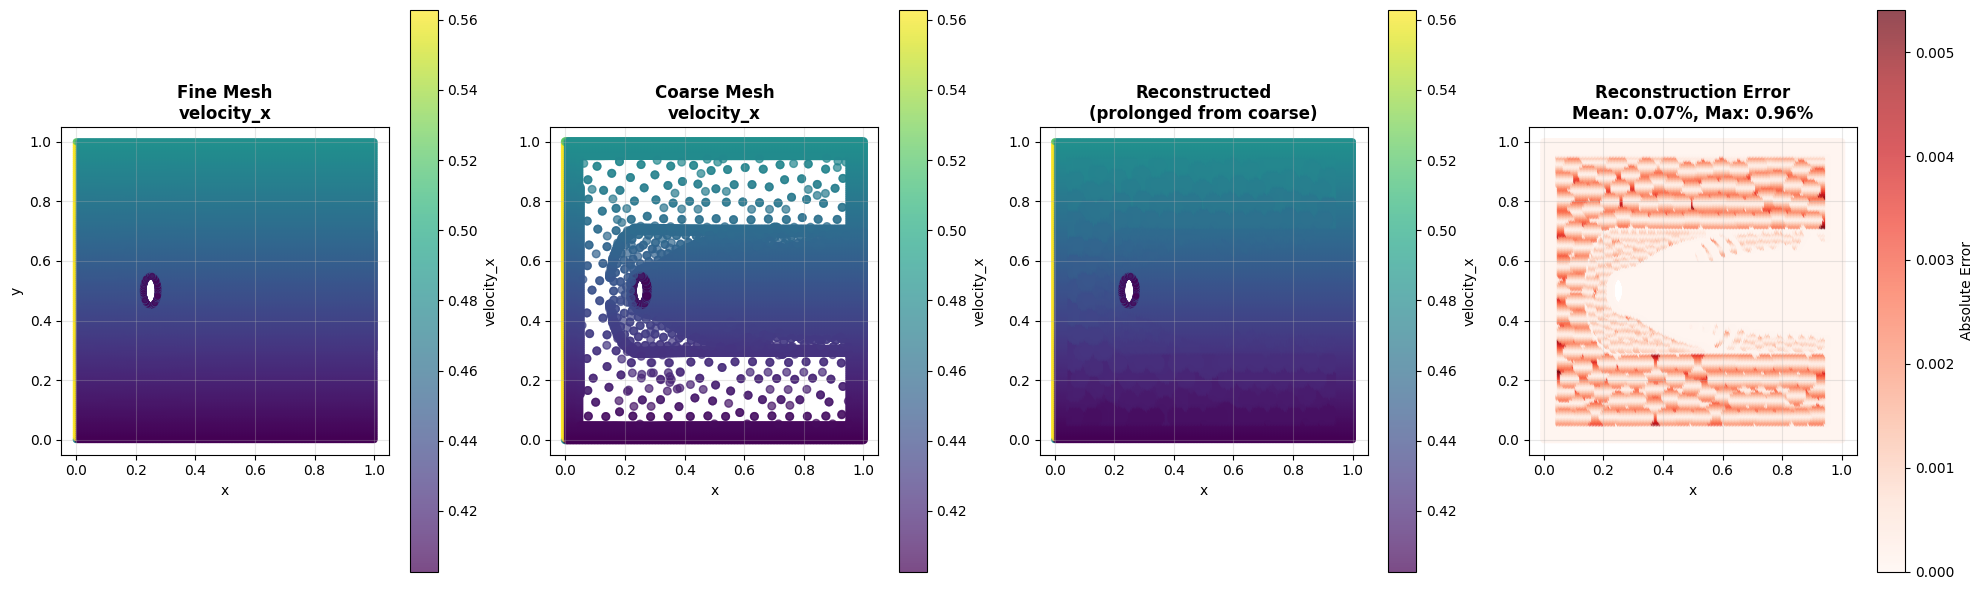


📊 Reconstruction Quality for velocity_x:
   Mean relative error: 0.07%
   Max relative error: 0.96%
   RMS error: 0.000757

   Timestep 100:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t100_vorticity.png


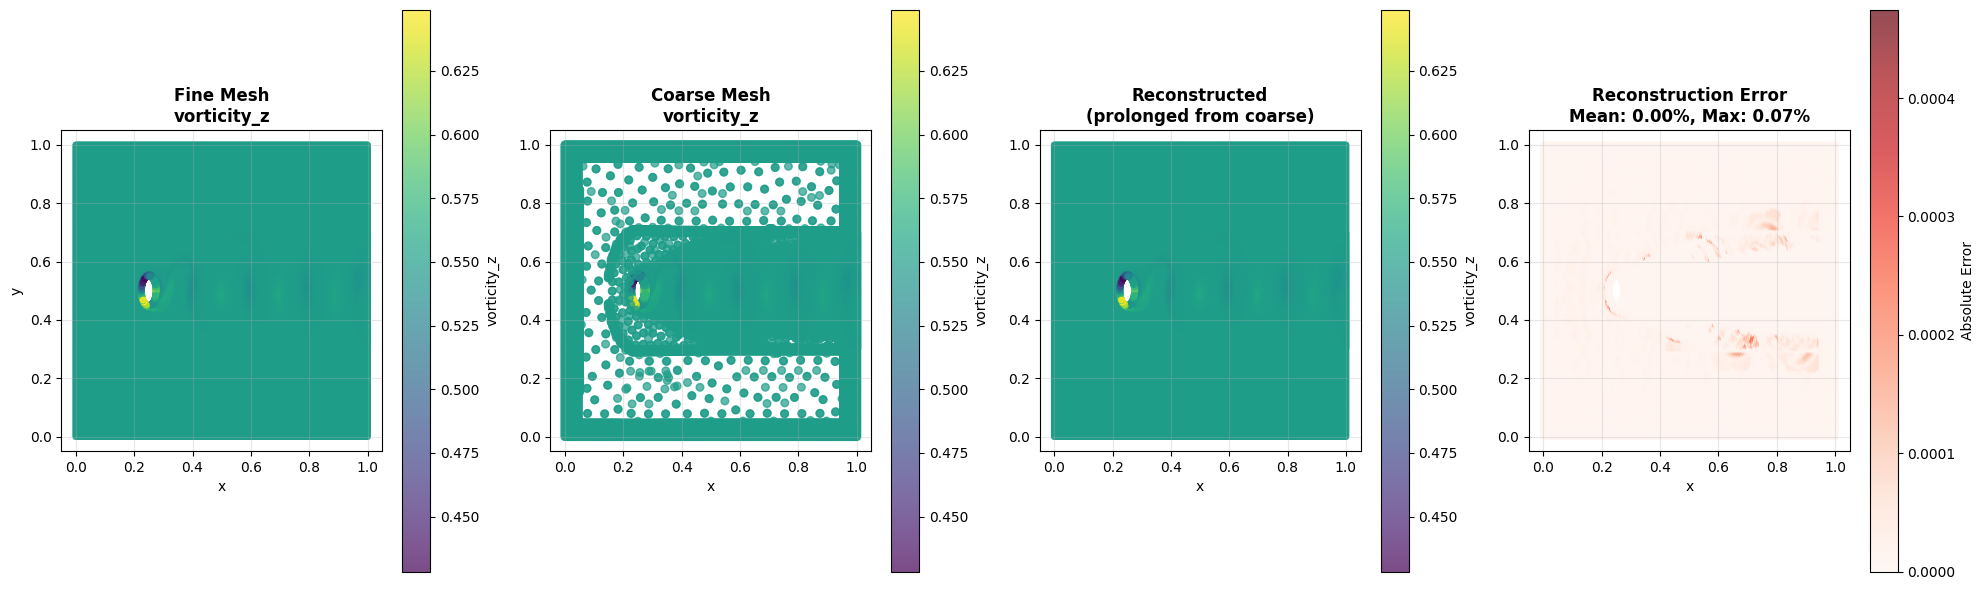


📊 Reconstruction Quality for vorticity_z:
   Mean relative error: 0.00%
   Max relative error: 0.07%
   RMS error: 0.000015
💾 Saved physics comparison to: ./coarsening_analysis/physics_t100_velocity.png


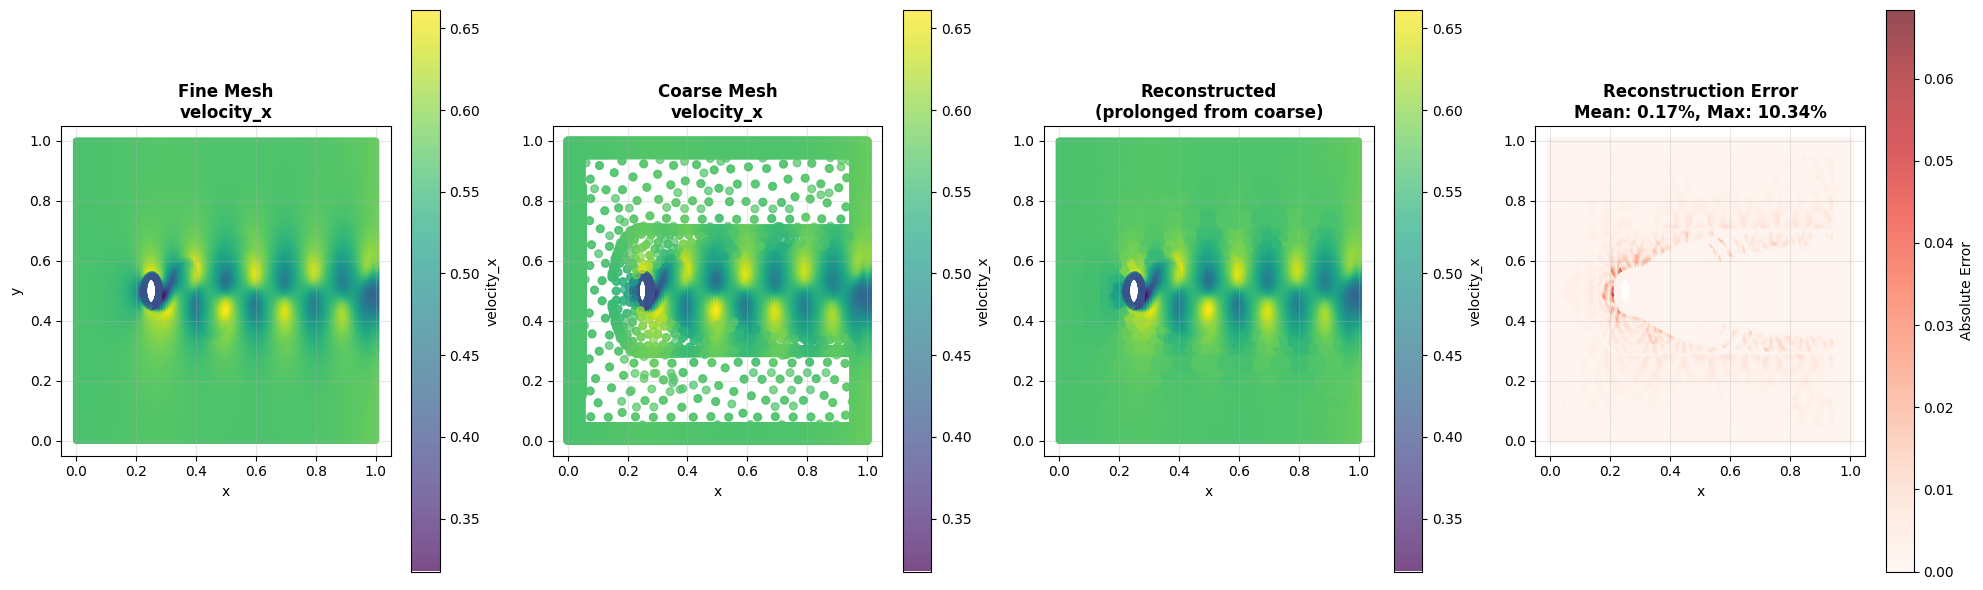


📊 Reconstruction Quality for velocity_x:
   Mean relative error: 0.17%
   Max relative error: 10.34%
   RMS error: 0.003088

   Timestep 200:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t200_vorticity.png


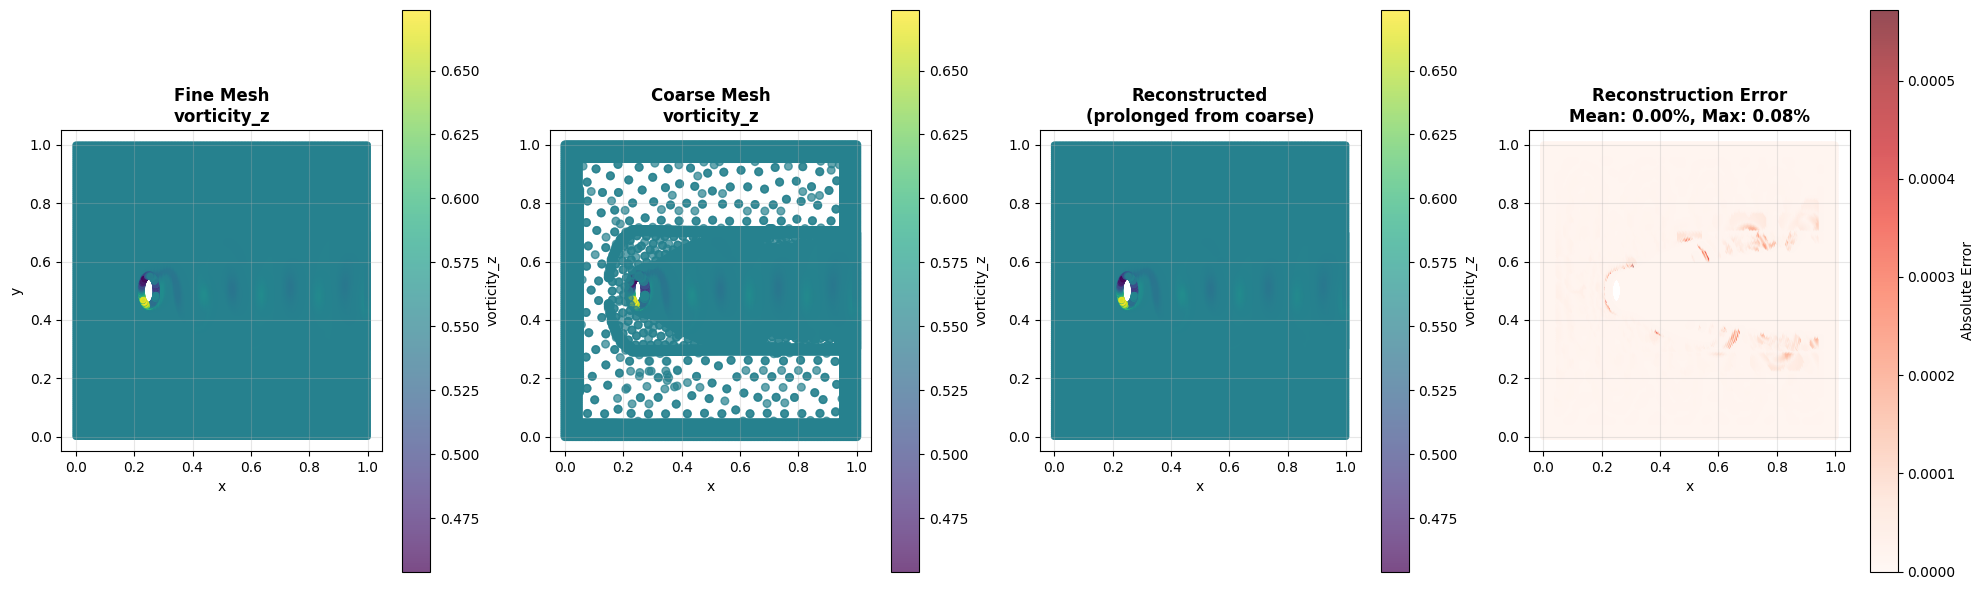


📊 Reconstruction Quality for vorticity_z:
   Mean relative error: 0.00%
   Max relative error: 0.08%
   RMS error: 0.000018
💾 Saved physics comparison to: ./coarsening_analysis/physics_t200_velocity.png


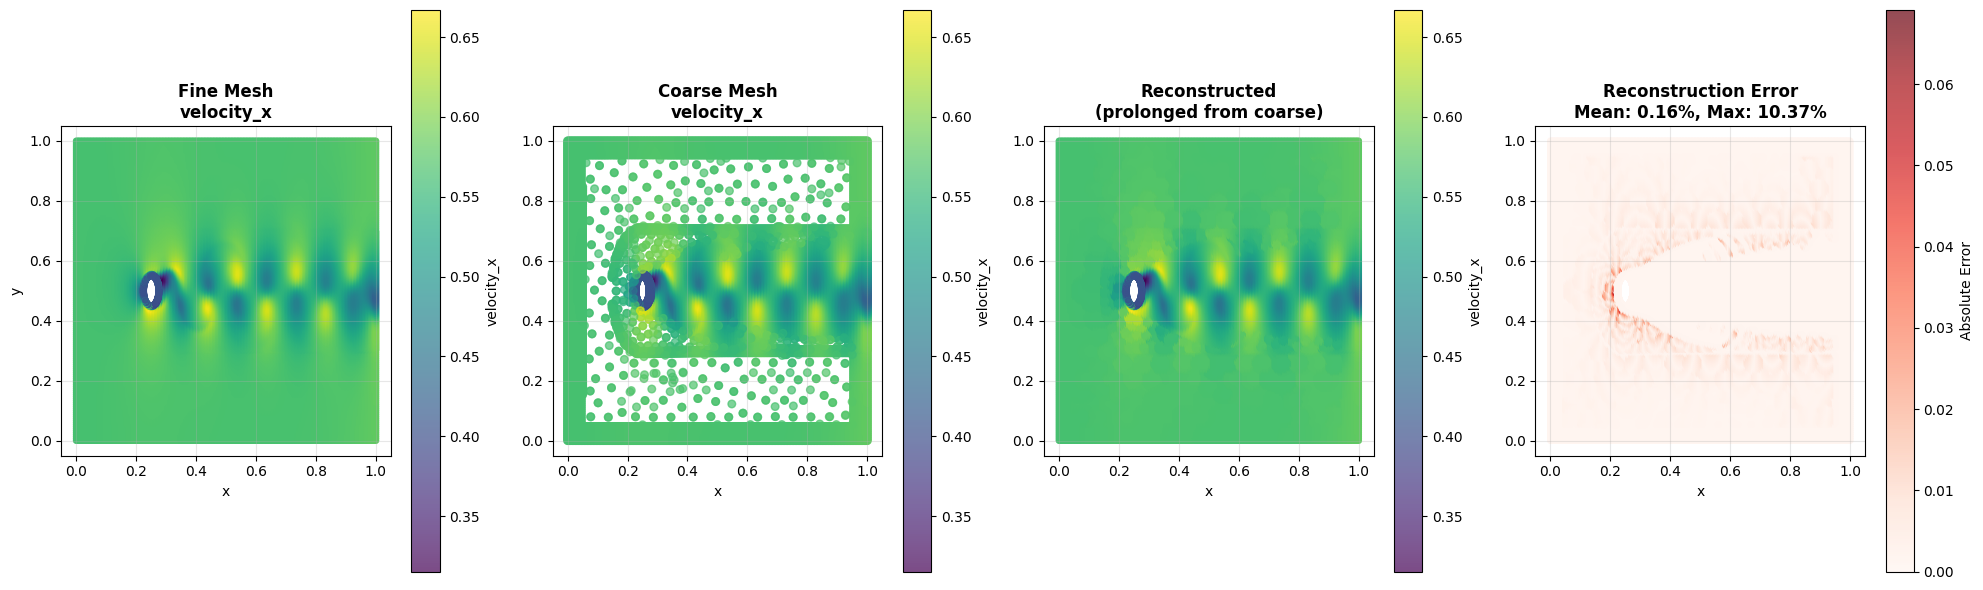


📊 Reconstruction Quality for velocity_x:
   Mean relative error: 0.16%
   Max relative error: 10.37%
   RMS error: 0.003029

📈 SUMMARY
Original mesh: 120,696 nodes
Coarsened mesh: 69,801 nodes
Reduction: 1.73x

Mean reconstruction error (vorticity): 0.00%

Visualization files saved to: ./coarsening_analysis/

✅ Visualization complete!
📂 Check: ./coarsening_analysis/
   - mesh_comparison.png
   - physics_t*_vorticity.png
   - physics_t*_velocity.png


In [4]:
"""
Visualize Coarsened Mesh and Physics Fields

This script:
1. Loads the coarsening analysis results
2. Creates a simple coarsening map (greedy neighbor merging)
3. Shows the coarsened mesh structure
4. Shows physics fields on both fine and coarse meshes for comparison
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pathlib import Path
from collections import defaultdict
from scipy.spatial import cKDTree


class MeshCoarsener:
    """Create and visualize coarsened mesh."""
    
    def __init__(self, data_list, coarsen_mask, keep_mask):
        """
        Args:
            data_list: Original fine mesh data
            coarsen_mask: Boolean array, True = nodes to coarsen
            keep_mask: Boolean array, True = nodes to keep fine
        """
        self.data_list = data_list
        self.reference_data = data_list[0]
        
        self.pos_fine = self.reference_data.pos.numpy()
        self.edge_index_fine = self.reference_data.edge_index.numpy()
        self.n_fine = self.pos_fine.shape[0]
        
        self.coarsen_mask = coarsen_mask
        self.keep_mask = keep_mask
        
        print(f"🔷 Fine mesh: {self.n_fine:,} nodes")
        print(f"   Keeping: {keep_mask.sum():,} nodes")
        print(f"   Coarsening: {coarsen_mask.sum():,} nodes")
    
    def create_simple_coarsening(self):
        """
        Create coarsening map using greedy neighbor merging.
        (DEPRECATED - use create_cluster_coarsening for better results)
        """
        # Keep for compatibility but recommend cluster-based approach
        return self.create_cluster_coarsening(cluster_size=3)
    
    def create_adaptive_coarsening(self, min_cluster_size=2, max_cluster_size=6, 
                                   similarity_weight=0.3, importance_scores=None):
        """
        Create coarsening with adaptive cluster sizes based on local importance.
        
        High importance regions → smaller clusters (preserve detail)
        Low importance regions → larger clusters (aggressive coarsening)
        
        Args:
            min_cluster_size: Minimum nodes per cluster (for high importance)
            max_cluster_size: Maximum nodes per cluster (for low importance)
            similarity_weight: Weight for feature similarity vs spatial (0-1)
            importance_scores: (n_fine,) importance values (if None, computed from features)
        
        Returns:
            assignment: (n_fine,) array mapping fine node -> coarse node index
            coarse_pos: (n_coarse, 3) coarse node positions
            n_coarse: number of coarse nodes
            coarse_edge_index: (2, n_edges) coarse connectivity
        """
        print(f"\n🔨 Creating adaptive cluster-based coarsening...")
        print(f"   Cluster size range: {min_cluster_size}-{max_cluster_size} nodes")
        
        # Initialize assignment
        assignment = np.full(self.n_fine, -1, dtype=int)
        coarse_idx = 0
        
        # Step 1: Assign all "keep" nodes to their own coarse nodes
        for node in range(self.n_fine):
            if self.keep_mask[node]:
                assignment[node] = coarse_idx
                coarse_idx += 1
        
        print(f"   Assigned {coarse_idx:,} fine nodes (kept as-is)")
        
        # Step 2: Compute or use provided importance scores
        if importance_scores is None:
            # Compute simple importance from feature variance
            x_fine = self.reference_data.x.numpy()
            importance_scores = np.var(x_fine[:, 3:], axis=1)  # Variance of physics features
            importance_scores = (importance_scores - importance_scores.min()) / \
                               (importance_scores.max() - importance_scores.min() + 1e-10)
        
        # Step 3: Determine target cluster size for each coarsenable node
        # High importance → min_cluster_size, Low importance → max_cluster_size
        target_cluster_sizes = np.zeros(self.n_fine, dtype=int)
        for node in range(self.n_fine):
            if self.coarsen_mask[node]:
                # Linear interpolation based on importance
                # importance=1.0 → min_cluster, importance=0.0 → max_cluster
                target_size = min_cluster_size + \
                             (1.0 - importance_scores[node]) * (max_cluster_size - min_cluster_size)
                target_cluster_sizes[node] = int(np.round(target_size))
        
        print(f"   Target cluster sizes: min={target_cluster_sizes[self.coarsen_mask].min()}, "
              f"max={target_cluster_sizes[self.coarsen_mask].max()}, "
              f"mean={target_cluster_sizes[self.coarsen_mask].mean():.2f}")
        
        # Step 4: Build adjacency
        adjacency = defaultdict(list)
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            adjacency[src].append(dst)
            adjacency[dst].append(src)
        
        # Step 5: Get normalized features for similarity
        x_fine = self.reference_data.x.numpy()
        x_norm = (x_fine - x_fine.min(axis=0)) / (x_fine.max(axis=0) - x_fine.min(axis=0) + 1e-10)
        
        # Step 6: Cluster coarsenable nodes with adaptive sizes
        # Sort by importance (process high importance first to preserve detail)
        coarsen_nodes = np.where(self.coarsen_mask)[0]
        importance_order = np.argsort(-importance_scores[coarsen_nodes])  # Descending
        coarsen_nodes_sorted = coarsen_nodes[importance_order]
        
        assigned_coarsen = set()
        cluster_sizes_achieved = []
        
        for seed_node in coarsen_nodes_sorted:
            if seed_node in assigned_coarsen:
                continue
            
            # Get adaptive target size for this seed
            target_size = target_cluster_sizes[seed_node]
            
            # Start cluster
            cluster = [seed_node]
            assigned_coarsen.add(seed_node)
            
            # Grow cluster
            candidates = set(adjacency[seed_node])
            
            while len(cluster) < target_size and len(candidates) > 0:
                best_score = -np.inf
                best_candidate = None
                
                for candidate in candidates:
                    if not self.coarsen_mask[candidate] or candidate in assigned_coarsen:
                        continue
                    
                    # Check if adding this candidate would make cluster too large
                    # Consider candidate's target size too
                    candidate_target = target_cluster_sizes[candidate]
                    combined_target = (target_size + candidate_target) / 2
                    if len(cluster) >= combined_target * 1.5:  # Allow some flexibility
                        continue
                    
                    # Compute similarity
                    cluster_indices = np.array(cluster)
                    
                    # Spatial similarity
                    cluster_pos = self.pos_fine[cluster_indices].mean(axis=0)
                    spatial_dist = np.linalg.norm(self.pos_fine[candidate] - cluster_pos)
                    spatial_sim = np.exp(-spatial_dist * 5)  # Decay parameter
                    
                    # Feature similarity
                    cluster_feat = x_norm[cluster_indices].mean(axis=0)
                    feat_sim = np.dot(x_norm[candidate], cluster_feat) / (
                        np.linalg.norm(x_norm[candidate]) * np.linalg.norm(cluster_feat) + 1e-10
                    )
                    
                    # Importance similarity (prefer similar importance levels)
                    importance_sim = 1.0 - abs(importance_scores[seed_node] - importance_scores[candidate])
                    
                    # Combined score with importance weighting
                    score = (1 - similarity_weight) * spatial_sim + \
                           similarity_weight * feat_sim + \
                           0.1 * importance_sim  # Small bonus for similar importance
                    
                    if score > best_score:
                        best_score = score
                        best_candidate = candidate
                
                if best_candidate is not None:
                    cluster.append(best_candidate)
                    assigned_coarsen.add(best_candidate)
                    
                    # Add new neighbors as candidates
                    for neighbor in adjacency[best_candidate]:
                        if neighbor not in assigned_coarsen and self.coarsen_mask[neighbor]:
                            candidates.add(neighbor)
                    
                    candidates.discard(best_candidate)
                else:
                    break
            
            # Assign cluster
            for node in cluster:
                assignment[node] = coarse_idx
            
            cluster_sizes_achieved.append(len(cluster))
            coarse_idx += 1
        
        # Handle unassigned nodes
        for node in coarsen_nodes:
            if assignment[node] == -1:
                assignment[node] = coarse_idx
                cluster_sizes_achieved.append(1)
                coarse_idx += 1
        
        n_coarse = coarse_idx
        
        # Statistics
        cluster_sizes_achieved = np.array(cluster_sizes_achieved)
        print(f"   Created {n_coarse:,} coarse nodes")
        print(f"   Achieved cluster sizes: min={cluster_sizes_achieved.min()}, "
              f"max={cluster_sizes_achieved.max()}, mean={cluster_sizes_achieved.mean():.2f}")
        print(f"   Reduction: {self.n_fine / n_coarse:.2f}x")
        
        # Histogram of cluster sizes
        unique_sizes, counts = np.unique(cluster_sizes_achieved, return_counts=True)
        print(f"   Cluster size distribution:")
        for size, count in zip(unique_sizes, counts):
            print(f"      {size} nodes: {count} clusters ({100*count/len(cluster_sizes_achieved):.1f}%)")
        
        # Compute coarse positions
        coarse_pos = np.zeros((n_coarse, 3))
        coarse_counts = np.zeros(n_coarse)
        
        for node in range(self.n_fine):
            c_idx = assignment[node]
            coarse_pos[c_idx] += self.pos_fine[node]
            coarse_counts[c_idx] += 1
        
        coarse_pos /= coarse_counts[:, None]
        
        # Create coarse edges
        print("   Building coarse edges...")
        coarse_edges_set = set()
        
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            c_src = assignment[src]
            c_dst = assignment[dst]
            
            if c_src != c_dst:
                coarse_edges_set.add((min(c_src, c_dst), max(c_src, c_dst)))
        
        coarse_edges = np.array(list(coarse_edges_set)).T
        coarse_edge_index = np.hstack([coarse_edges, coarse_edges[[1, 0]]])
        
        print(f"   Coarse edges: {coarse_edge_index.shape[1]:,}")
        print(f"   Edge reduction: {self.edge_index_fine.shape[1] / coarse_edge_index.shape[1]:.2f}x")
        
        return assignment, coarse_pos, n_coarse, coarse_edge_index
    
    def create_cluster_coarsening(self, cluster_size=3, similarity_weight=0.3):
        """
        Create coarsening map by clustering multiple similar nodes together.
        (Uses fixed cluster size - consider create_adaptive_coarsening for better results)
        
        Strategy:
        1. Keep all "keep_mask" nodes as-is
        2. For coarsenable nodes, build clusters of similar neighbors
        3. Similarity based on spatial proximity + feature similarity
        4. Each cluster becomes one coarse node
        
        Args:
            cluster_size: Target number of nodes per cluster (2-5 typical)
            similarity_weight: Weight for feature similarity vs spatial (0-1)
        
        Returns:
            assignment: (n_fine,) array mapping fine node -> coarse node index
            coarse_pos: (n_coarse, 3) coarse node positions (centroids)
            n_coarse: number of coarse nodes
            coarse_edge_index: (2, n_edges) coarse connectivity
        """
        print(f"\n🔨 Creating cluster-based coarsening (target cluster size: {cluster_size})...")
        
        # Initialize assignment: -1 means not assigned yet
        assignment = np.full(self.n_fine, -1, dtype=int)
        coarse_idx = 0
        
        # Step 1: Assign all "keep" nodes to their own coarse nodes
        for node in range(self.n_fine):
            if self.keep_mask[node]:
                assignment[node] = coarse_idx
                coarse_idx += 1
        
        print(f"   Assigned {coarse_idx:,} fine nodes (kept as-is)")
        
        # Step 2: Build adjacency for fast neighbor lookup
        adjacency = defaultdict(list)
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            adjacency[src].append(dst)
            adjacency[dst].append(src)
        
        # Step 3: Get features for similarity computation
        x_fine = self.reference_data.x.numpy()
        
        # Normalize features for similarity computation (per feature)
        x_norm = (x_fine - x_fine.min(axis=0)) / (x_fine.max(axis=0) - x_fine.min(axis=0) + 1e-10)
        
        # Step 4: Cluster coarsenable nodes
        coarsen_nodes = np.where(self.coarsen_mask)[0]
        assigned_coarsen = set()
        
        for seed_node in coarsen_nodes:
            if seed_node in assigned_coarsen:
                continue  # Already in a cluster
            
            # Start a new cluster with this seed
            cluster = [seed_node]
            assigned_coarsen.add(seed_node)
            
            # Grow cluster by adding similar neighbors
            candidates = set(adjacency[seed_node])  # 1-hop neighbors
            
            while len(cluster) < cluster_size and len(candidates) > 0:
                # Score each candidate based on similarity to cluster
                best_score = -np.inf
                best_candidate = None
                
                for candidate in candidates:
                    if not self.coarsen_mask[candidate] or candidate in assigned_coarsen:
                        continue
                    
                    # Compute similarity to cluster centroid
                    cluster_indices = np.array(cluster)
                    
                    # Spatial similarity (distance to centroid)
                    cluster_pos = self.pos_fine[cluster_indices].mean(axis=0)
                    spatial_dist = np.linalg.norm(self.pos_fine[candidate] - cluster_pos)
                    spatial_sim = np.exp(-spatial_dist)  # Exponential decay
                    
                    # Feature similarity (cosine similarity to centroid)
                    cluster_feat = x_norm[cluster_indices].mean(axis=0)
                    feat_sim = np.dot(x_norm[candidate], cluster_feat) / (
                        np.linalg.norm(x_norm[candidate]) * np.linalg.norm(cluster_feat) + 1e-10
                    )
                    
                    # Combined score
                    score = (1 - similarity_weight) * spatial_sim + similarity_weight * feat_sim
                    
                    if score > best_score:
                        best_score = score
                        best_candidate = candidate
                
                if best_candidate is not None:
                    cluster.append(best_candidate)
                    assigned_coarsen.add(best_candidate)
                    
                    # Add new neighbors as candidates
                    for neighbor in adjacency[best_candidate]:
                        if neighbor not in assigned_coarsen and self.coarsen_mask[neighbor]:
                            candidates.add(neighbor)
                    
                    candidates.discard(best_candidate)
                else:
                    break  # No good candidates left
            
            # Assign entire cluster to one coarse node
            for node in cluster:
                assignment[node] = coarse_idx
            
            coarse_idx += 1
        
        # Step 5: Handle any unassigned coarsenable nodes (shouldn't happen, but just in case)
        for node in coarsen_nodes:
            if assignment[node] == -1:
                assignment[node] = coarse_idx
                coarse_idx += 1
        
        n_coarse = coarse_idx
        
        # Compute average cluster size for coarsened nodes
        cluster_sizes = []
        for c in range(coarse_idx):
            size = (assignment == c).sum()
            if size > 1:  # Only count actual clusters, not kept nodes
                cluster_sizes.append(size)
        
        avg_cluster = np.mean(cluster_sizes) if len(cluster_sizes) > 0 else 1
        
        print(f"   Created {n_coarse:,} coarse nodes")
        print(f"   Average cluster size: {avg_cluster:.2f} nodes")
        print(f"   Reduction: {self.n_fine / n_coarse:.2f}x")
        
        # Step 6: Compute coarse node positions (centroids)
        coarse_pos = np.zeros((n_coarse, 3))
        coarse_counts = np.zeros(n_coarse)
        
        for node in range(self.n_fine):
            c_idx = assignment[node]
            coarse_pos[c_idx] += self.pos_fine[node]
            coarse_counts[c_idx] += 1
        
        coarse_pos /= coarse_counts[:, None]
        
        # Step 7: Create coarse edges (connect if any fine edge crossed boundary)
        print("   Building coarse edges...")
        coarse_edges_set = set()
        
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            c_src = assignment[src]
            c_dst = assignment[dst]
            
            if c_src != c_dst:  # Edge crosses coarse boundary
                # Add both directions for undirected graph
                coarse_edges_set.add((min(c_src, c_dst), max(c_src, c_dst)))
        
        coarse_edges = np.array(list(coarse_edges_set)).T
        
        # Make bidirectional
        coarse_edge_index = np.hstack([coarse_edges, coarse_edges[[1, 0]]])
        
        print(f"   Coarse edges: {coarse_edge_index.shape[1]:,}")
        print(f"   Edge reduction: {self.edge_index_fine.shape[1] / coarse_edge_index.shape[1]:.2f}x")
        
        return assignment, coarse_pos, n_coarse, coarse_edge_index
    
    def aggregate_features(self, timestep_idx, assignment, n_coarse):
        """
        Aggregate fine features to coarse nodes.
        
        Args:
            timestep_idx: Which timestep to aggregate
            assignment: Fine -> coarse mapping
            n_coarse: Number of coarse nodes
        
        Returns:
            x_coarse: (n_coarse, n_features) aggregated features
        """
        data = self.data_list[timestep_idx]
        x_fine = data.x.numpy()
        
        # Aggregate by averaging all fine nodes in each coarse node
        x_coarse = np.zeros((n_coarse, x_fine.shape[1]))
        counts = np.zeros(n_coarse)
        
        for node in range(self.n_fine):
            c_idx = assignment[node]
            x_coarse[c_idx] += x_fine[node]
            counts[c_idx] += 1
        
        x_coarse /= counts[:, None]
        
        return x_coarse
    
    def visualize_mesh_comparison(self, assignment, coarse_pos, coarse_edge_index,
                                  figsize=(20, 10), save_path=None, 
                                  show_edges=True, max_edges=5000):
        """
        Visualize fine vs coarse mesh structure.
        
        Args:
            assignment: Fine -> coarse mapping
            coarse_pos: Coarse node positions
            coarse_edge_index: Coarse edge connectivity
            show_edges: Whether to show mesh edges (can be slow)
            max_edges: Maximum number of edges to display
        """
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        x_fine, y_fine = self.pos_fine[:, 0], self.pos_fine[:, 1]
        x_coarse, y_coarse = coarse_pos[:, 0], coarse_pos[:, 1]
        
        # Panel 1: Fine mesh
        ax = axes[0]
        
        # Show edges (sample if too many)
        if show_edges:
            n_edges_fine = self.edge_index_fine.shape[1]
            if n_edges_fine > max_edges:
                edge_indices = np.random.choice(n_edges_fine, max_edges, replace=False)
            else:
                edge_indices = np.arange(n_edges_fine)
            
            for idx in edge_indices:
                src, dst = self.edge_index_fine[:, idx]
                ax.plot([x_fine[src], x_fine[dst]], 
                       [y_fine[src], y_fine[dst]], 
                       'gray', alpha=0.3, linewidth=0.5)
        
        # Color nodes by whether they'll be coarsened
        colors = np.where(self.keep_mask, 'blue', 'orange')
        ax.scatter(x_fine, y_fine, c=colors, s=5, alpha=0.6)
        
        ax.set_title(f'Fine Mesh\n{self.n_fine:,} nodes, {self.edge_index_fine.shape[1]:,} edges', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 2: Coarse mesh
        ax = axes[1]
        
        # Show coarse edges (sample if too many)
        if show_edges:
            n_edges_coarse = coarse_edge_index.shape[1]
            if n_edges_coarse > max_edges:
                edge_indices = np.random.choice(n_edges_coarse, max_edges, replace=False)
            else:
                edge_indices = np.arange(n_edges_coarse)
            
            for idx in edge_indices:
                src, dst = coarse_edge_index[:, idx]
                ax.plot([x_coarse[src], x_coarse[dst]], 
                       [y_coarse[src], y_coarse[dst]], 
                       'gray', alpha=0.5, linewidth=0.8)
        
        ax.scatter(x_coarse, y_coarse, c='darkblue', s=15, alpha=0.7)
        
        n_coarse = coarse_pos.shape[0]
        reduction = self.n_fine / n_coarse
        ax.set_title(f'Coarse Mesh\n{n_coarse:,} nodes, {coarse_edge_index.shape[1]:,} edges\n({reduction:.2f}x reduction)', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 3: Overlay showing clustering
        ax = axes[2]
        
        # Draw fine nodes colored by which coarse node they belong to
        # Use assignment to color
        n_coarse = coarse_pos.shape[0]
        cmap = plt.cm.tab20
        
        for c_idx in range(min(n_coarse, 1000)):  # Sample for visualization
            fine_in_cluster = (assignment == c_idx)
            if fine_in_cluster.sum() > 0:
                color = cmap(c_idx % 20)
                ax.scatter(x_fine[fine_in_cluster], y_fine[fine_in_cluster], 
                          c=[color], s=10, alpha=0.6)
        
        # Overlay coarse nodes
        ax.scatter(x_coarse, y_coarse, c='black', s=40, alpha=0.8, 
                  marker='x', linewidths=2)
        
        ax.set_title('Clustering Visualization\n(fine nodes colored by cluster, black X = coarse nodes)', 
                    fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Saved mesh comparison to: {save_path}")
        
        plt.show()
    
    def visualize_physics_comparison(self, timestep_idx, assignment, coarse_pos, 
                                    x_coarse, feature_name='vorticity_z',
                                    figsize=(20, 6), save_path=None):
        """
        Compare physics field on fine vs coarse mesh.
        
        Args:
            timestep_idx: Which timestep to visualize
            assignment: Fine -> coarse mapping
            coarse_pos: Coarse node positions
            x_coarse: Coarse features
            feature_name: Which feature to plot
        """
        # Feature mapping
        feature_map = {
            'pressure': 3,
            'velocity_x': 4,
            'velocity_y': 5,
            'velocity_z': 6,
            'vorticity_x': 7,
            'vorticity_y': 8,
            'vorticity_z': 9
        }
        
        feat_idx = feature_map.get(feature_name, 9)
        
        # Get fine data
        data = self.data_list[timestep_idx]
        x_fine = data.x.numpy()
        pos_fine = self.pos_fine
        
        # Get values
        values_fine = x_fine[:, feat_idx]
        values_coarse = x_coarse[:, feat_idx]
        
        # Reconstruct: prolong coarse back to fine mesh
        values_reconstructed = values_coarse[assignment]
        
        # Compute reconstruction error
        error = np.abs(values_fine - values_reconstructed)
        rel_error = error / (np.abs(values_fine).max() + 1e-10)
        mean_rel_error = rel_error.mean()
        max_rel_error = rel_error.max()
        
        # Plot
        fig, axes = plt.subplots(1, 4, figsize=figsize)
        
        x_fine, y_fine = pos_fine[:, 0], pos_fine[:, 1]
        x_coarse, y_coarse = coarse_pos[:, 0], coarse_pos[:, 1]
        
        # Shared colorbar limits
        vmin = min(values_fine.min(), values_coarse.min())
        vmax = max(values_fine.max(), values_coarse.max())
        
        # Panel 1: Fine mesh field
        ax = axes[0]
        scatter = ax.scatter(x_fine, y_fine, c=values_fine, cmap='viridis',
                           s=15, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Fine Mesh\n{feature_name}', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 2: Coarse mesh field
        ax = axes[1]
        scatter = ax.scatter(x_coarse, y_coarse, c=values_coarse, cmap='viridis',
                           s=30, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Coarse Mesh\n{feature_name}', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 3: Reconstructed (prolonged) field
        ax = axes[2]
        scatter = ax.scatter(x_fine, y_fine, c=values_reconstructed, cmap='viridis',
                           s=15, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Reconstructed\n(prolonged from coarse)', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 4: Absolute error
        ax = axes[3]
        scatter = ax.scatter(x_fine, y_fine, c=error, cmap='Reds',
                           s=15, alpha=0.7)
        plt.colorbar(scatter, ax=ax, label='Absolute Error')
        ax.set_title(f'Reconstruction Error\nMean: {mean_rel_error:.2%}, Max: {max_rel_error:.2%}', 
                    fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Saved physics comparison to: {save_path}")
        
        plt.show()
        
        print(f"\n📊 Reconstruction Quality for {feature_name}:")
        print(f"   Mean relative error: {mean_rel_error:.2%}")
        print(f"   Max relative error: {max_rel_error:.2%}")
        print(f"   RMS error: {np.sqrt(np.mean(error**2)):.6f}")
        
        return mean_rel_error


def run_coarsened_visualization(data_file, coarsening_results_file, 
                                timesteps_to_show=[0, 50, 100],
                                output_dir="./coarsening_analysis",
                                adaptive=True,
                                cluster_size=3,
                                min_cluster_size=2,
                                max_cluster_size=6,
                                similarity_weight=0.3):
    """
    Complete visualization of coarsened mesh and physics.
    
    Args:
        data_file: Path to original .pt file
        coarsening_results_file: Path to coarsening_results.npz from analysis
        timesteps_to_show: List of timestep indices to visualize
        output_dir: Where to save outputs
        adaptive: If True, use adaptive clustering; if False, use fixed cluster_size
        cluster_size: Fixed cluster size (if adaptive=False)
        min_cluster_size: Min cluster size for adaptive (if adaptive=True)
        max_cluster_size: Max cluster size for adaptive (if adaptive=True)
        similarity_weight: Weight for feature similarity vs spatial proximity (0-1)
    """
    print("="*70)
    print("🔬 COARSENED MESH VISUALIZATION")
    print("="*70)
    
    # Load data
    print("\n⏳ Loading data...")
    data_list = torch.load(data_file, weights_only=False)
    print(f"✅ Loaded {len(data_list)} timesteps")
    
    # Load coarsening results
    print("⏳ Loading coarsening analysis...")
    results = np.load(coarsening_results_file)
    coarsen_mask = results['coarsen_mask']
    keep_mask = results['keep_mask']
    importance_combined = results['importance_combined']  # Use from analysis
    print(f"✅ Loaded coarsening decisions")
    
    # Create coarsener
    coarsener = MeshCoarsener(data_list, coarsen_mask, keep_mask)
    
    # Create coarsening map
    if adaptive:
        print(f"\n⚙️  Adaptive clustering parameters:")
        print(f"   Cluster size range: {min_cluster_size}-{max_cluster_size} nodes")
        print(f"   High importance → {min_cluster_size} nodes (preserve detail)")
        print(f"   Low importance → {max_cluster_size} nodes (aggressive coarsening)")
        print(f"   Similarity weight: {similarity_weight}")
        
        assignment, coarse_pos, n_coarse, coarse_edge_index = coarsener.create_adaptive_coarsening(
            min_cluster_size=min_cluster_size,
            max_cluster_size=max_cluster_size,
            similarity_weight=similarity_weight,
            importance_scores=importance_combined
        )
    else:
        print(f"\n⚙️  Fixed clustering parameters:")
        print(f"   Target cluster size: {cluster_size} nodes")
        print(f"   Similarity weight: {similarity_weight}")
        
        assignment, coarse_pos, n_coarse, coarse_edge_index = coarsener.create_cluster_coarsening(
            cluster_size=cluster_size,
            similarity_weight=similarity_weight
        )
    
    # Visualize mesh structure
    print("\n📊 Visualizing mesh structure...")
    coarsener.visualize_mesh_comparison(
        assignment, coarse_pos, coarse_edge_index,
        save_path=f"{output_dir}/mesh_comparison.png",
        show_edges=True,
        max_edges=3000
    )
    
    # Visualize physics on multiple timesteps
    print(f"\n📊 Visualizing physics on {len(timesteps_to_show)} timesteps...")
    
    errors = []
    for ts_idx in timesteps_to_show:
        if ts_idx >= len(data_list):
            print(f"⚠️  Skipping timestep {ts_idx} (out of range)")
            continue
        
        print(f"\n   Timestep {ts_idx}:")
        
        # Aggregate features
        x_coarse = coarsener.aggregate_features(ts_idx, assignment, n_coarse)
        
        # Visualize vorticity_z
        error = coarsener.visualize_physics_comparison(
            ts_idx, assignment, coarse_pos, x_coarse,
            feature_name='vorticity_z',
            save_path=f"{output_dir}/physics_t{ts_idx}_vorticity.png"
        )
        errors.append(error)
        
        # Visualize velocity_x
        error = coarsener.visualize_physics_comparison(
            ts_idx, assignment, coarse_pos, x_coarse,
            feature_name='velocity_x',
            save_path=f"{output_dir}/physics_t{ts_idx}_velocity.png"
        )
    
    print("\n" + "="*70)
    print("📈 SUMMARY")
    print("="*70)
    print(f"Original mesh: {coarsener.n_fine:,} nodes")
    print(f"Coarsened mesh: {n_coarse:,} nodes")
    print(f"Reduction: {coarsener.n_fine / n_coarse:.2f}x")
    print(f"\nMean reconstruction error (vorticity): {np.mean(errors):.2%}")
    print(f"\nVisualization files saved to: {output_dir}/")
    print("="*70)


if __name__ == "__main__":
    
    # ===== CONFIGURATION =====
    
    DATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized/train/Re_550_normalized.pt"
    
    COARSENING_RESULTS = "./coarsening_analysis/coarsening_results.npz"
    
    # Which timesteps to visualize
    TIMESTEPS = [0, 100, 200]
    
    OUTPUT_DIR = "./coarsening_analysis"
    
    # === ADAPTIVE CLUSTERING (RECOMMENDED) ===
    # Different regions get different cluster sizes based on importance
    
    ADAPTIVE = True  # Set False to use fixed cluster size
    
    MIN_CLUSTER_SIZE = 2  # High importance regions (vortex cores)
    MAX_CLUSTER_SIZE = 100  # Low importance regions (smooth flow)
    
    # === FIXED CLUSTERING (if ADAPTIVE=False) ===
    CLUSTER_SIZE = 3  # All regions use this size
    
    # === COMMON PARAMETERS ===
    SIMILARITY_WEIGHT = 0.3  # 0.0 = only spatial, 0.5 = equal, 1.0 = only features
    
    # =========================
    
    try:
        run_coarsened_visualization(
            data_file=DATA_FILE,
            coarsening_results_file=COARSENING_RESULTS,
            timesteps_to_show=TIMESTEPS,
            output_dir=OUTPUT_DIR,
            adaptive=ADAPTIVE,
            cluster_size=CLUSTER_SIZE,
            min_cluster_size=MIN_CLUSTER_SIZE,
            max_cluster_size=MAX_CLUSTER_SIZE,
            similarity_weight=SIMILARITY_WEIGHT
        )
        
        print("\n✅ Visualization complete!")
        print(f"📂 Check: {OUTPUT_DIR}/")
        print("   - mesh_comparison.png")
        print("   - physics_t*_vorticity.png")
        print("   - physics_t*_velocity.png")
        
    except FileNotFoundError as e:
        print(f"\n❌ ERROR: {e}")
        print("\nMake sure you've run the coarsening analysis first:")
        print("  python karman_coarsening_complete.py")
        
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

🔬 COARSENED MESH VISUALIZATION

⏳ Loading data...
✅ Loaded 400 timesteps
⏳ Loading coarsening analysis...
✅ Loaded coarsening decisions
🔷 Fine mesh: 120,696 nodes
    Keeping: 69,110 nodes
    Coarsening: 51,586 nodes

⚙️   Adaptive clustering parameters:
    Cluster size range: 2-100 nodes
    High importance → 2 nodes (preserve detail)
    Low importance → 100 nodes (aggressive coarsening)
    Similarity weight: 0.3

🔨 Creating adaptive cluster-based coarsening...
    Cluster size range: 2-100 nodes
    Assigned 69,110 fine nodes (kept as-is)
    Target cluster sizes: min=100, max=100, mean=100.00


    Clustering nodes: 100%|██████████| 51586/51586 [01:47<00:00, 481.40it/s] 


    Created 69,801 coarse nodes
    Achieved cluster sizes: min=1, max=100, mean=74.65
    Reduction: 1.73x
    Building coarse edges...
    Coarse edges: 372,178
    Edge reduction: 1.67x

📊 Visualizing mesh structure...
💾 Saved mesh comparison to: ./coarsening_analysis/mesh_comparison.png


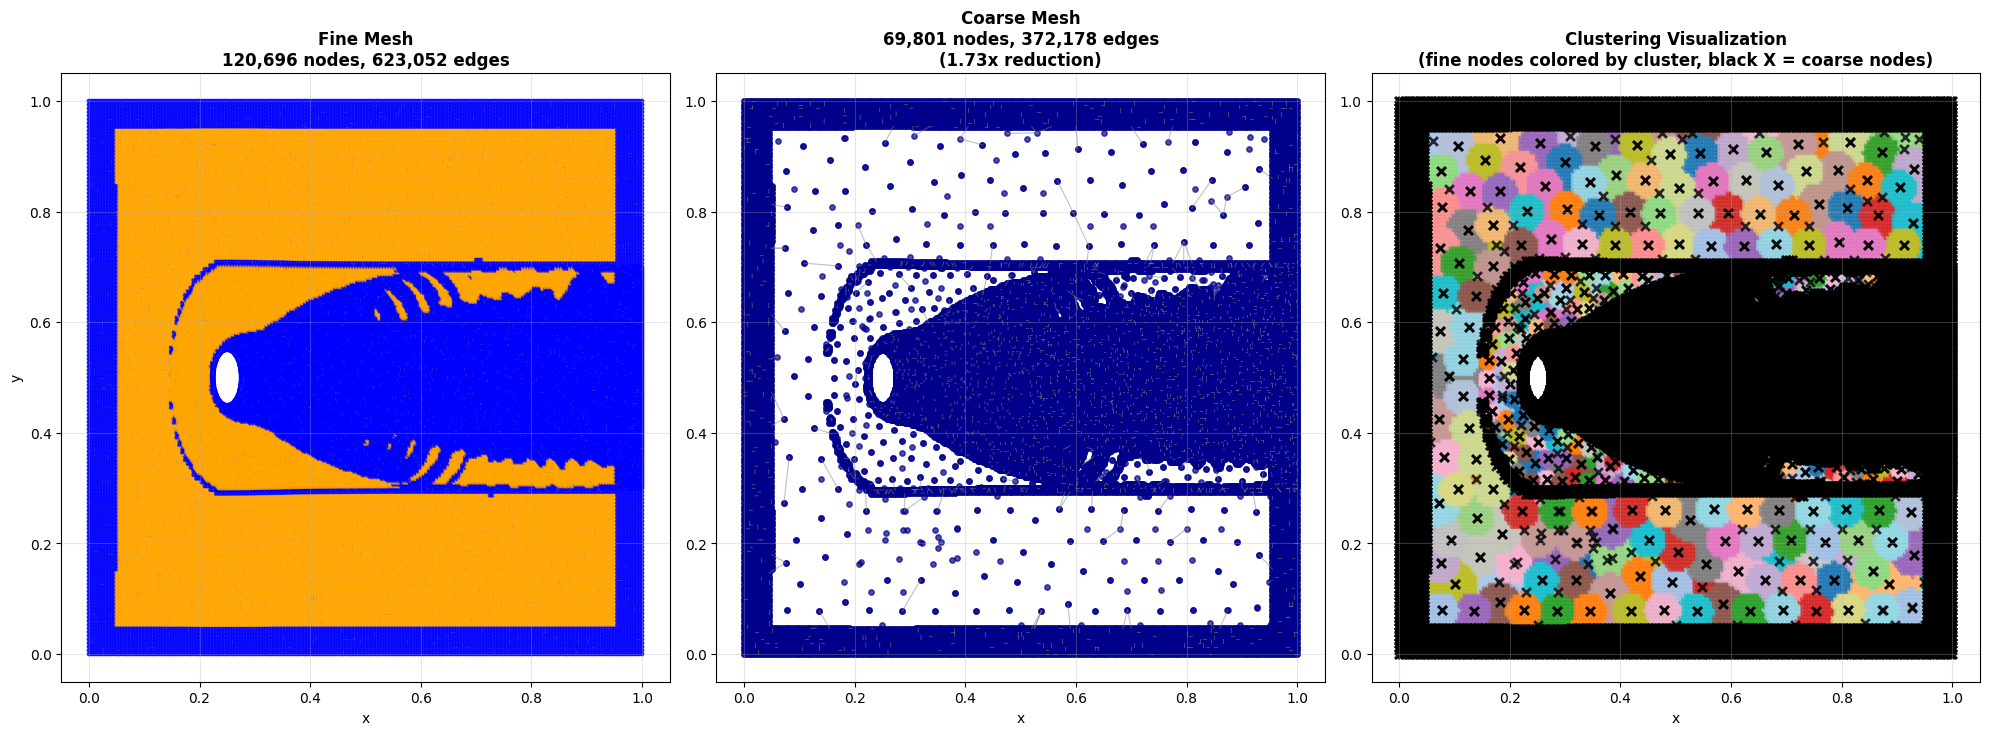


📊 Visualizing physics on 3 timesteps...

    Timestep 0:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t0_vorticity.png


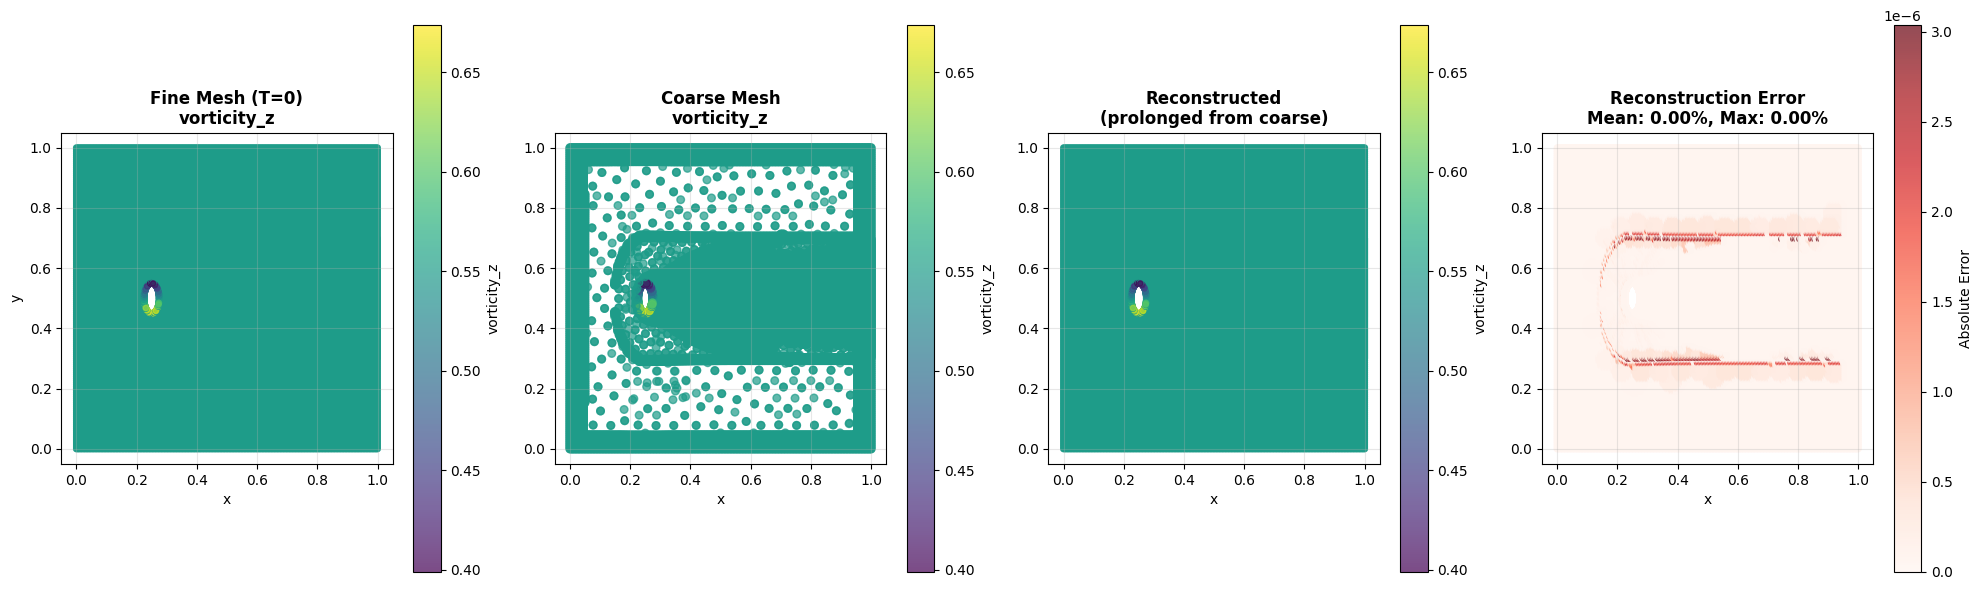


📊 Reconstruction Quality for vorticity_z:
    Mean relative error: 0.00%
    Max relative error: 0.00%
    RMS error: 0.000000
💾 Saved physics comparison to: ./coarsening_analysis/physics_t0_velocity.png


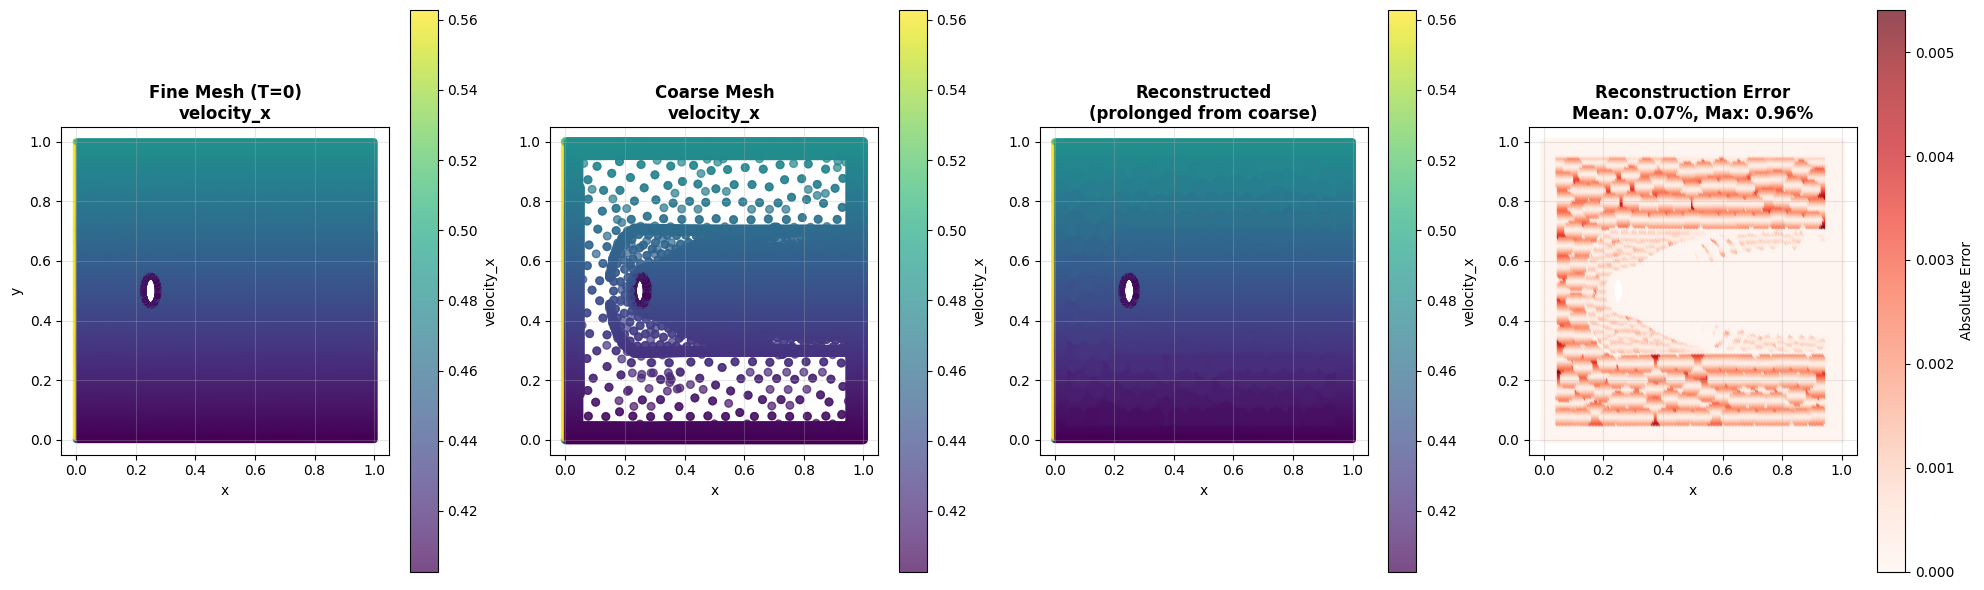


📊 Reconstruction Quality for velocity_x:
    Mean relative error: 0.07%
    Max relative error: 0.96%
    RMS error: 0.000757

    Timestep 100:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t100_vorticity.png


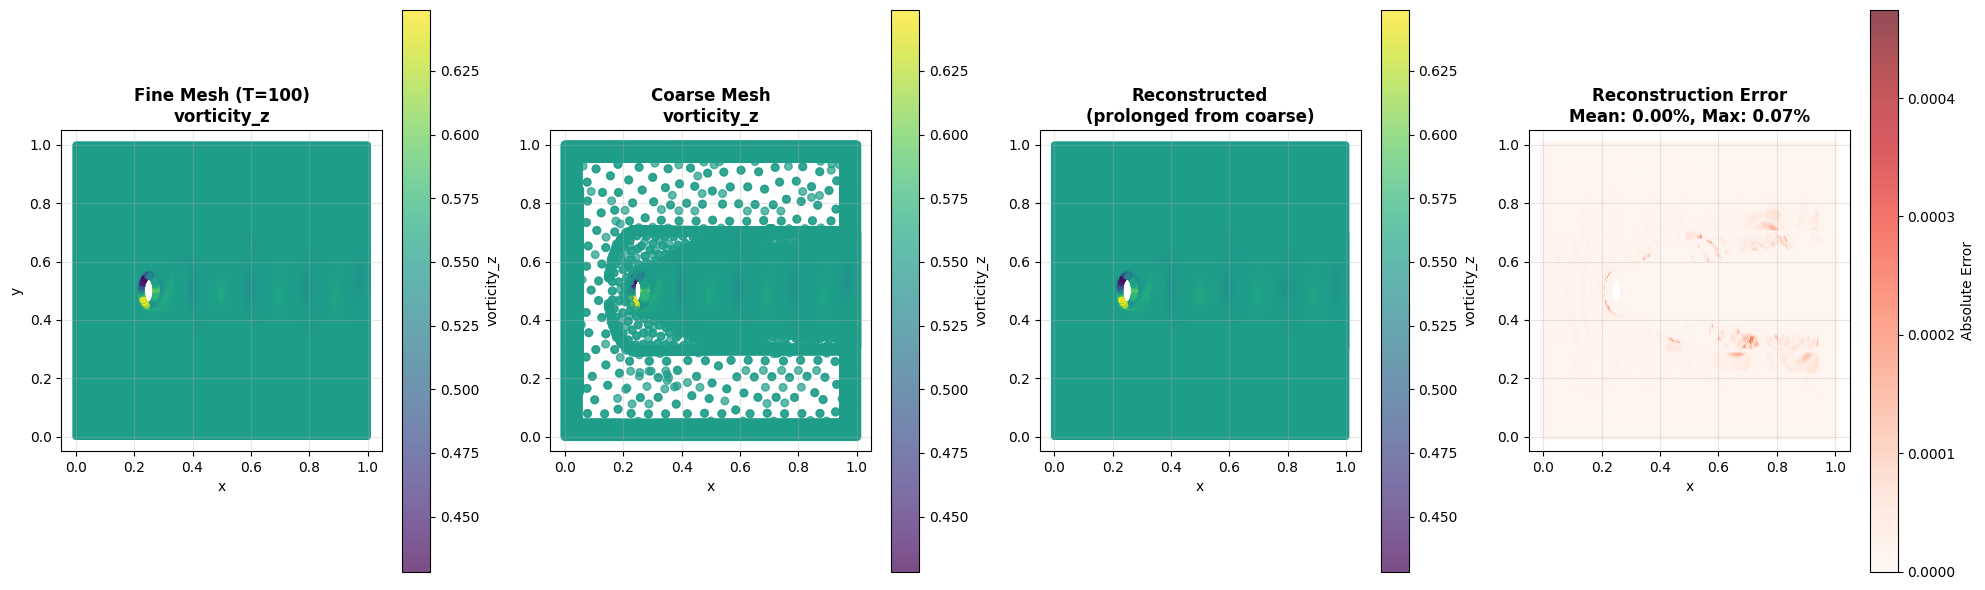


📊 Reconstruction Quality for vorticity_z:
    Mean relative error: 0.00%
    Max relative error: 0.07%
    RMS error: 0.000015
💾 Saved physics comparison to: ./coarsening_analysis/physics_t100_velocity.png


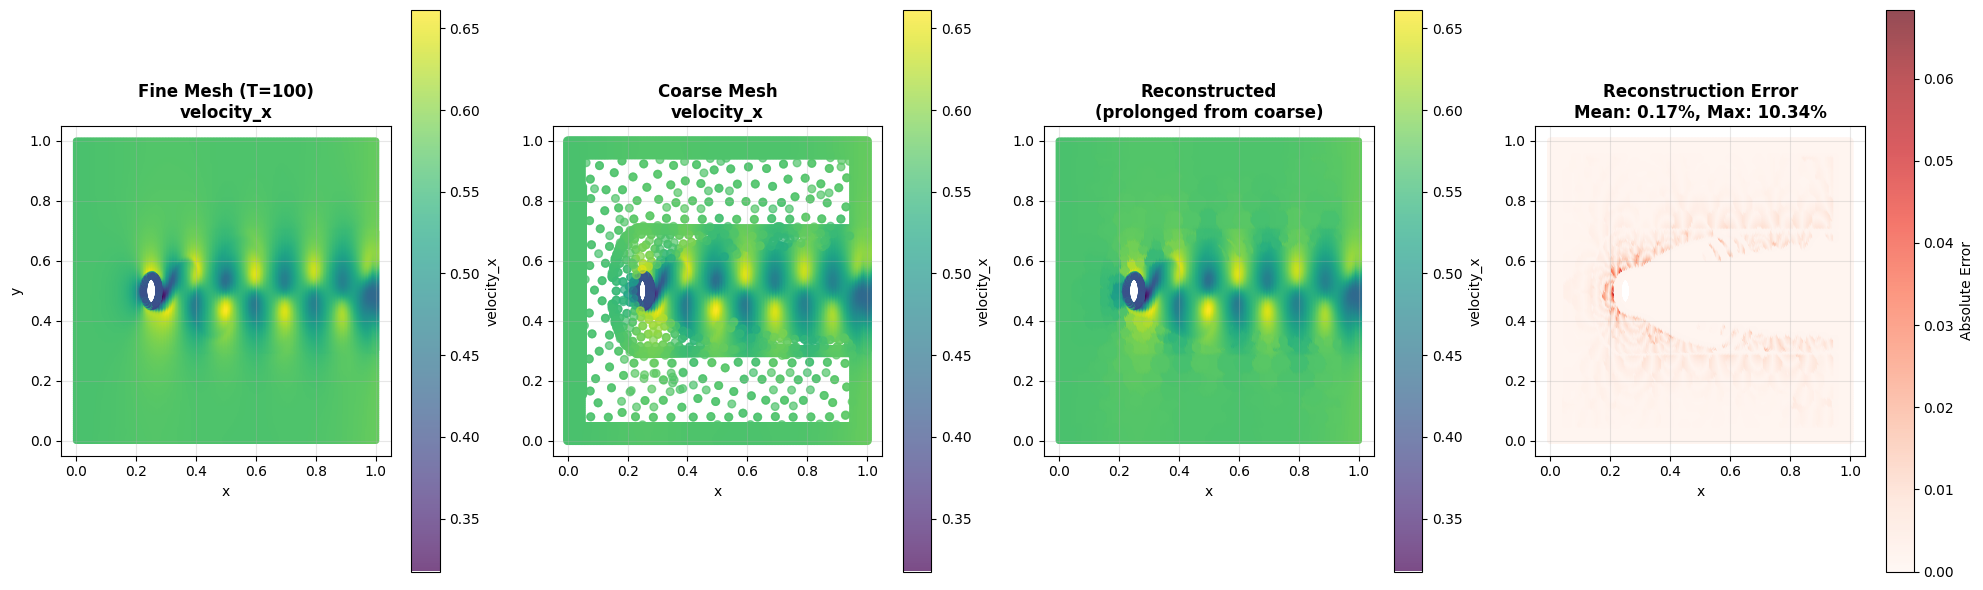


📊 Reconstruction Quality for velocity_x:
    Mean relative error: 0.17%
    Max relative error: 10.34%
    RMS error: 0.003088

    Timestep 200:
💾 Saved physics comparison to: ./coarsening_analysis/physics_t200_vorticity.png


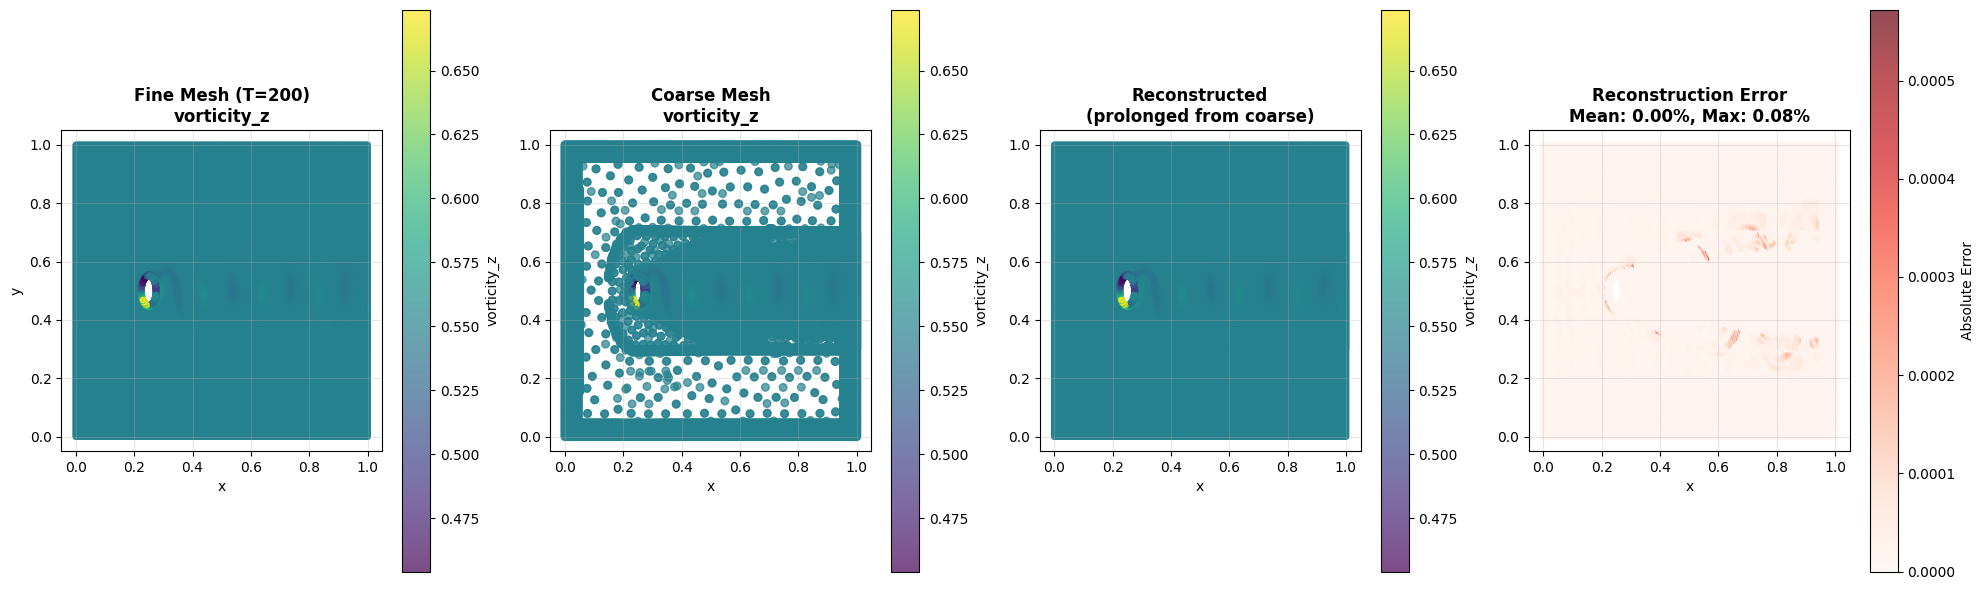


📊 Reconstruction Quality for vorticity_z:
    Mean relative error: 0.00%
    Max relative error: 0.08%
    RMS error: 0.000018
💾 Saved physics comparison to: ./coarsening_analysis/physics_t200_velocity.png


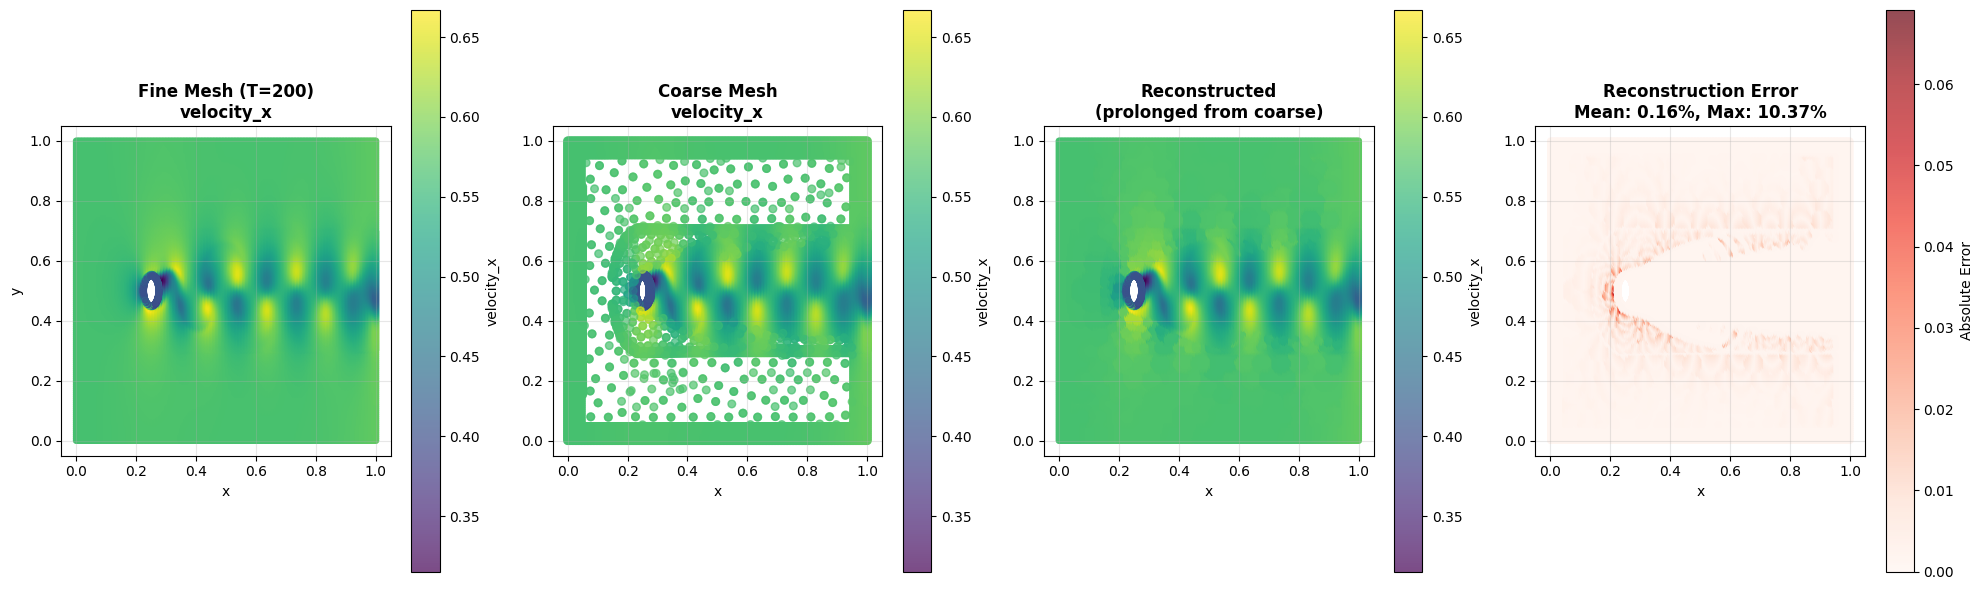


📊 Reconstruction Quality for velocity_x:
    Mean relative error: 0.16%
    Max relative error: 10.37%
    RMS error: 0.003029

🎬 GIF CREATION

🎬 Creating GIF for 'velocity_x'...
    Scanning for global color limits...


    Scanning: 100%|██████████| 40/40 [00:00<00:00, 1983.50it/s]


    Global limits for 'velocity_x': vmin=0.303, vmax=0.670


    Generating frames: 100%|██████████| 40/40 [11:12<00:00, 16.81s/it]


    Generated 40 frames. Now stitching into GIF...
✅ GIF saved to: coarsening_analysis/velocity_x_coarsened.gif
    Cleaned up frame directory: coarsening_analysis/frames_velocity_x

📈 SUMMARY
Original mesh: 120,696 nodes
Coarsened mesh: 69,801 nodes
Reduction: 1.73x

Mean reconstruction error (vorticity, static): 0.00%

Visualization files saved to: ./coarsening_analysis/

✅ Visualization complete!
📂 Check: ./coarsening_analysis/
    - mesh_comparison.png
    - physics_t*_...png
    - velocity_x_coarsened.gif


In [6]:
"""
Visualize Coarsened Mesh and Physics Fields (with GIF Export)

This script:
1. Loads the coarsening analysis results
2. Creates an adaptive coarsening map
3. Shows the coarsened mesh structure
4. Shows physics fields on both fine and coarse meshes
5. (NEW) Generates a GIF of the physics comparison over time
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pathlib import Path
from collections import defaultdict
from scipy.spatial import cKDTree

# --- NEW IMPORTS ---
import imageio.v3 as iio  # For GIF creation
import os
import shutil             # For cleaning up frame directory
from tqdm import tqdm     # For progress bar
# ---------------------


class MeshCoarsener:
    """Create and visualize coarsened mesh."""
    
    def __init__(self, data_list, coarsen_mask, keep_mask):
        """
        Args:
            data_list: Original fine mesh data
            coarsen_mask: Boolean array, True = nodes to coarsen
            keep_mask: Boolean array, True = nodes to keep fine
        """
        self.data_list = data_list
        self.reference_data = data_list[0]
        
        self.pos_fine = self.reference_data.pos.numpy()
        self.edge_index_fine = self.reference_data.edge_index.numpy()
        self.n_fine = self.pos_fine.shape[0]
        
        self.coarsen_mask = coarsen_mask
        self.keep_mask = keep_mask
        
        print(f"🔷 Fine mesh: {self.n_fine:,} nodes")
        print(f"    Keeping: {keep_mask.sum():,} nodes")
        print(f"    Coarsening: {coarsen_mask.sum():,} nodes")
        
        # --- (NEW) Store feature map for easy access ---
        self.feature_map = {
            'pressure': 3,
            'velocity_x': 4,
            'velocity_y': 5,
            'velocity_z': 6,
            'vorticity_x': 7,
            'vorticity_y': 8,
            'vorticity_z': 9
        }
        # ---------------------------------------------
        
    def create_simple_coarsening(self):
        # (This function is deprecated, keeping for compatibility)
        return self.create_cluster_coarsening(cluster_size=3)
    
    def create_adaptive_coarsening(self, min_cluster_size=2, max_cluster_size=6, 
                                   similarity_weight=0.3, importance_scores=None):
        """
        Create coarsening with adaptive cluster sizes based on local importance.
        """
        print(f"\n🔨 Creating adaptive cluster-based coarsening...")
        print(f"    Cluster size range: {min_cluster_size}-{max_cluster_size} nodes")
        
        # Initialize assignment
        assignment = np.full(self.n_fine, -1, dtype=int)
        coarse_idx = 0
        
        # Step 1: Assign all "keep" nodes to their own coarse nodes
        for node in range(self.n_fine):
            if self.keep_mask[node]:
                assignment[node] = coarse_idx
                coarse_idx += 1
        
        print(f"    Assigned {coarse_idx:,} fine nodes (kept as-is)")
        
        # Step 2: Compute or use provided importance scores
        if importance_scores is None:
            # Compute simple importance from feature variance
            x_fine = self.reference_data.x.numpy()
            importance_scores = np.var(x_fine[:, 3:], axis=1) # Variance of physics features
            importance_scores = (importance_scores - importance_scores.min()) / \
                                (importance_scores.max() - importance_scores.min() + 1e-10)
        
        # Step 3: Determine target cluster size for each coarsenable node
        target_cluster_sizes = np.zeros(self.n_fine, dtype=int)
        for node in range(self.n_fine):
            if self.coarsen_mask[node]:
                target_size = min_cluster_size + \
                              (1.0 - importance_scores[node]) * (max_cluster_size - min_cluster_size)
                target_cluster_sizes[node] = int(np.round(target_size))
        
        print(f"    Target cluster sizes: min={target_cluster_sizes[self.coarsen_mask].min()}, "
              f"max={target_cluster_sizes[self.coarsen_mask].max()}, "
              f"mean={target_cluster_sizes[self.coarsen_mask].mean():.2f}")
        
        # Step 4: Build adjacency
        adjacency = defaultdict(list)
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            adjacency[src].append(dst)
            adjacency[dst].append(src)
        
        # Step 5: Get normalized features for similarity
        x_fine = self.reference_data.x.numpy()
        x_norm = (x_fine - x_fine.min(axis=0)) / (x_fine.max(axis=0) - x_fine.min(axis=0) + 1e-10)
        
        # Step 6: Cluster coarsenable nodes with adaptive sizes
        coarsen_nodes = np.where(self.coarsen_mask)[0]
        importance_order = np.argsort(-importance_scores[coarsen_nodes]) # Descending
        coarsen_nodes_sorted = coarsen_nodes[importance_order]
        
        assigned_coarsen = set()
        cluster_sizes_achieved = []
        
        # --- (Use tqdm for progress bar on the long clustering loop) ---
        for seed_node in tqdm(coarsen_nodes_sorted, desc="    Clustering nodes"):
            if seed_node in assigned_coarsen:
                continue
            
            # Get adaptive target size for this seed
            target_size = target_cluster_sizes[seed_node]
            
            # Start cluster
            cluster = [seed_node]
            assigned_coarsen.add(seed_node)
            
            # Grow cluster
            candidates = set(adjacency[seed_node])
            
            while len(cluster) < target_size and len(candidates) > 0:
                best_score = -np.inf
                best_candidate = None
                
                for candidate in candidates:
                    if not self.coarsen_mask[candidate] or candidate in assigned_coarsen:
                        continue
                    
                    candidate_target = target_cluster_sizes[candidate]
                    combined_target = (target_size + candidate_target) / 2
                    if len(cluster) >= combined_target * 1.5: # Allow flexibility
                        continue
                    
                    # Compute similarity
                    cluster_indices = np.array(cluster)
                    
                    # Spatial similarity
                    cluster_pos = self.pos_fine[cluster_indices].mean(axis=0)
                    spatial_dist = np.linalg.norm(self.pos_fine[candidate] - cluster_pos)
                    spatial_sim = np.exp(-spatial_dist * 5) # Decay parameter
                    
                    # Feature similarity
                    cluster_feat = x_norm[cluster_indices].mean(axis=0)
                    feat_sim = np.dot(x_norm[candidate], cluster_feat) / (
                        np.linalg.norm(x_norm[candidate]) * np.linalg.norm(cluster_feat) + 1e-10
                    )
                    
                    # Importance similarity
                    importance_sim = 1.0 - abs(importance_scores[seed_node] - importance_scores[candidate])
                    
                    # Combined score
                    score = (1 - similarity_weight) * spatial_sim + \
                            similarity_weight * feat_sim + \
                            0.1 * importance_sim
                    
                    if score > best_score:
                        best_score = score
                        best_candidate = candidate
                
                if best_candidate is not None:
                    cluster.append(best_candidate)
                    assigned_coarsen.add(best_candidate)
                    
                    # Add new neighbors
                    for neighbor in adjacency[best_candidate]:
                        if neighbor not in assigned_coarsen and self.coarsen_mask[neighbor]:
                            candidates.add(neighbor)
                    
                    candidates.discard(best_candidate)
                else:
                    break
            
            # Assign cluster
            for node in cluster:
                assignment[node] = coarse_idx
            
            cluster_sizes_achieved.append(len(cluster))
            coarse_idx += 1
        
        # Handle unassigned nodes
        for node in coarsen_nodes:
            if assignment[node] == -1:
                assignment[node] = coarse_idx
                cluster_sizes_achieved.append(1)
                coarse_idx += 1
        
        n_coarse = coarse_idx
        
        # Statistics
        cluster_sizes_achieved = np.array(cluster_sizes_achieved)
        print(f"    Created {n_coarse:,} coarse nodes")
        print(f"    Achieved cluster sizes: min={cluster_sizes_achieved.min()}, "
              f"max={cluster_sizes_achieved.max()}, mean={cluster_sizes_achieved.mean():.2f}")
        print(f"    Reduction: {self.n_fine / n_coarse:.2f}x")
        
        # ... (rest of function is unchanged) ...
        
        # Compute coarse positions
        coarse_pos = np.zeros((n_coarse, 3))
        coarse_counts = np.zeros(n_coarse)
        
        for node in range(self.n_fine):
            c_idx = assignment[node]
            coarse_pos[c_idx] += self.pos_fine[node]
            coarse_counts[c_idx] += 1
        
        coarse_pos /= coarse_counts[:, None]
        
        # Create coarse edges
        print("    Building coarse edges...")
        coarse_edges_set = set()
        
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            c_src = assignment[src]
            c_dst = assignment[dst]
            
            if c_src != c_dst:
                coarse_edges_set.add((min(c_src, c_dst), max(c_src, c_dst)))
        
        coarse_edges = np.array(list(coarse_edges_set)).T
        coarse_edge_index = np.hstack([coarse_edges, coarse_edges[[1, 0]]])
        
        print(f"    Coarse edges: {coarse_edge_index.shape[1]:,}")
        print(f"    Edge reduction: {self.edge_index_fine.shape[1] / coarse_edge_index.shape[1]:.2f}x")
        
        return assignment, coarse_pos, n_coarse, coarse_edge_index

    # --- (create_cluster_coarsening is unchanged) ---
    def create_cluster_coarsening(self, cluster_size=3, similarity_weight=0.3):
        print(f"\n🔨 Creating cluster-based coarsening (target cluster size: {cluster_size})...")
        assignment = np.full(self.n_fine, -1, dtype=int)
        coarse_idx = 0
        for node in range(self.n_fine):
            if self.keep_mask[node]:
                assignment[node] = coarse_idx
                coarse_idx += 1
        print(f"    Assigned {coarse_idx:,} fine nodes (kept as-is)")
        adjacency = defaultdict(list)
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            adjacency[src].append(dst)
            adjacency[dst].append(src)
        x_fine = self.reference_data.x.numpy()
        x_norm = (x_fine - x_fine.min(axis=0)) / (x_fine.max(axis=0) - x_fine.min(axis=0) + 1e-10)
        coarsen_nodes = np.where(self.coarsen_mask)[0]
        assigned_coarsen = set()
        for seed_node in tqdm(coarsen_nodes, desc="    Clustering nodes"):
            if seed_node in assigned_coarsen:
                continue
            cluster = [seed_node]
            assigned_coarsen.add(seed_node)
            candidates = set(adjacency[seed_node])
            while len(cluster) < cluster_size and len(candidates) > 0:
                best_score = -np.inf
                best_candidate = None
                for candidate in candidates:
                    if not self.coarsen_mask[candidate] or candidate in assigned_coarsen:
                        continue
                    cluster_indices = np.array(cluster)
                    cluster_pos = self.pos_fine[cluster_indices].mean(axis=0)
                    spatial_dist = np.linalg.norm(self.pos_fine[candidate] - cluster_pos)
                    spatial_sim = np.exp(-spatial_dist)
                    cluster_feat = x_norm[cluster_indices].mean(axis=0)
                    feat_sim = np.dot(x_norm[candidate], cluster_feat) / (
                        np.linalg.norm(x_norm[candidate]) * np.linalg.norm(cluster_feat) + 1e-10
                    )
                    score = (1 - similarity_weight) * spatial_sim + similarity_weight * feat_sim
                    if score > best_score:
                        best_score = score
                        best_candidate = candidate
                if best_candidate is not None:
                    cluster.append(best_candidate)
                    assigned_coarsen.add(best_candidate)
                    for neighbor in adjacency[best_candidate]:
                        if neighbor not in assigned_coarsen and self.coarsen_mask[neighbor]:
                            candidates.add(neighbor)
                    candidates.discard(best_candidate)
                else:
                    break
            for node in cluster:
                assignment[node] = coarse_idx
            coarse_idx += 1
        for node in coarsen_nodes:
            if assignment[node] == -1:
                assignment[node] = coarse_idx
                coarse_idx += 1
        n_coarse = coarse_idx
        cluster_sizes = []
        for c in range(coarse_idx):
            size = (assignment == c).sum()
            if size > 1:
                cluster_sizes.append(size)
        avg_cluster = np.mean(cluster_sizes) if len(cluster_sizes) > 0 else 1
        print(f"    Created {n_coarse:,} coarse nodes")
        print(f"    Average cluster size: {avg_cluster:.2f} nodes")
        print(f"    Reduction: {self.n_fine / n_coarse:.2f}x")
        coarse_pos = np.zeros((n_coarse, 3))
        coarse_counts = np.zeros(n_coarse)
        for node in range(self.n_fine):
            c_idx = assignment[node]
            coarse_pos[c_idx] += self.pos_fine[node]
            coarse_counts[c_idx] += 1
        coarse_pos /= coarse_counts[:, None]
        print("    Building coarse edges...")
        coarse_edges_set = set()
        for i in range(self.edge_index_fine.shape[1]):
            src, dst = self.edge_index_fine[:, i]
            c_src = assignment[src]
            c_dst = assignment[dst]
            if c_src != c_dst:
                coarse_edges_set.add((min(c_src, c_dst), max(c_src, c_dst)))
        coarse_edges = np.array(list(coarse_edges_set)).T
        coarse_edge_index = np.hstack([coarse_edges, coarse_edges[[1, 0]]])
        print(f"    Coarse edges: {coarse_edge_index.shape[1]:,}")
        print(f"    Edge reduction: {self.edge_index_fine.shape[1] / coarse_edge_index.shape[1]:.2f}x")
        return assignment, coarse_pos, n_coarse, coarse_edge_index


    def aggregate_features(self, timestep_idx, assignment, n_coarse):
        # (This function is unchanged)
        data = self.data_list[timestep_idx]
        x_fine = data.x.numpy()
        
        x_coarse = np.zeros((n_coarse, x_fine.shape[1]))
        counts = np.zeros(n_coarse)
        
        for node in range(self.n_fine):
            c_idx = assignment[node]
            x_coarse[c_idx] += x_fine[node]
            counts[c_idx] += 1
        
        # Avoid division by zero for any empty coarse nodes (shouldn't happen)
        counts[counts == 0] = 1
        x_coarse /= counts[:, None]
        
        return x_coarse

    def visualize_mesh_comparison(self, assignment, coarse_pos, coarse_edge_index,
                                  figsize=(20, 10), save_path=None, 
                                  show_edges=True, max_edges=5000):
        # (This function is unchanged)
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        x_fine, y_fine = self.pos_fine[:, 0], self.pos_fine[:, 1]
        x_coarse, y_coarse = coarse_pos[:, 0], coarse_pos[:, 1]
        
        # Panel 1: Fine mesh
        ax = axes[0]
        if show_edges:
            n_edges_fine = self.edge_index_fine.shape[1]
            edge_indices = np.random.choice(n_edges_fine, min(n_edges_fine, max_edges), replace=False)
            for idx in edge_indices:
                src, dst = self.edge_index_fine[:, idx]
                ax.plot([x_fine[src], x_fine[dst]], 
                        [y_fine[src], y_fine[dst]], 
                        'gray', alpha=0.3, linewidth=0.5)
        
        colors = np.where(self.keep_mask, 'blue', 'orange')
        ax.scatter(x_fine, y_fine, c=colors, s=5, alpha=0.6)
        ax.set_title(f'Fine Mesh\n{self.n_fine:,} nodes, {self.edge_index_fine.shape[1]:,} edges', 
                     fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 2: Coarse mesh
        ax = axes[1]
        if show_edges:
            n_edges_coarse = coarse_edge_index.shape[1]
            edge_indices = np.random.choice(n_edges_coarse, min(n_edges_coarse, max_edges), replace=False)
            for idx in edge_indices:
                src, dst = coarse_edge_index[:, idx]
                ax.plot([x_coarse[src], x_coarse[dst]], 
                        [y_coarse[src], y_coarse[dst]], 
                        'gray', alpha=0.5, linewidth=0.8)
        
        ax.scatter(x_coarse, y_coarse, c='darkblue', s=15, alpha=0.7)
        n_coarse = coarse_pos.shape[0]
        reduction = self.n_fine / n_coarse
        ax.set_title(f'Coarse Mesh\n{n_coarse:,} nodes, {coarse_edge_index.shape[1]:,} edges\n({reduction:.2f}x reduction)', 
                     fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 3: Overlay showing clustering
        ax = axes[2]
        n_coarse = coarse_pos.shape[0]
        cmap = plt.cm.tab20
        
        # --- (Optimized drawing for many clusters) ---
        colors = [cmap(c % 20) for c in assignment]
        ax.scatter(x_fine, y_fine, c=colors, s=10, alpha=0.6)
        
        ax.scatter(x_coarse, y_coarse, c='black', s=40, alpha=0.8, 
                   marker='x', linewidths=2)
        
        ax.set_title('Clustering Visualization\n(fine nodes colored by cluster, black X = coarse nodes)', 
                     fontweight='bold', fontsize=12)
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Saved mesh comparison to: {save_path}")
        
        plt.show()

    # --- (MODIFIED FUNCTION) ---
    def visualize_physics_comparison(self, timestep_idx, assignment, coarse_pos, 
                                     x_coarse, feature_name='vorticity_z',
                                     figsize=(20, 6), save_path=None,
                                     show_plot=True, verbose=True,  # New flags
                                     vmin_global=None, vmax_global=None): # New color limits
        """
        Compare physics field on fine vs coarse mesh.
        """
        feat_idx = self.feature_map.get(feature_name, 9)
        
        # Get fine data
        data = self.data_list[timestep_idx]
        x_fine = data.x.numpy()
        pos_fine = self.pos_fine
        
        # Get values
        values_fine = x_fine[:, feat_idx]
        values_coarse = x_coarse[:, feat_idx]
        
        # Reconstruct: prolong coarse back to fine mesh
        values_reconstructed = values_coarse[assignment]
        
        # Compute reconstruction error
        error = np.abs(values_fine - values_reconstructed)
        rel_error = error / (np.abs(values_fine).max() + 1e-10)
        mean_rel_error = rel_error.mean()
        max_rel_error = rel_error.max()
        
        # Plot
        fig, axes = plt.subplots(1, 4, figsize=figsize)
        
        x_fine, y_fine = pos_fine[:, 0], pos_fine[:, 1]
        x_coarse, y_coarse = coarse_pos[:, 0], coarse_pos[:, 1]
        
        # Shared colorbar limits
        # (Use global limits if provided, otherwise compute from data)
        if vmin_global is not None and vmax_global is not None:
            vmin = vmin_global
            vmax = vmax_global
        else:
            vmin = min(values_fine.min(), values_coarse.min())
            vmax = max(values_fine.max(), values_coarse.max())
        
        # Panel 1: Fine mesh field
        ax = axes[0]
        scatter = ax.scatter(x_fine, y_fine, c=values_fine, cmap='viridis',
                             s=15, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Fine Mesh (T={timestep_idx})\n{feature_name}', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 2: Coarse mesh field
        ax = axes[1]
        scatter = ax.scatter(x_coarse, y_coarse, c=values_coarse, cmap='viridis',
                             s=30, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Coarse Mesh\n{feature_name}', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 3: Reconstructed (prolonged) field
        ax = axes[2]
        scatter = ax.scatter(x_fine, y_fine, c=values_reconstructed, cmap='viridis',
                             s=15, alpha=0.7, vmin=vmin, vmax=vmax)
        plt.colorbar(scatter, ax=ax, label=feature_name)
        ax.set_title(f'Reconstructed\n(prolonged from coarse)', fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Panel 4: Absolute error
        ax = axes[3]
        scatter = ax.scatter(x_fine, y_fine, c=error, cmap='Reds',
                             s=15, alpha=0.7)
        plt.colorbar(scatter, ax=ax, label='Absolute Error')
        ax.set_title(f'Reconstruction Error\nMean: {mean_rel_error:.2%}, Max: {max_rel_error:.2%}', 
                     fontweight='bold')
        ax.set_xlabel('x')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            Path(save_path).parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            if verbose: # Only print if not in silent (GIF) mode
                print(f"💾 Saved physics comparison to: {save_path}")
        
        if show_plot:
            plt.show()
        
        plt.close(fig) # Always close figure to save memory
        
        if verbose: # Only print if not in silent (GIF) mode
            print(f"\n📊 Reconstruction Quality for {feature_name}:")
            print(f"    Mean relative error: {mean_rel_error:.2%}")
            print(f"    Max relative error: {max_rel_error:.2%}")
            print(f"    RMS error: {np.sqrt(np.mean(error**2)):.6f}")
        
        return mean_rel_error


# --- (NEW FUNCTION FOR GIF CREATION) ---
def create_physics_gif(coarsener, assignment, coarse_pos, n_coarse, 
                         feature_name, 
                         max_steps, 
                         output_dir, 
                         gif_filename="coarsened_physics.gif",
                         step_skip=1,
                         fps=15):
    """
    Generate a GIF of the coarsened physics comparison over time.
    """
    print(f"\n🎬 Creating GIF for '{feature_name}'...")
    
    # Create a temporary directory for frames
    frame_dir = Path(output_dir) / f"frames_{feature_name}"
    frame_dir.mkdir(parents=True, exist_ok=True)
    
    filenames = []
    
    num_timesteps = min(max_steps, len(coarsener.data_list))
    timesteps_to_process = range(0, num_timesteps, step_skip)
    feat_idx = coarsener.feature_map.get(feature_name, 9)

    # --- Pass 1: Scan for global color limits ---
    # This ensures the colorbar is consistent across the whole GIF
    print("    Scanning for global color limits...")
    vmin = np.inf
    vmax = -np.inf
    for ts_idx in tqdm(timesteps_to_process, desc="    Scanning"):
        data = coarsener.data_list[ts_idx]
        x_fine = data.x.numpy()
        values_fine = x_fine[:, feat_idx]
        vmin = min(vmin, values_fine.min())
        vmax = max(vmax, values_fine.max())
    print(f"    Global limits for '{feature_name}': vmin={vmin:.3f}, vmax={vmax:.3f}")

    # --- Pass 2: Generate all frames ---
    for ts_idx in tqdm(timesteps_to_process, desc="    Generating frames"):
        x_coarse = coarsener.aggregate_features(ts_idx, assignment, n_coarse)
        
        save_path = frame_dir / f"frame_{ts_idx:04d}.png"
        filenames.append(str(save_path))
        
        # Call the visualization function, but tell it to be quiet and not show plot
        coarsener.visualize_physics_comparison(
            ts_idx, assignment, coarse_pos, x_coarse,
            feature_name=feature_name,
            save_path=save_path,
            show_plot=False,  # Don't pop up hundreds of plots
            verbose=False,    # Don't print stats for every frame
            vmin_global=vmin, # Use consistent color scale
            vmax_global=vmax  # Use consistent color scale
        )
        
    print(f"    Generated {len(filenames)} frames. Now stitching into GIF...")
    
    # --- Stitch frames into a GIF ---
    gif_path = Path(output_dir) / gif_filename
    
    # Read images and write to GIF
    images = [iio.imread(f) for f in filenames]
    iio.imwrite(gif_path, images, fps=fps) # <-- Corrected: 'imwrite' instead of 'mimwrite'
    
    print(f"✅ GIF saved to: {gif_path}")
    
    # --- Clean up temporary frame directory ---
    try:
        shutil.rmtree(frame_dir)
        print(f"    Cleaned up frame directory: {frame_dir}")
    except Exception as e:
        print(f"    Warning: Could not clean up frame directory. {e}")


# --- (MODIFIED FUNCTION) ---
def run_coarsened_visualization(data_file, coarsening_results_file, 
                              timesteps_to_show=[0, 50, 100],
                              output_dir="./coarsening_analysis",
                              adaptive=True,
                              cluster_size=3,
                              min_cluster_size=2,
                              max_cluster_size=6,
                              similarity_weight=0.3,
                              # --- New parameters ---
                              create_gif=False,
                              gif_max_steps=200,
                              gif_step_skip=5,
                              gif_fps=15):
    """
    Complete visualization of coarsened mesh and physics.
    """
    print("="*70)
    print("🔬 COARSENED MESH VISUALIZATION")
    print("="*70)
    
    # Load data
    print("\n⏳ Loading data...")
    data_list = torch.load(data_file, weights_only=False)
    print(f"✅ Loaded {len(data_list)} timesteps")
    
    # Load coarsening results
    print("⏳ Loading coarsening analysis...")
    results = np.load(coarsening_results_file)
    coarsen_mask = results['coarsen_mask']
    keep_mask = results['keep_mask']
    importance_combined = results['importance_combined'] # Use from analysis
    print(f"✅ Loaded coarsening decisions")
    
    # Create coarsener
    coarsener = MeshCoarsener(data_list, coarsen_mask, keep_mask)
    
    # Create coarsening map
    if adaptive:
        print(f"\n⚙️   Adaptive clustering parameters:")
        print(f"    Cluster size range: {min_cluster_size}-{max_cluster_size} nodes")
        print(f"    High importance → {min_cluster_size} nodes (preserve detail)")
        print(f"    Low importance → {max_cluster_size} nodes (aggressive coarsening)")
        print(f"    Similarity weight: {similarity_weight}")
        
        assignment, coarse_pos, n_coarse, coarse_edge_index = coarsener.create_adaptive_coarsening(
            min_cluster_size=min_cluster_size,
            max_cluster_size=max_cluster_size,
            similarity_weight=similarity_weight,
            importance_scores=importance_combined
        )
    else:
        print(f"\n⚙️   Fixed clustering parameters:")
        print(f"    Target cluster size: {cluster_size} nodes")
        print(f"    Similarity weight: {similarity_weight}")
        
        assignment, coarse_pos, n_coarse, coarse_edge_index = coarsener.create_cluster_coarsening(
            cluster_size=cluster_size,
            similarity_weight=similarity_weight
        )
    
    # Visualize mesh structure
    print("\n📊 Visualizing mesh structure...")
    coarsener.visualize_mesh_comparison(
        assignment, coarse_pos, coarse_edge_index,
        save_path=f"{output_dir}/mesh_comparison.png",
        show_edges=True,
        max_edges=3000
    )
    
    # Visualize physics on multiple timesteps (static images)
    print(f"\n📊 Visualizing physics on {len(timesteps_to_show)} timesteps...")
    
    errors = []
    for ts_idx in timesteps_to_show:
        if ts_idx >= len(data_list):
            print(f"⚠️  Skipping timestep {ts_idx} (out of range)")
            continue
        
        print(f"\n    Timestep {ts_idx}:")
        
        # Aggregate features
        x_coarse = coarsener.aggregate_features(ts_idx, assignment, n_coarse)
        
        # Visualize vorticity_z
        error = coarsener.visualize_physics_comparison(
            ts_idx, assignment, coarse_pos, x_coarse,
            feature_name='vorticity_z',
            save_path=f"{output_dir}/physics_t{ts_idx}_vorticity.png",
            show_plot=True, verbose=True # Show plot and print stats
        )
        errors.append(error)
        
        # Visualize velocity_x
        error = coarsener.visualize_physics_comparison(
            ts_idx, assignment, coarse_pos, x_coarse,
            feature_name='velocity_x',
            save_path=f"{output_dir}/physics_t{ts_idx}_velocity.png",
            show_plot=True, verbose=True # Show plot and print stats
        )
    
    # --- (NEW) Create GIF ---
    if create_gif:
        print("\n" + "="*70)
        print("🎬 GIF CREATION")
        print("="*70)
        
        # Create GIF for velocity_x
        create_physics_gif(
            coarsener, assignment, coarse_pos, n_coarse,
            feature_name='velocity_x',
            max_steps=gif_max_steps,
            output_dir=output_dir,
            gif_filename="velocity_x_coarsened.gif",
            step_skip=gif_step_skip,
            fps=gif_fps
        )
        
        # You could also create one for vorticity here if you want
        # create_physics_gif(
        #     coarsener, assignment, coarse_pos, n_coarse,
        #     feature_name='vorticity_z',
        #     max_steps=gif_max_steps,
        #     output_dir=output_dir,
        #     gif_filename="vorticity_z_coarsened.gif",
        #     step_skip=gif_step_skip,
        #     fps=gif_fps
        # )
    # --------------------------

    print("\n" + "="*70)
    print("📈 SUMMARY")
    print("="*70)
    print(f"Original mesh: {coarsener.n_fine:,} nodes")
    print(f"Coarsened mesh: {n_coarse:,} nodes")
    print(f"Reduction: {coarsener.n_fine / n_coarse:.2f}x")
    print(f"\nMean reconstruction error (vorticity, static): {np.mean(errors):.2%}")
    print(f"\nVisualization files saved to: {output_dir}/")
    print("="*70)


if __name__ == "__main__":
    
    # ===== CONFIGURATION =====
    
    # (These paths should be correct from your previous script)
    DATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized/train/Re_550_normalized.pt"
    COARSENING_RESULTS = "./coarsening_analysis/coarsening_results.npz"
    
    # Which timesteps to visualize for STATIC images
    TIMESTEPS = [0, 100, 200]
    
    OUTPUT_DIR = "./coarsening_analysis"
    
    # === ADAPTIVE CLUSTERING (RECOMMENDED) ===
    ADAPTIVE = True
    MIN_CLUSTER_SIZE = 2 
    MAX_CLUSTER_SIZE = 100 
    
    # === FIXED CLUSTERING (if ADAPTIVE=False) ===
    CLUSTER_SIZE = 3 
    
    # === COMMON PARAMETERS ===
    SIMILARITY_WEIGHT = 0.3 # 0.0 = only spatial, 1.0 = only features
    
    # --- (NEW) GIF CREATION (Optional) ---
    CREATE_GIF = True   # Set to True to generate the GIF
    GIF_MAX_STEPS = 200 # Total number of timesteps to include in the GIF
    GIF_STEP_SKIP = 5   # Process every 5th frame (1=all, 2=every other, etc.)
    GIF_FPS = 1        # Frames per second for the final GIF
    # --------------------------------------
    
    # =========================
    
    try:
        run_coarsened_visualization(
            data_file=DATA_FILE,
            coarsening_results_file=COARSENING_RESULTS,
            timesteps_to_show=TIMESTEPS,
            output_dir=OUTPUT_DIR,
            adaptive=ADAPTIVE,
            cluster_size=CLUSTER_SIZE,
            min_cluster_size=MIN_CLUSTER_SIZE,
            max_cluster_size=MAX_CLUSTER_SIZE,
            similarity_weight=SIMILARITY_WEIGHT,
            # --- Pass new args ---
            create_gif=CREATE_GIF,
            gif_max_steps=GIF_MAX_STEPS,
            gif_step_skip=GIF_STEP_SKIP,
            gif_fps=GIF_FPS
        )
        
        print("\n✅ Visualization complete!")
        print(f"📂 Check: {OUTPUT_DIR}/")
        print("    - mesh_comparison.png")
        print("    - physics_t*_...png")
        if CREATE_GIF:
            print("    - velocity_x_coarsened.gif")
        
    except FileNotFoundError as e:
        print(f"\n❌ ERROR: {e}")
        print("\nMake sure you've run the coarsening analysis first:")
        print("  python karman_coarsening_analysis.py") # (Or whatever your analysis script is)
        
    except ImportError as e:
        print(f"\n❌ ERROR: Missing library - {e}")
        print("Please install the required libraries:")
        print("  pip install imageio tqdm")
        
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()